## Reading in packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from numpy import asarray
from numpy import savetxt
import matplotlib.colors as mcolors
import matplotlib.cm
import matplotlib.patches as mpatches
import umap
import matplotlib as mpl
import scanpy as sc
import scipy
import kmapper as km
from kmapper import jupyter
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
import plotly.graph_objs as go
import sys
import sklearn
from sklearn import ensemble
from tqdm import tqdm
from ripser import Rips
from ripser import ripser
from persim import plot_diagrams
from sklearn.metrics.pairwise import euclidean_distances

import kmapper as km
from kmapper import jupyter
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
import plotly.graph_objs as go
import sys
from sklearn import ensemble
import math

## Read in data

Select either the whole sc transformed dataset or just the variable genes

In [2]:
ILC_var = sc.read("sct_variable.h5ad")
ILC = sc.read("sct.h5ad")

c:\users\hmkri\desktop\riesenfeld pearson\lib\site-packages\anndata\compat\__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
c:\users\hmkri\desktop\riesenfeld pearson\lib\site-packages\anndata\compat\__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [3]:
PCA_coord = ILC_var.obsm["X_pca"]
Diff_coord = ILC_var.obsm["X_diffmap"]

In [4]:
norm_reads_sparse = ILC_var.layers["norm_data"]
#norm_reads_sparse = ILC.layers["norm_data"]
norm_reads = pd.DataFrame(norm_reads_sparse.toarray())
print("Norm reads: "+repr(norm_reads.shape))

UMAP = ILC_var.obsm["umap_cell_embeddings"]
UMAP = pd.DataFrame(np.array(UMAP))
print(UMAP.shape)
UMAP.to_csv('UMAP_ILC.csv', sep=',')

Diff = ILC_var.obsm['X_draw_graph_fa']
Diff = pd.DataFrame(np.array(Diff))
print(Diff.shape)
Diff.to_csv('FDL_ILC.csv', sep=',')

Norm reads: (26877, 3000)
(26877, 2)
(26877, 2)


## Selecting all ILC2 and ILC3 cells

### Run if writing csv files

In [5]:
Variable = ILC_var.var

Obs = ILC_var.obs
O = Obs["ilc2_ilc3"].to_frame()

Variable["Selected"].to_csv('Gene_list_ILC.csv', sep=',')
O.to_csv('Cell_list_ILC.csv', sep=',')

### Run if reading csv files

In [6]:
Gene_list = pd.read_csv("Gene_list_ILC.csv", sep=",", header = 0)
Gene_list = np.array(Gene_list)
Gene_list = Gene_list[:,0]
Cell_list = pd.read_csv("Cell_list_ILC.csv", sep=",", header = 0)
Cell_list = np.array(Cell_list)
Cell_list = Cell_list[:,0]

## Collecting cells of interest

In this model of psoriasis, tissue resident ILC2s are reprogramed to ILC3s. 

For analysis we are selecting for cells likely to be ILC2s or ILC3s on the basis of previously characterized populations.

In [31]:
#Full matrix of all counts
matrix = ILC_var.layers["norm_data"]
matrix = np.array(matrix.toarray())

ILC_total_reads = pd.DataFrame(matrix, index = Cell_list, columns = Gene_list)
print(ILC_total_reads.shape)

ILC_total_index = pd.DataFrame(ILC_total_reads.index)

(26877, 3000)


In [32]:
ILC_total_index.to_csv('total_reads_index_ILC.csv', sep=',')

In [8]:
#We have four labeled groups of cells that we want to collect together
ILC2_ILC3 = ILC_var.obs["ilc2_ilc3"]
ILC3_Q = ILC_var.obs["quiescent_ilc3"]
ILC2_Q = ILC_var.obs["ilc2_quiescent"]
cloud_ILC3 = ILC_var.obs["cloud_ilc3"]

df = pd.DataFrame(dict(ILC2_ILC3 = ILC2_ILC3, ILC3_Q = ILC3_Q, ILC2_Q = ILC2_Q, cloud_ILC3 = cloud_ILC3))
cells = df.shape[0]

In [9]:
#binary yes or no for if the cell is in our group
in_transition = np.zeros((cells, 1))

#Value of group - 0 if NA - over all cells
allcell_ILC2_ILC3 = np.zeros((cells, 1))
allcell_ILC3_Q = np.zeros((cells, 1))
allcell_ILC2_Q = np.zeros((cells, 1))
allcell_cloud_ILC3 = np.zeros((cells, 1))

#Cell labels - 0 if NA in all groups - over all cells
index_cells = np.zeros((cells, 1))
index_cells = index_cells.astype(str)

#Value of group - only cells in at least one group
val_ILC2_ILC3 = np.zeros((3807, 1))
val_ILC3_Q = np.zeros((3807, 1))
val_ILC2_Q = np.zeros((3807, 1))
val_cloud_ILC3 = np.zeros((3807, 1))

#Names of cells included in the value variables
index_val = np.array([])

#Variable for initially counting the number of cells in the groups of interest
number = 0


#Loops through the different groups so that we collect all cells with a value in at least one of the groups
for i in range(0,cells):
    if np.isnan(df["ILC2_ILC3"][i]):

        if np.isnan(df["ILC3_Q"][i]):

            if np.isnan(df["ILC2_Q"][i]):

                if np.isnan(df["cloud_ILC3"][i]):

                    in_transition[i,0] = 0
                    
                    allcell_ILC2_ILC3[i,0] = 0
                    allcell_ILC3_Q[i,0] = 0
                    allcell_ILC2_Q[i,0] = 0
                    allcell_cloud_ILC3[i,0] = 0
                    
                    index_cells[i,0] = "0"
                    
                else:
                    in_transition[i,0] = 1
                    
                    allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
                    allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
                    allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
                    allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
                    
                    index_cells[i,0] = Cell_list[i]
                    
                    val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
                    val_ILC3_Q[number] = df["ILC3_Q"][i]
                    val_ILC2_Q[number] = df["ILC2_Q"][i]
                    val_cloud_ILC3[number] = df["cloud_ILC3"][i]
                    
                    index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
                    
                    number += 1
            else:
                in_transition[i,0] = 1
                
                allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
                allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
                allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
                allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
                
                index_cells[i,0] = Cell_list[i]
                
                val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
                val_ILC3_Q[number] = df["ILC3_Q"][i]
                val_ILC2_Q[number] = df["ILC2_Q"][i]
                val_cloud_ILC3[number] = df["cloud_ILC3"][i]
                
                index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
                
                number += 1             

        else:
            in_transition[i,0] = 1
            
            allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
            allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
            allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
            allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
            
            index_cells[i,0] = Cell_list[i]
            
            val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
            val_ILC3_Q[number] = df["ILC3_Q"][i]
            val_ILC2_Q[number] = df["ILC2_Q"][i]
            val_cloud_ILC3[number] = df["cloud_ILC3"][i]
            
            index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
            
            number += 1
    
    else:
        in_transition[i,0] = 1
        
        allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
        allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
        allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
        allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
        
        index_cells[i,0] = Cell_list[i]
        
        val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
        val_ILC3_Q[number] = df["ILC3_Q"][i]
        val_ILC2_Q[number] = df["ILC2_Q"][i]
        val_cloud_ILC3[number] = df["cloud_ILC3"][i]
        
        index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
        
        number += 1
      

print(number)

3807


### Creating normalized read matrix for only the cells of interest

In [12]:
#Numpy array with normalized reads for all cells
norm_reads = np.array(norm_reads)
print(norm_reads.shape)
PCA_coord = np.array(PCA_coord)
print(PCA_coord.shape)
Diff_coord = np.array(Diff_coord)
print(Diff_coord.shape)

#Number of genes to initialize new matrix
genes = Gene_list.shape[0]
reads = np.zeros((1,3000 ))

PCA_reads = np.zeros((1,50))
Diff_reads = np.zeros((1,15))

#Going through all of the cells, if the  associated index in index_cell is nonzero then 
#it was included in our group and we should pull the associated gene expression data
for i in range(0,cells):
    j = index_cells[i]
    if j != "0":
        next_cell = norm_reads[i,:]
        next_cell = np.reshape(next_cell, (1,3000 ))
        reads = np.append(reads, next_cell, axis = 0)
        
        next_PCA = PCA_coord[i,:]
        next_PCA = np.reshape(next_PCA, (1,50))
        PCA_reads = np.append(PCA_reads, next_PCA, axis = 0)
        
        next_Diff = Diff_coord[i,:]
        next_Diff = np.reshape(next_Diff, (1,15))
        Diff_reads = np.append(Diff_reads, next_Diff, axis = 0)

#To get the indices to work out I have a row of zeros at the top that I need to omit
reads = reads[1:, :]    
PCA_reads = PCA_reads[1:, :]
Diff_reads = Diff_reads[1:, :]

(26877, 3000)
(26877, 50)
(26877, 15)


In [13]:
# ---------------------------------FDL-----------------------------------------
# Diff = FDL map
Diff_ILC2_ILC3 = np.zeros((1,2))
Diff_ILC3_Q = np.zeros((1,2))
Diff_ILC2_Q = np.zeros((1,2))
Diff_cloud_ILC3 = np.zeros((1,2))

for i in tqdm(range(cells)):
    if np.isnan(df["ILC2_ILC3"][i]) == False:
        Diff_ILC2_ILC3 = np.append(Diff_ILC2_ILC3, np.reshape(Diff[i,:], (1,2)), axis = 0)

for i in tqdm(range(cells)):
    if np.isnan(df["ILC3_Q"][i]) == False:
        Diff_ILC3_Q = np.append(Diff_ILC3_Q, np.reshape(Diff[i,:], (1,2)), axis = 0)
        
for i in tqdm(range(cells)):
    if np.isnan(df["ILC2_Q"][i]) == False:
        Diff_ILC2_Q = np.append(Diff_ILC2_Q, np.reshape(Diff[i,:], (1,2)), axis = 0)

for i in tqdm(range(cells)):
    if np.isnan(df["cloud_ILC3"][i]) == False:
        Diff_cloud_ILC3 = np.append(Diff_cloud_ILC3, np.reshape(Diff[i,:], (1,2)), axis = 0)
        
Diff_ILC2_ILC3 = Diff_ILC2_ILC3[1:,:]
Diff_ILC3_Q = Diff_ILC3_Q[1:,:]
Diff_ILC2_Q = Diff_ILC2_Q[1:,:]
Diff_cloud_ILC3 = Diff_cloud_ILC3[1:,:]

# ---------------------------------UMAP-----------------------------------------
UMAP_ILC2_ILC3 = np.zeros((1,2))
UMAP_ILC3_Q = np.zeros((1,2))
UMAP_ILC2_Q = np.zeros((1,2))
UMAP_cloud_ILC3 = np.zeros((1,2))

for i in tqdm(range(cells)):
    if np.isnan(df["ILC2_ILC3"][i]) == False:
        UMAP_ILC2_ILC3 = np.append(UMAP_ILC2_ILC3, np.reshape(UMAP[i,:], (1,2)), axis = 0)

for i in tqdm(range(cells)):
    if np.isnan(df["ILC3_Q"][i]) == False:
        UMAP_ILC3_Q = np.append(UMAP_ILC3_Q, np.reshape(UMAP[i,:], (1,2)), axis = 0)
        
for i in tqdm(range(cells)):
    if np.isnan(df["ILC2_Q"][i]) == False:
        UMAP_ILC2_Q = np.append(UMAP_ILC2_Q, np.reshape(UMAP[i,:], (1,2)), axis = 0)

for i in tqdm(range(cells)):
    if np.isnan(df["cloud_ILC3"][i]) == False:
        UMAP_cloud_ILC3 = np.append(UMAP_cloud_ILC3, np.reshape(UMAP[i,:], (1,2)), axis = 0)
        
UMAP_ILC2_ILC3 = UMAP_ILC2_ILC3[1:,:]
UMAP_ILC3_Q = UMAP_ILC3_Q[1:,:]
UMAP_ILC2_Q = UMAP_ILC2_Q[1:,:]
UMAP_cloud_ILC3 = UMAP_cloud_ILC3[1:,:]

  0%|                                                                                        | 0/26877 [00:00<?, ?it/s]


TypeError: '(0, slice(None, None, None))' is an invalid key

In [ ]:
plt.figure(figsize=(6, 6))
frame1 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = "lightgrey")
plt.scatter(Diff_ILC3_Q[:,0], Diff_ILC3_Q[:,1], s= 1, c = "midnightblue", label = "Resting ILC3")
plt.scatter(Diff_ILC2_Q[:,0], Diff_ILC2_Q[:,1], s= 1, c = "salmon", label = "Resting ILC2")
plt.scatter(Diff_cloud_ILC3[:,0], Diff_cloud_ILC3[:,1], s= 1, c = "gold", label = "ILC3")
plt.scatter(Diff_ILC2_ILC3[:,0], Diff_ILC2_ILC3[:,1], s= 1, c = "mediumseagreen", label = "ILC2 to ILC3")
plt.title('ILC2_ILC3 transition', fontsize = 20)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2', fontsize = 20)
plt.xlabel('FDL1', fontsize = 20)
plt.legend(loc='best')
plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
frame1 = plt.scatter(UMAP[:,0], UMAP[:,1], s= .3, c = "lightgrey")
plt.scatter(UMAP_ILC3_Q[:,0], UMAP_ILC3_Q[:,1], s= .3, c = "midnightblue", label = "Resting ILC3")
plt.scatter(UMAP_ILC2_Q[:,0], UMAP_ILC2_Q[:,1], s= .3, c = "salmon", label = "Resting ILC2")
plt.scatter(UMAP_cloud_ILC3[:,0], UMAP_cloud_ILC3[:,1], s= .3, c = "gold", label = "ILC3")
plt.scatter(UMAP_ILC2_ILC3[:,0], UMAP_ILC2_ILC3[:,1], s= .3, c = "mediumseagreen", label = "ILC2 to ILC3")
plt.title('ILC2_ILC3 transition', fontsize = 20)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2', fontsize = 20)
plt.xlabel('UMAP1', fontsize = 20)
plt.legend(loc='best')
plt.show()

# Save or read in matrix with cells of interest

In [14]:
#np.savetxt("ILCs_reads.csv", reads, delimiter=',')
#np.savetxt("ILCs_index.csv", index_val, delimiter=',', fmt="%s")
#np.savetxt("index_cells.csv", index_cells, delimiter=',', fmt="%s")

In [15]:
#ILCs_reads = pd.read_csv("ILCs_reads.csv", sep=",", header = None) #Normalized gene expression of cells of interest
#ILCs_reads_values = np.array(ILCs_reads)

#ILCs_index = pd.read_csv("ILCs_index.csv", sep=",", header = None)

## Distance Matrix

In [15]:
from manifold_utils.mSVD import eigen_plot, eigen_calc_from_dist_mat, eps_projection

In [16]:
np_data = np.array(ILC_total_reads)
N, d = np_data.shape
dist_mat = euclidean_distances(np_data, np_data)

In [17]:
print(dist_mat.shape)

(26877, 26877)


## Witness complex

In [19]:
from time import time
import numpy as np
from tda_utils.density_filtration import sort_distances_per_point, indices_for_density_filtration
from tda_utils.witness_complex import *

dist_per_pt = sort_distances_per_point(dist_mat)

# Load in ILC data
sct_sparse = np_data
dist_mat = dist_mat
n, d = sct_sparse.shape
print("n = "+str(n))
print("d = "+str(d))
print("shape of dist_mat: "+str(dist_mat.shape))

# Load in distances per point
distances_per_point = dist_per_pt

# time computation of density filtrations
print("Timing computation of density filtrations...")
density_indices = dict()
density_filtrations = dict()
ks = [10, 100, 1000]
#      10000]
ps = [0.01, 0.05, 0.1, 0.2]
for k in ks:
    for p in ps:
        print("\tk = "+str(k)+", p = "+str(p)+":")
        start = time()
        indices = indices_for_density_filtration(distances_per_point, k, p)
        density_indices[(k, p)] = indices
        mask = np.zeros(n, dtype=bool)
        mask[indices] = True
        sqr_mask = np.outer(mask, mask)
        density_filtrations[(k, p)] = np.reshape(dist_mat[sqr_mask], (len(indices), len(indices)))
        print("\t"+str(time()-start)+" seconds\n")

print("Timing computation of landmarks...")
landmark_indices = dict()
landmark_mats = dict()
pps = [0.05, 0.1, 0.2]
for k in ks:
    for p in ps:
        for pp in pps:
            print("\tk = "+str(k)+", p = "+str(p)+", pp = "+str(pp)+":")
            start = time()
            landmark_indices[(k, p, pp)], landmark_mats[(k, p, pp)] = choose_landmarks(density_filtrations[(k, p)], pp)
            print("\t"+str(time()-start)+" seconds\n")

print("Printing numbers of landmarks...")
for k in ks:
    for p in ps:
        for pp in pps:
            toople = (k, p, pp)
            print(str(toople)+": "+str(len(landmark_indices[toople])))
            if toople == (1000, 0.2, 0.2):
                print("saving")
                landmark_inds = landmark_indices[toople]
                dense_inds = density_indices[(k, p)]
                true_inds = [dense_inds[ind] for ind in landmark_inds]
                print(true_inds)
                to_save = np.vstack([sct_sparse[ind, :] for ind in true_inds])
                np.save("ILC_landmarks.npy", to_save)
                np.save("ILC_landmark_indices.npy", true_inds)

n = 26877
d = 3000
shape of dist_mat: (26877, 26877)
Timing computation of density filtrations...
	k = 10, p = 0.01:
	0.723261833190918 seconds

	k = 10, p = 0.05:
	0.7736937999725342 seconds

	k = 10, p = 0.1:
	0.8912012577056885 seconds

	k = 10, p = 0.2:
	1.268287181854248 seconds

	k = 100, p = 0.01:
	0.7891783714294434 seconds

	k = 100, p = 0.05:
	0.7761762142181396 seconds

	k = 100, p = 0.1:
	0.9172067642211914 seconds

	k = 100, p = 0.2:
	1.2862908840179443 seconds

	k = 1000, p = 0.01:
	0.7371668815612793 seconds

	k = 1000, p = 0.05:
	0.7931787967681885 seconds

	k = 1000, p = 0.1:
	0.8771982192993164 seconds

	k = 1000, p = 0.2:
	1.3062958717346191 seconds

Timing computation of landmarks...
	k = 10, p = 0.01, pp = 0.05:
	0.0070035457611083984 seconds

	k = 10, p = 0.01, pp = 0.1:
	0.0 seconds

	k = 10, p = 0.01, pp = 0.2:
	0.0 seconds

	k = 10, p = 0.05, pp = 0.05:
	0.002000093460083008 seconds

	k = 10, p = 0.05, pp = 0.1:
	0.0020003318786621094 seconds

	k = 10, p = 0.05

## Visualize Landmarks

In [20]:
landmarks = np.load("ILC_landmarks.npy")

landmarks = true_inds

In [21]:
N, d = np_data.shape

UMAP = np.array(UMAP)
print(UMAP.shape)

Diff_landmark = np.zeros((1,2))
UMAP_landmark = np.zeros((1,2))
data_landmark = np.zeros((1,d))

#Going through all of the cells, if index in landmarks we should pull the associated gene expression data
for i in landmarks:
    next_cell = np_data[i,:]
    next_cell = np.reshape(next_cell, (1, d))
    data_landmark = np.append(data_landmark, next_cell, axis = 0)
        
    next_embedding = UMAP[i,:]
    next_embedding = np.reshape(next_embedding, (1,2))
    next_embedding_D = Diff[i,:]
    next_embedding_D = np.reshape(next_embedding_D, (1,2))
    UMAP_landmark = np.append(UMAP_landmark, next_embedding, axis = 0)
    Diff_landmark = np.append(Diff_landmark, next_embedding_D, axis = 0)

#To get the indices to work out I have a row of zeros at the top that I need to omit
data_landmark = data_landmark[1:, :]    
UMAP_landmark = UMAP_landmark[1:, :]
Diff_landmark = Diff_landmark[1:, :]

print(data_landmark.shape)
print(UMAP_landmark.shape)
print(Diff_landmark.shape)

(26877, 2)
(1075, 3000)
(1075, 2)
(1075, 2)


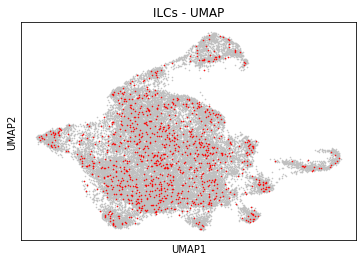

In [22]:
frame1 = plt.scatter(UMAP[:,0], UMAP[:,1], s=0.3, c = "silver")
frame1 = plt.scatter(UMAP_landmark[:,0], UMAP_landmark[:,1], s=0.3, c = "red")
plt.title('ILCs - UMAP')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

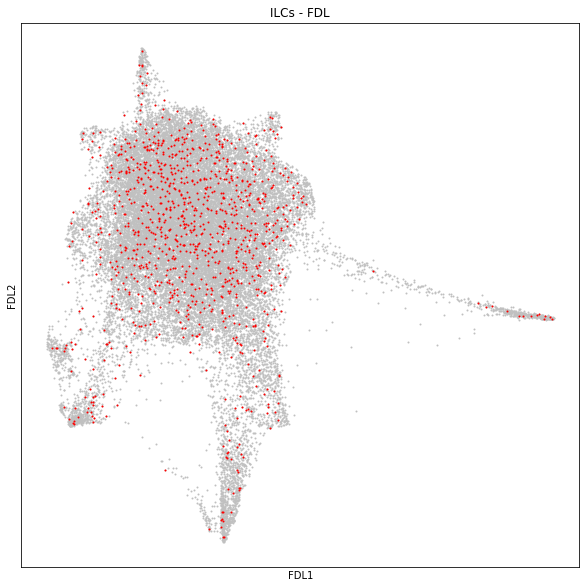

In [23]:
plt.figure(figsize=(10, 10))
frame1 = plt.scatter(Diff[:,0], Diff[:,1], s=1, c = "silver")
frame1 = plt.scatter(Diff_landmark[:,0], Diff_landmark[:,1], s=1, c = "red")
plt.title('ILCs - FDL')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

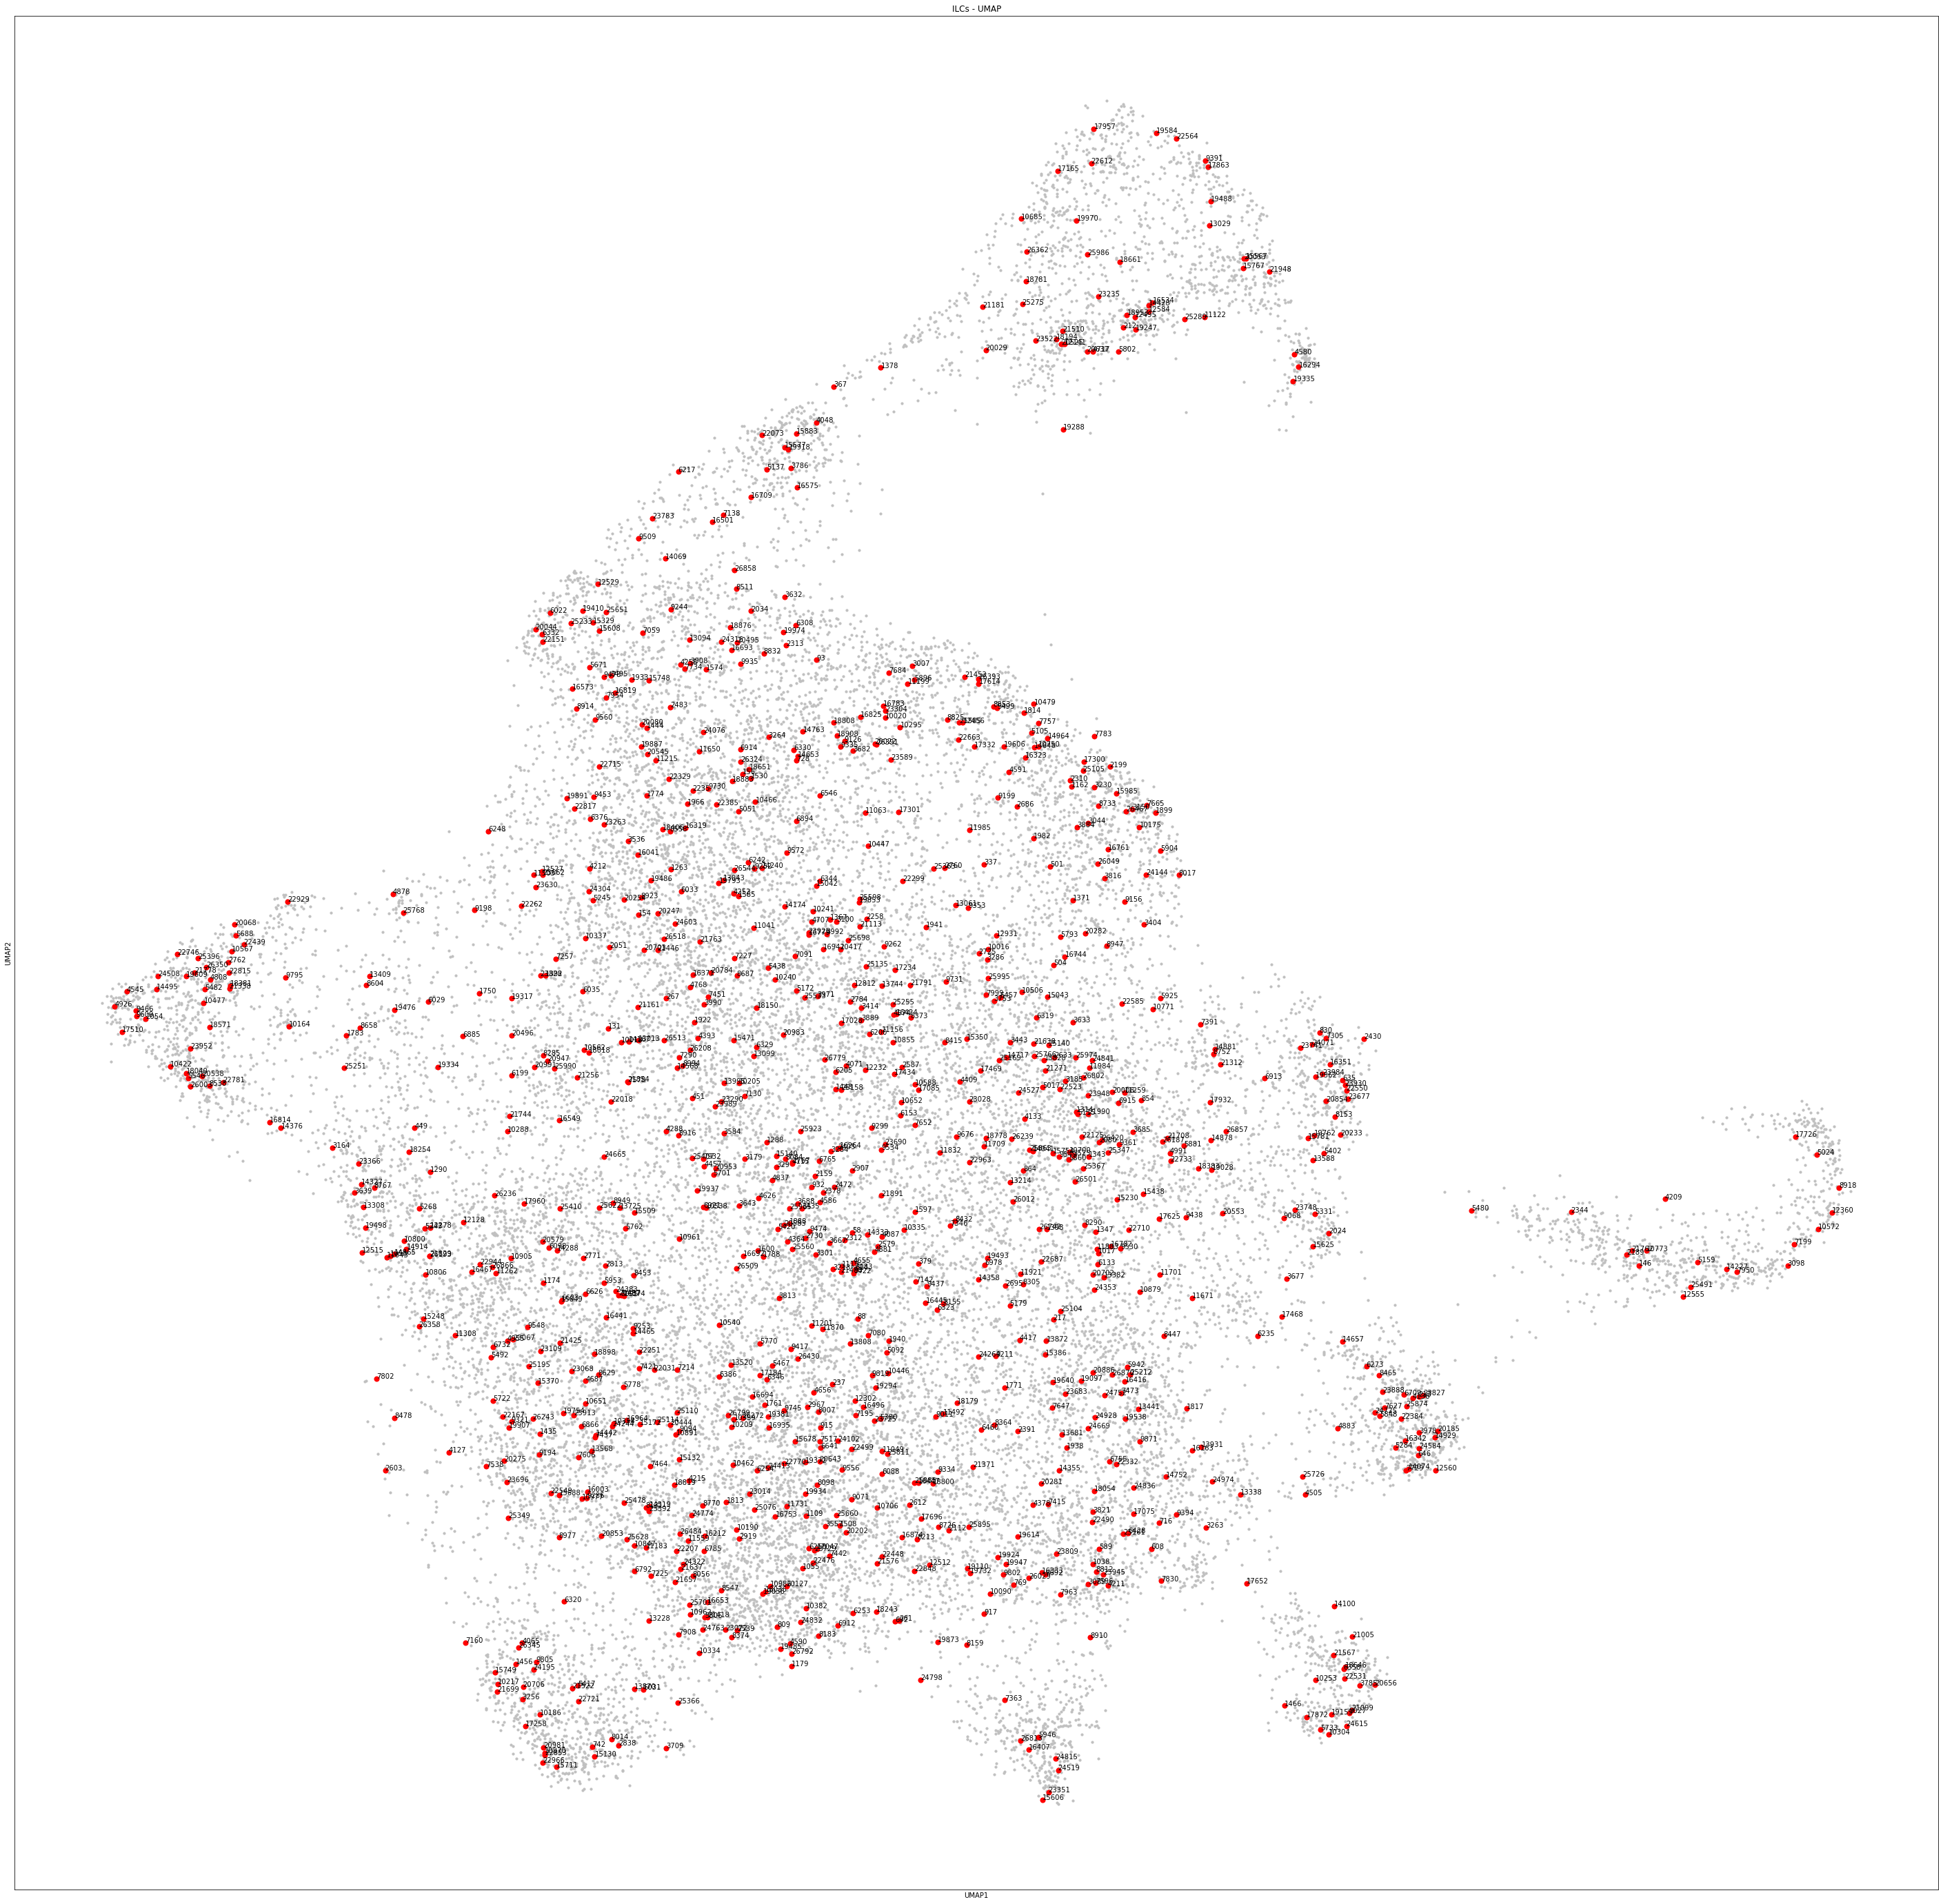

In [24]:
plt.figure(figsize=(50, 50))
frame1 = plt.scatter(UMAP[:,0], UMAP[:,1], s=10, c = "silver")
frame1 = plt.scatter(UMAP_landmark[:,0], UMAP_landmark[:,1], s=50, c = "red")
plt.title('ILCs - UMAP')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')

for count, value in enumerate(landmarks):
    plt.annotate(value, (UMAP_landmark[count,0], UMAP_landmark[count,1]))
    
plt.show()

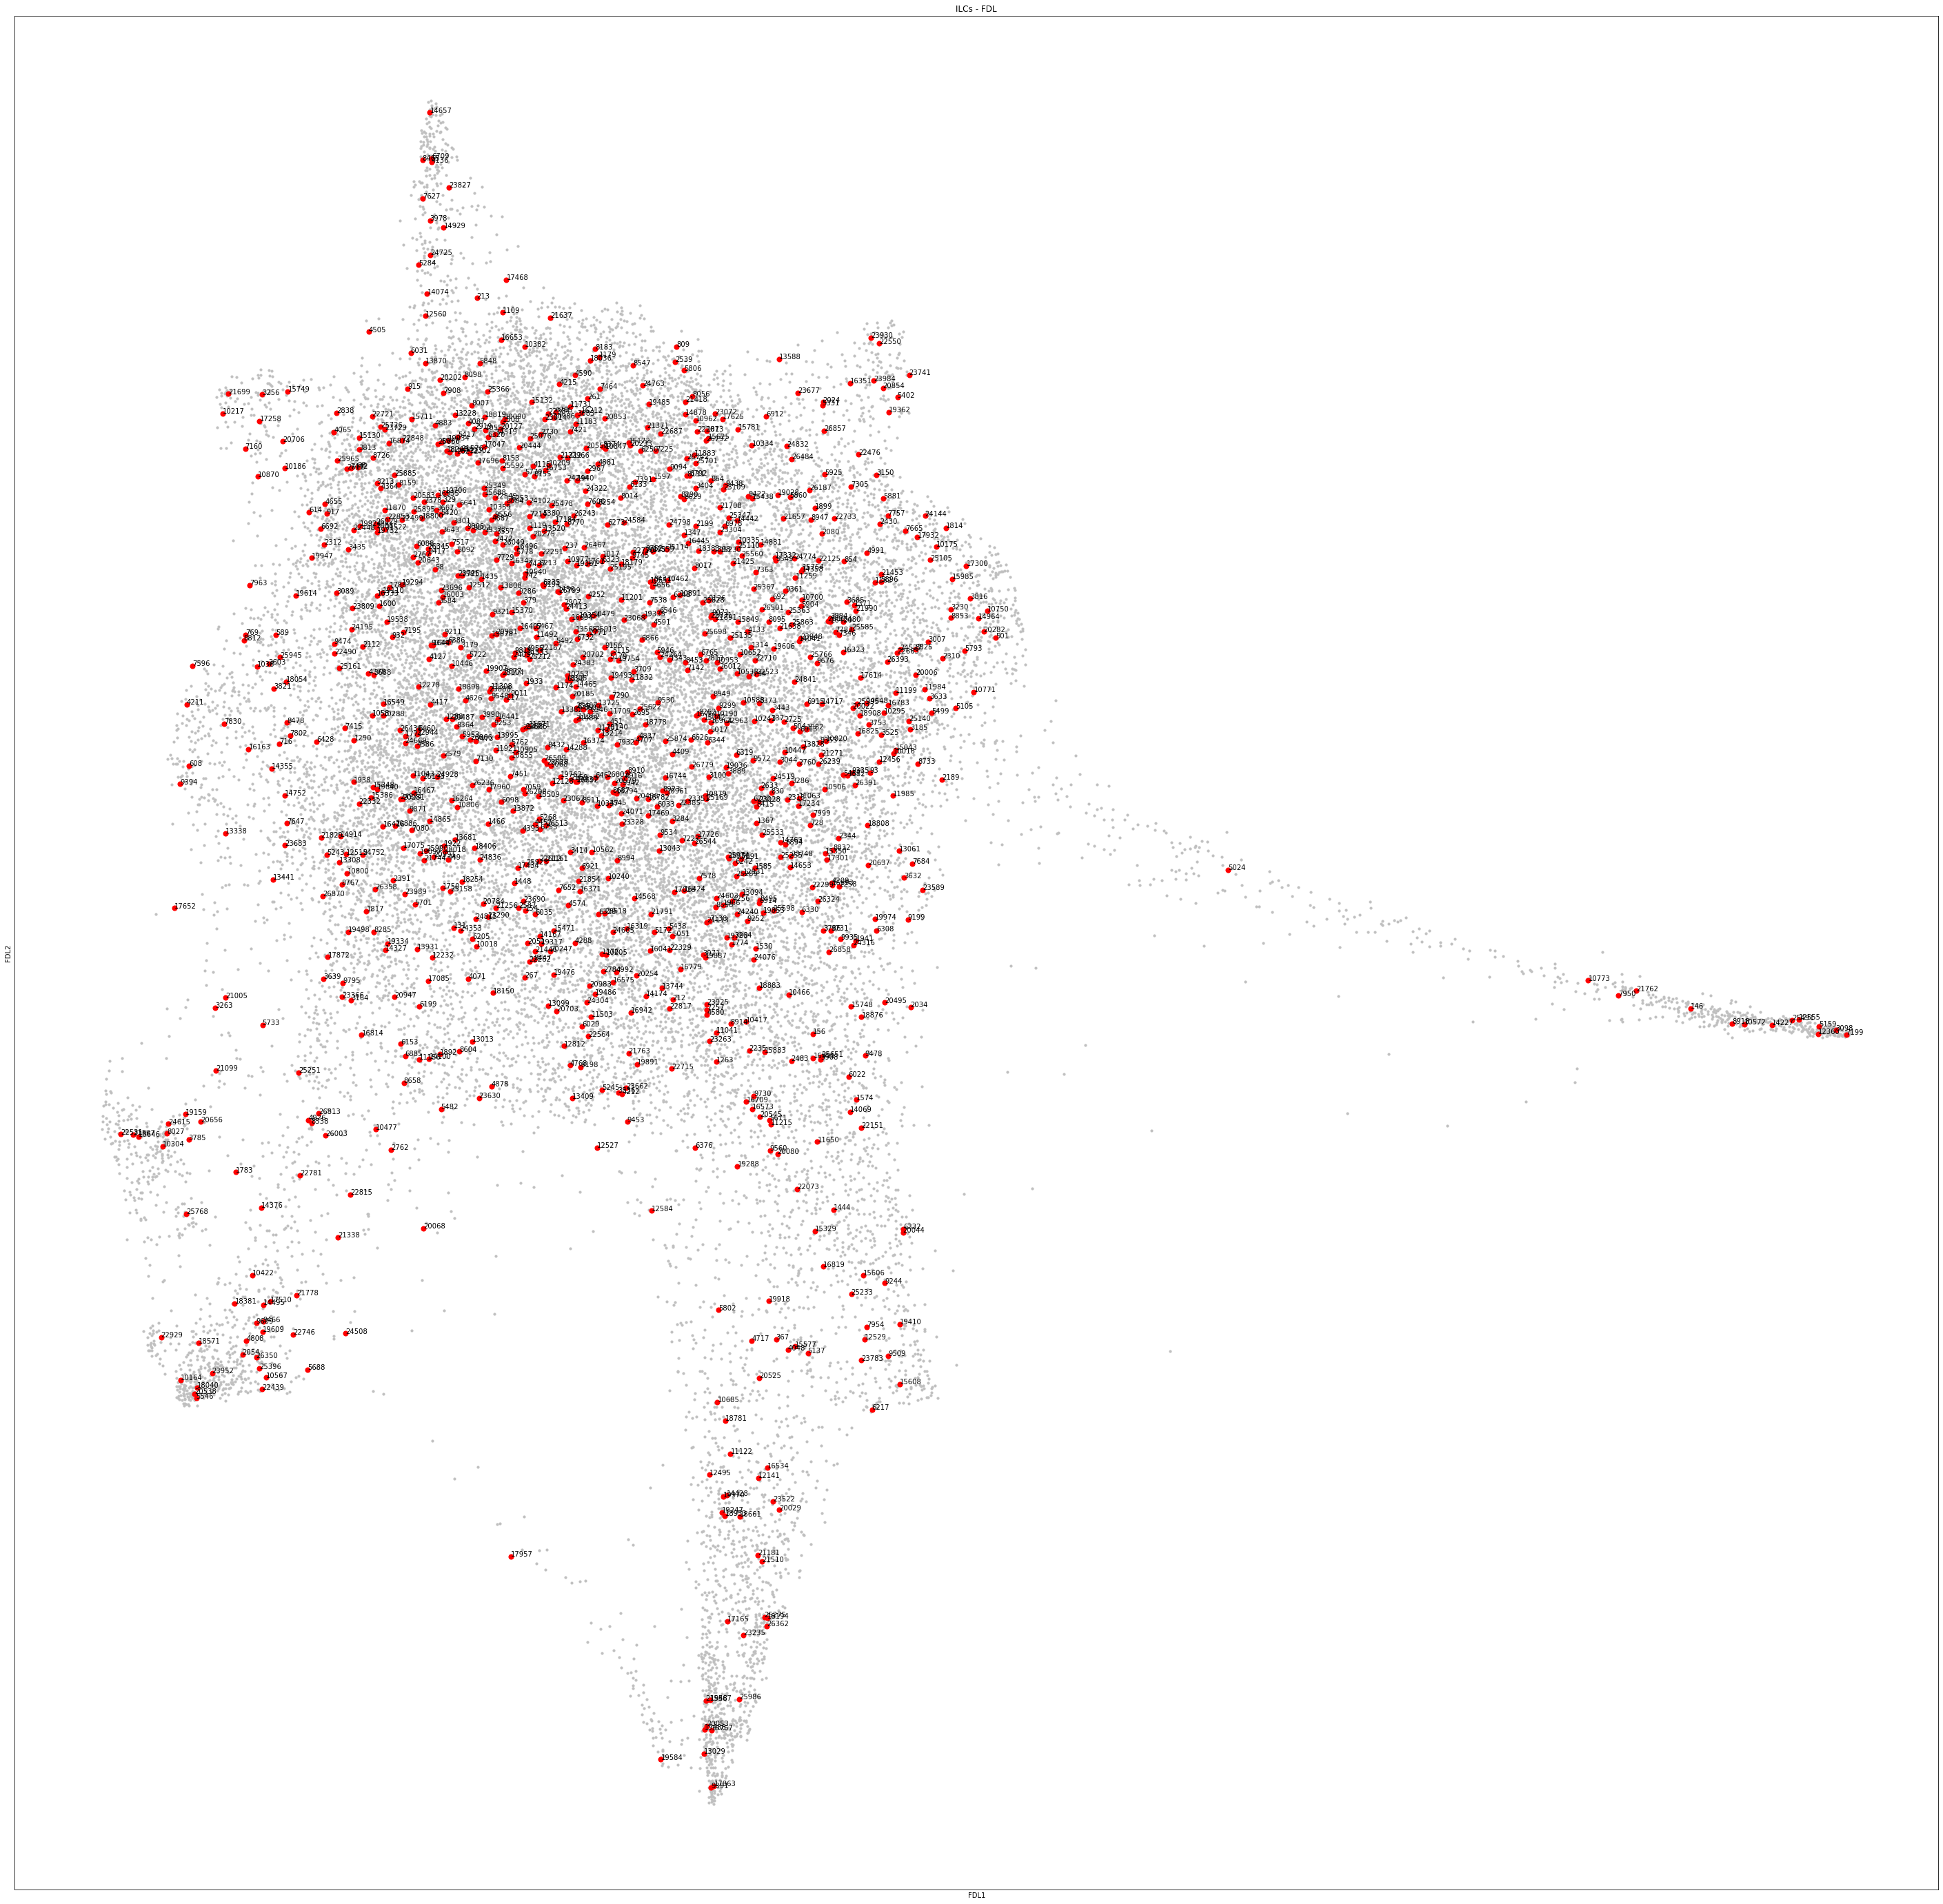

In [25]:
plt.figure(figsize=(50, 50))
frame1 = plt.scatter(Diff[:,0], Diff[:,1], s=10, c = "silver")
frame1 = plt.scatter(Diff_landmark[:,0], Diff_landmark[:,1], s=50, c = "red")
plt.title('ILCs - FDL')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')

for count, value in enumerate(landmarks):
    plt.annotate(value, (Diff_landmark[count,0], Diff_landmark[count,1]))
    
plt.show()

## Persistence Diagrams

c:\users\hmkri\desktop\riesenfeld pearson\lib\site-packages\ripser\ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


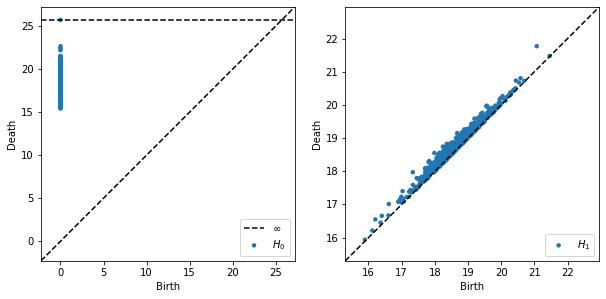

In [26]:
dgms = ripser(data_landmark, maxdim=1)['dgms']

plt.figure(figsize=(10, 5))
plot_diagrams(dgms, plot_only=[0], ax=plt.subplot(121))
plot_diagrams(dgms, plot_only=[1], ax=plt.subplot(122))

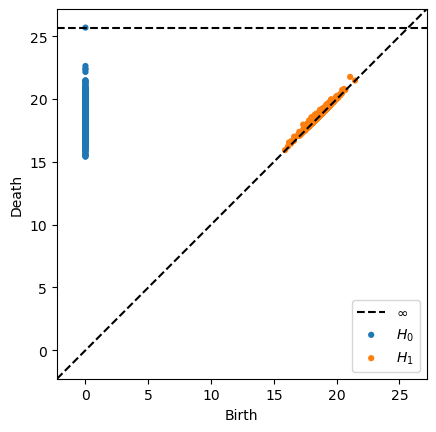

In [27]:
plot_diagrams(dgms, show=True)

## Eigen plots

In [28]:
from manifold_utils.mSVD import eigen_plot, eigen_calc_from_dist_mat, eps_projection, eigen_plot_numPoints, eigen_calc_from_dist_mat_withNumPoints
from manifold_utils.iga import chakraborty_express, iga

  0%|                                                                                         | 0/1075 [00:00<?, ?it/s]

14376


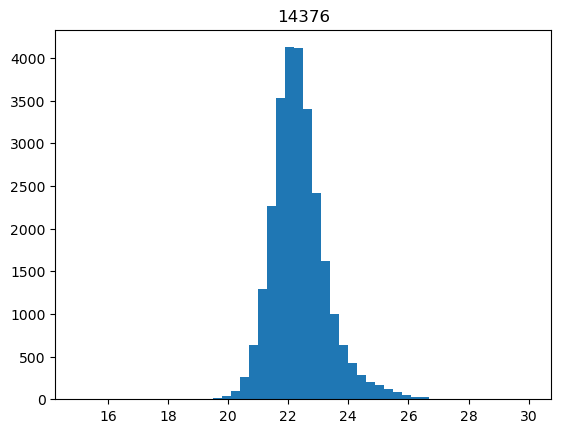

  0%|                                                                                 | 1/1075 [00:00<02:18,  7.75it/s]

4127


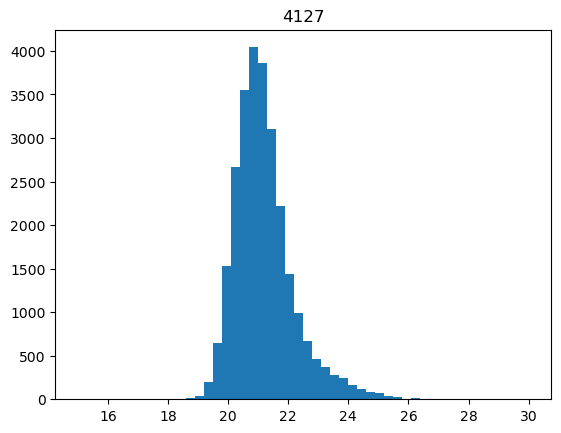

  0%|▏                                                                                | 2/1075 [00:00<02:19,  7.70it/s]

11985


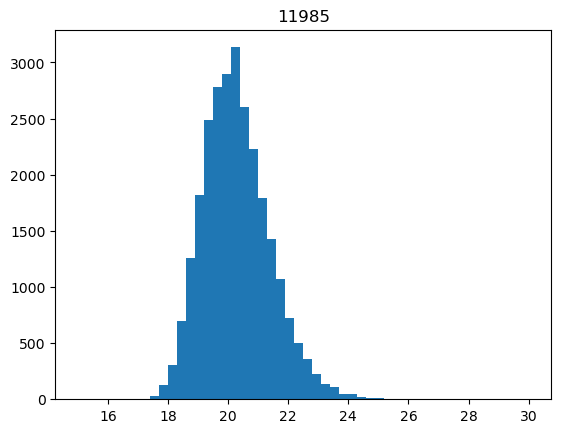

  0%|▏                                                                                | 3/1075 [00:00<02:17,  7.78it/s]

3044


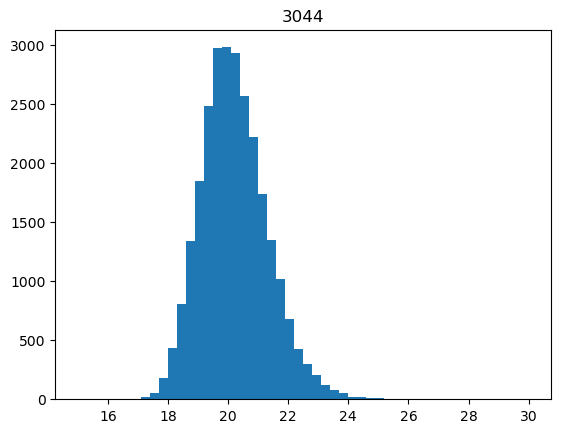

  0%|▎                                                                                | 4/1075 [00:00<02:17,  7.81it/s]

3098


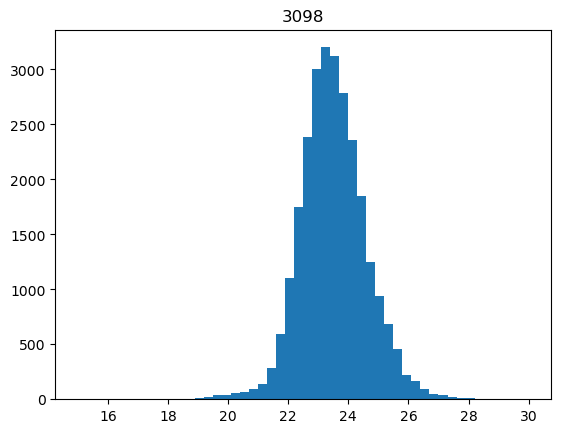

  0%|▍                                                                                | 5/1075 [00:00<02:16,  7.83it/s]

20583


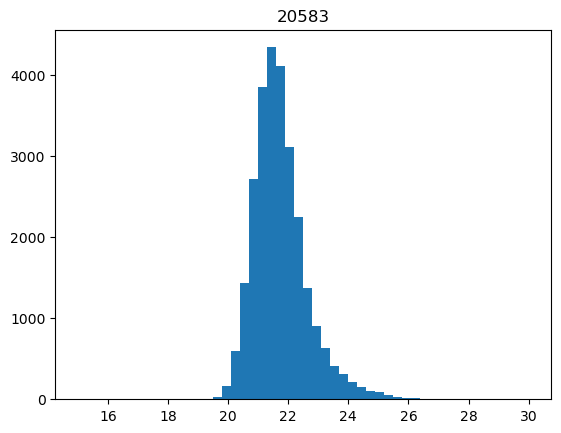

  1%|▍                                                                                | 6/1075 [00:00<02:42,  6.59it/s]

14878


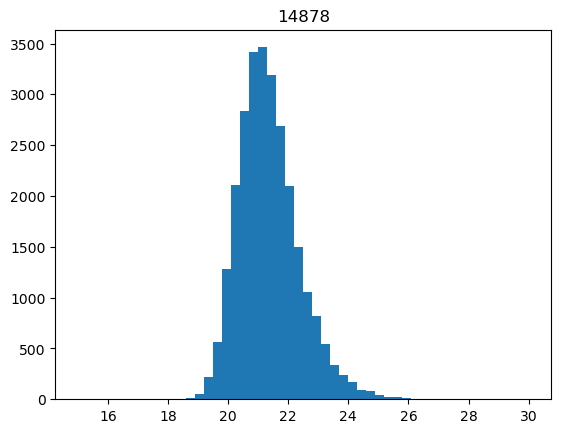

  1%|▌                                                                                | 7/1075 [00:00<02:33,  6.95it/s]

14428


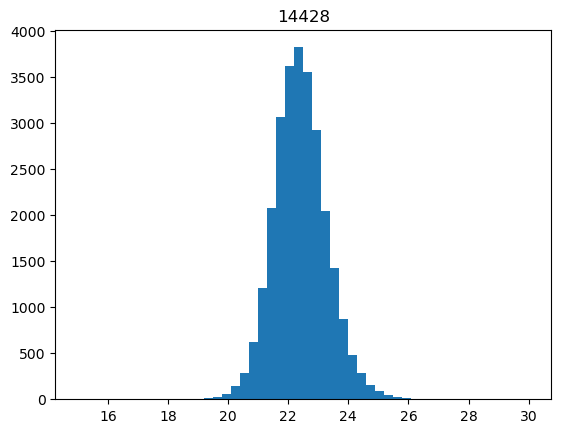

  1%|▌                                                                                | 8/1075 [00:01<02:27,  7.22it/s]

2024


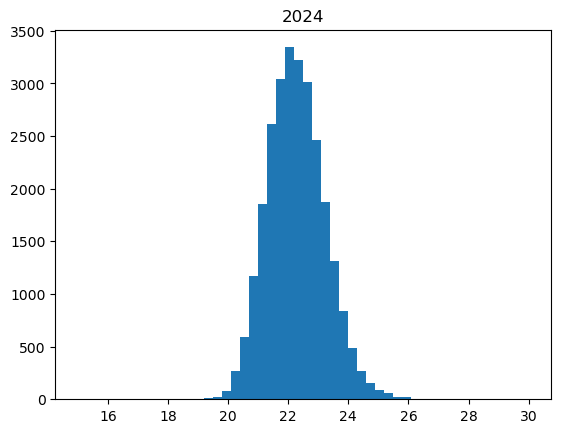

  1%|▋                                                                                | 9/1075 [00:01<02:23,  7.41it/s]

15625


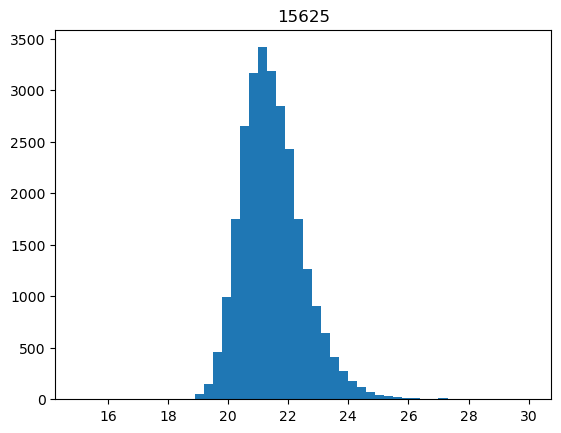

  1%|▋                                                                               | 10/1075 [00:01<02:19,  7.61it/s]

6921


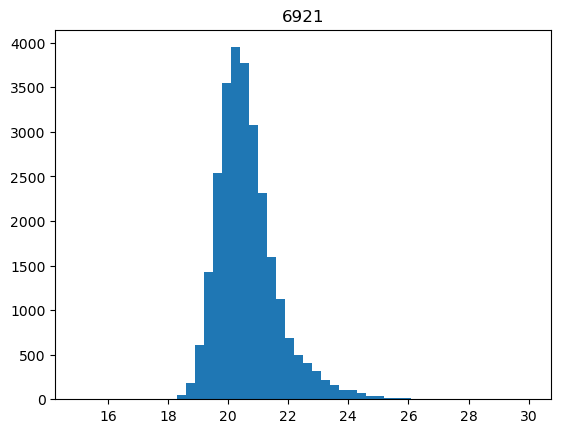

  1%|▊                                                                               | 11/1075 [00:01<02:18,  7.70it/s]

10335


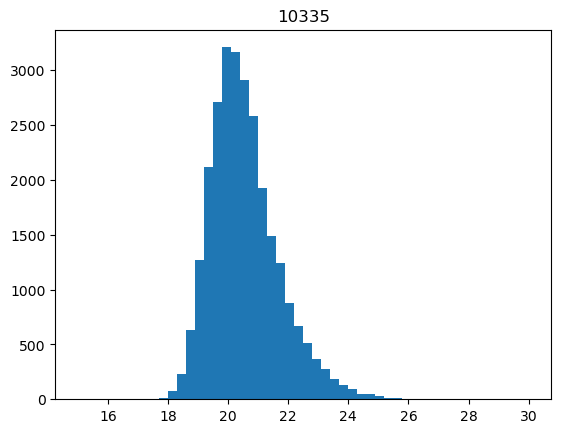

  1%|▉                                                                               | 12/1075 [00:01<02:15,  7.83it/s]

5380


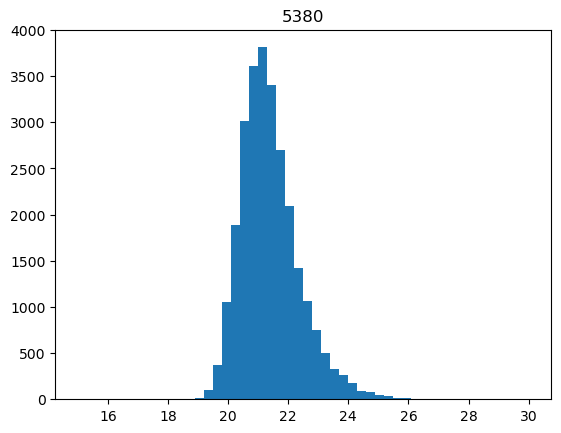

  1%|▉                                                                               | 13/1075 [00:01<02:14,  7.88it/s]

1892


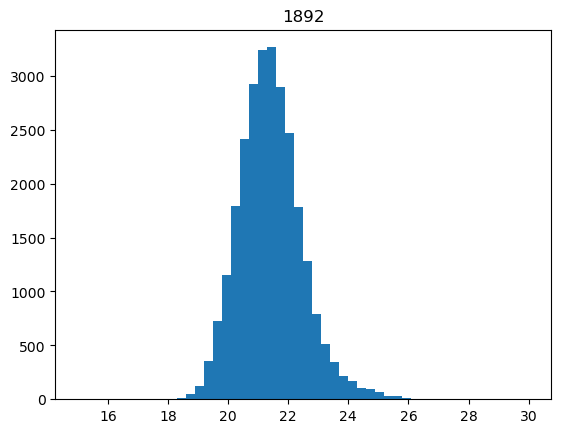

  1%|█                                                                               | 14/1075 [00:01<02:13,  7.95it/s]

26509


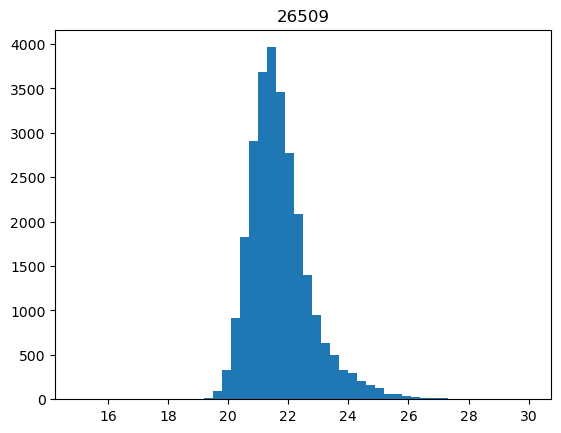

  1%|█                                                                               | 15/1075 [00:01<02:13,  7.95it/s]

23741


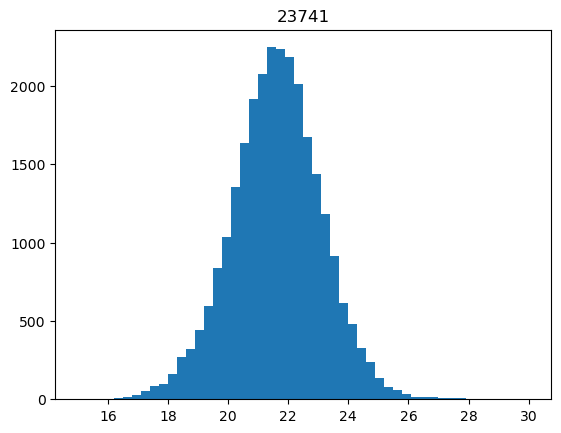

  1%|█▏                                                                              | 16/1075 [00:02<02:11,  8.04it/s]

12560


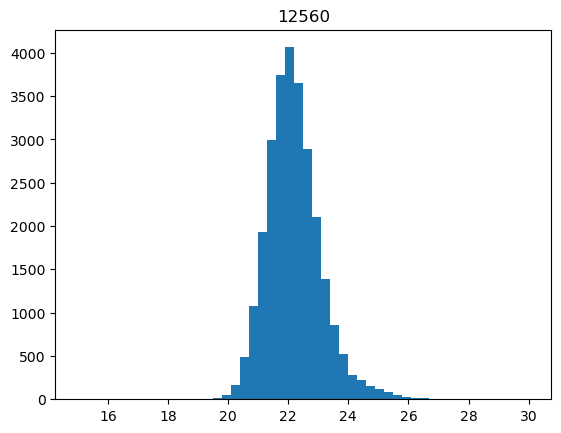

  2%|█▎                                                                              | 17/1075 [00:02<02:40,  6.60it/s]

24519


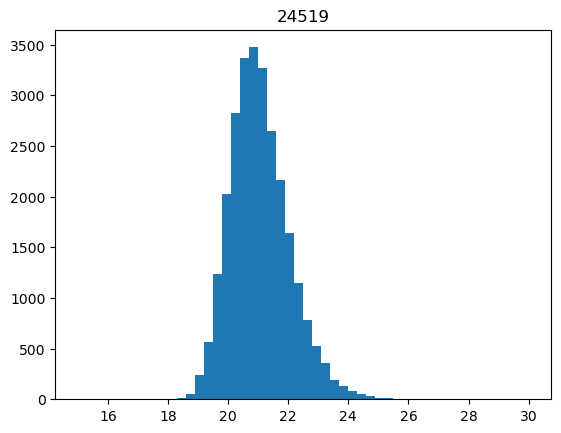

  2%|█▎                                                                              | 18/1075 [00:02<02:31,  6.98it/s]

10382


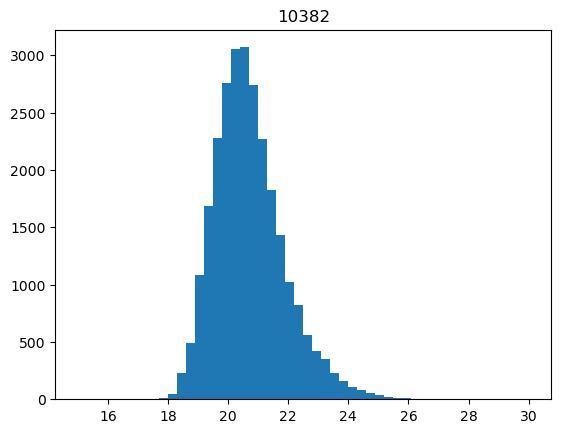

  2%|█▍                                                                              | 19/1075 [00:02<02:24,  7.29it/s]

22733


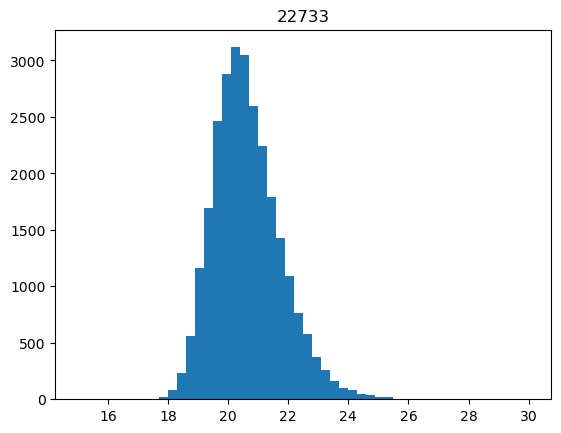

  2%|█▍                                                                              | 20/1075 [00:02<02:20,  7.49it/s]

367


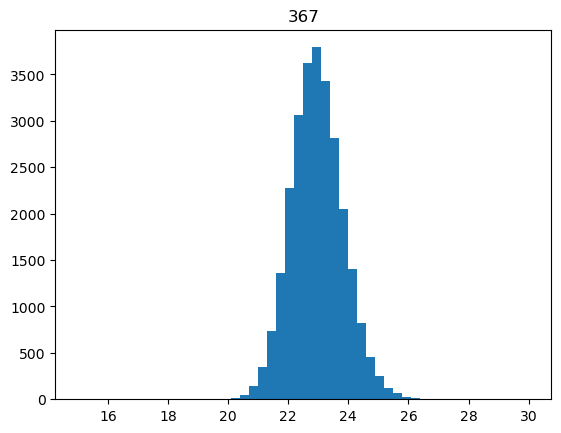

  2%|█▌                                                                              | 21/1075 [00:02<02:19,  7.58it/s]

25104


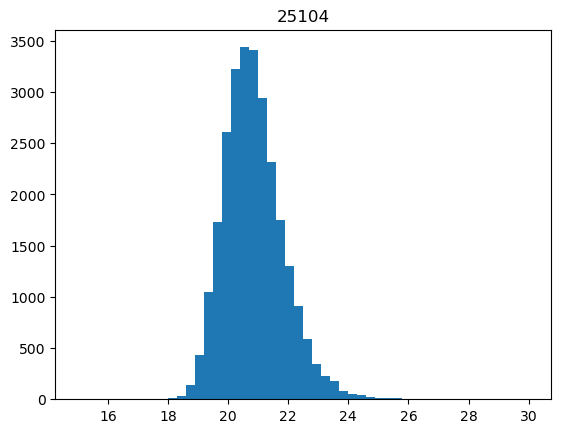

  2%|█▋                                                                              | 22/1075 [00:02<02:17,  7.68it/s]

24353


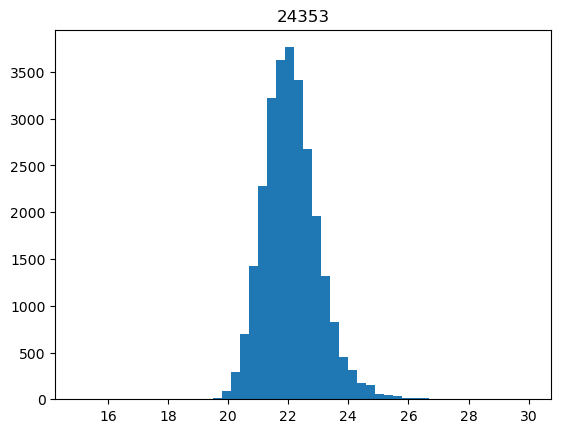

  2%|█▋                                                                              | 23/1075 [00:03<02:15,  7.78it/s]

5017


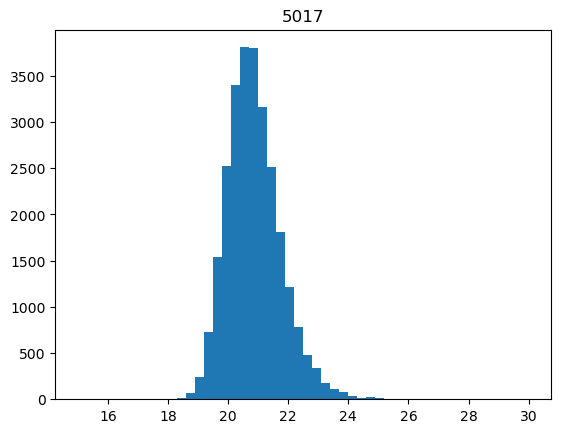

  2%|█▊                                                                              | 24/1075 [00:03<02:15,  7.75it/s]

22385


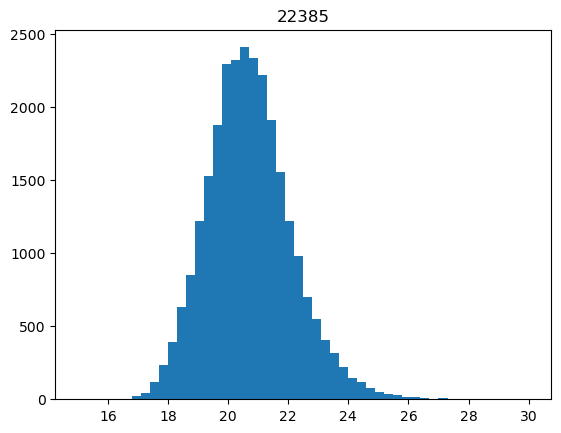

  2%|█▊                                                                              | 25/1075 [00:03<02:13,  7.84it/s]

15248


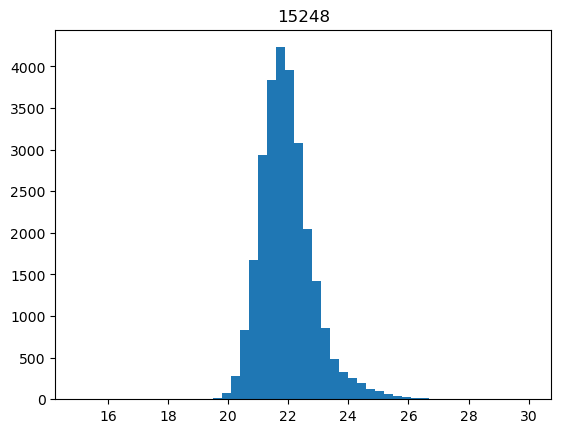

  2%|█▉                                                                              | 26/1075 [00:03<02:13,  7.83it/s]

769


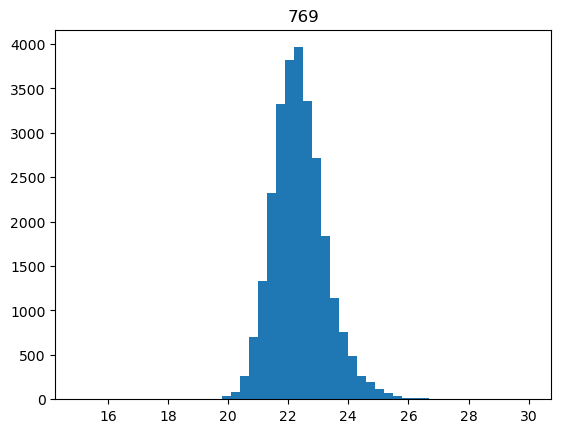

  3%|██                                                                              | 27/1075 [00:03<02:13,  7.84it/s]

1119


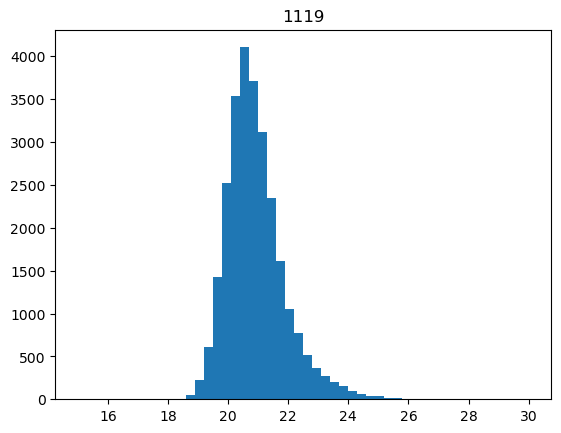

  3%|██                                                                              | 28/1075 [00:03<02:38,  6.59it/s]

25212


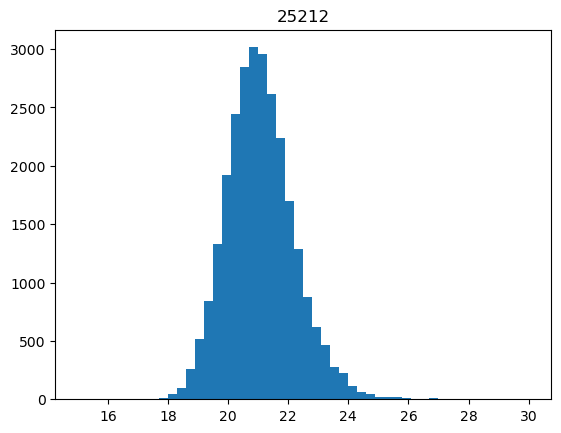

  3%|██▏                                                                             | 29/1075 [00:03<02:29,  7.00it/s]

17234


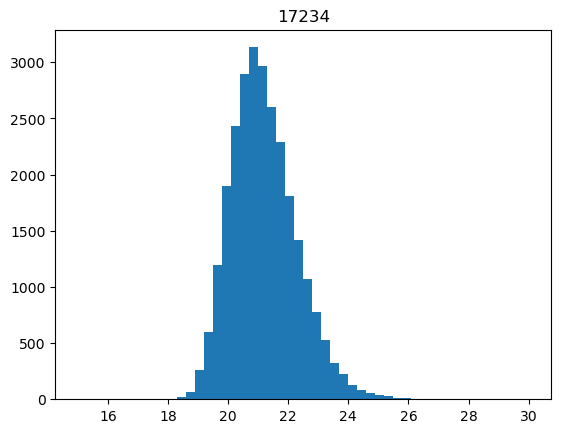

  3%|██▏                                                                             | 30/1075 [00:04<02:23,  7.31it/s]

21446


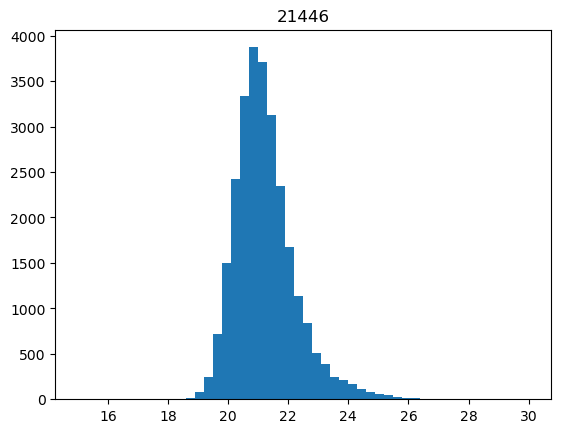

  3%|██▎                                                                             | 31/1075 [00:04<02:19,  7.47it/s]

18194


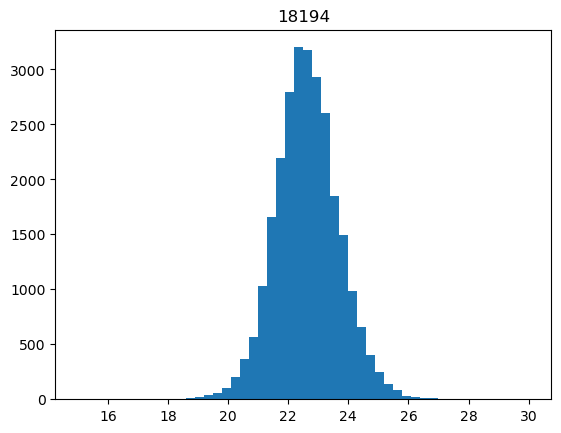

  3%|██▍                                                                             | 32/1075 [00:04<02:15,  7.67it/s]

25628


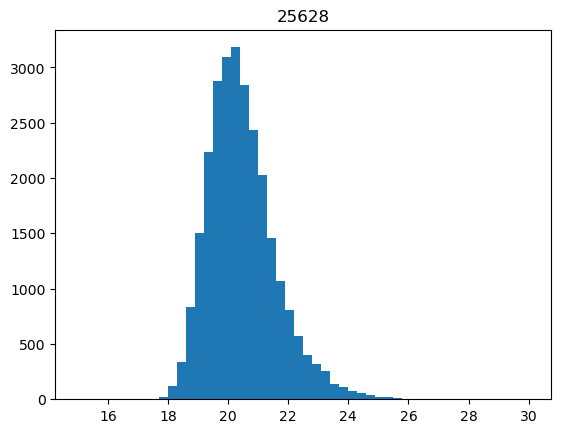

  3%|██▍                                                                             | 33/1075 [00:04<02:14,  7.77it/s]

20202


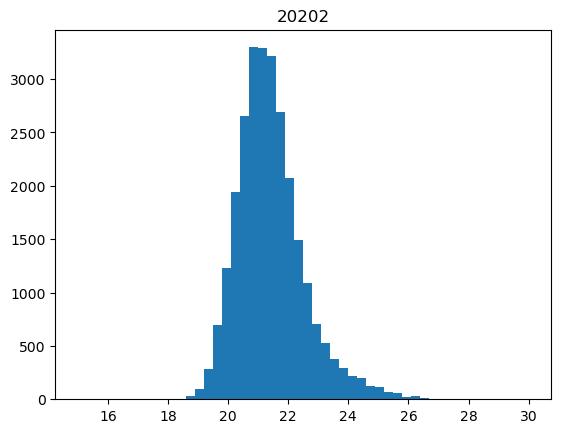

  3%|██▌                                                                             | 34/1075 [00:04<02:13,  7.82it/s]

22585


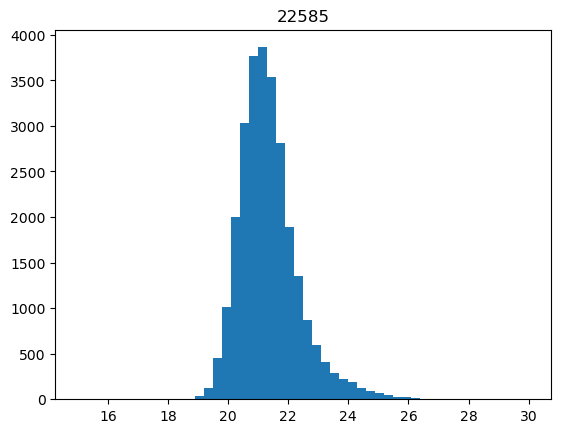

  3%|██▌                                                                             | 35/1075 [00:04<02:12,  7.83it/s]

25895


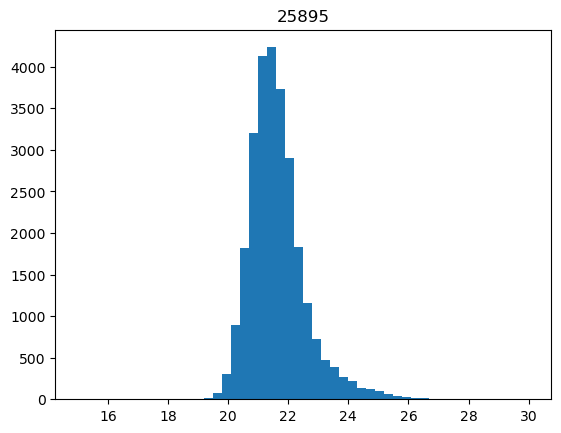

  3%|██▋                                                                             | 36/1075 [00:04<02:11,  7.88it/s]

5896


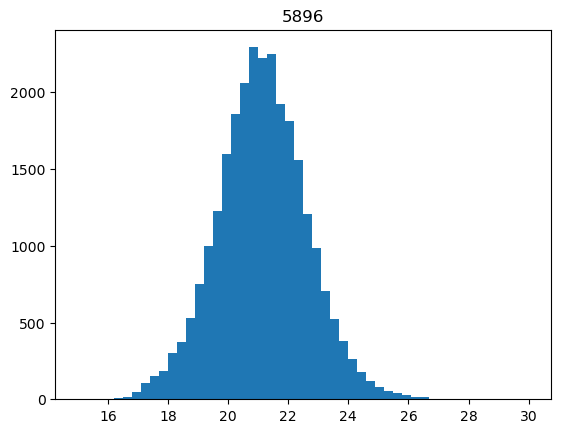

  3%|██▊                                                                             | 37/1075 [00:04<02:09,  8.03it/s]

25701


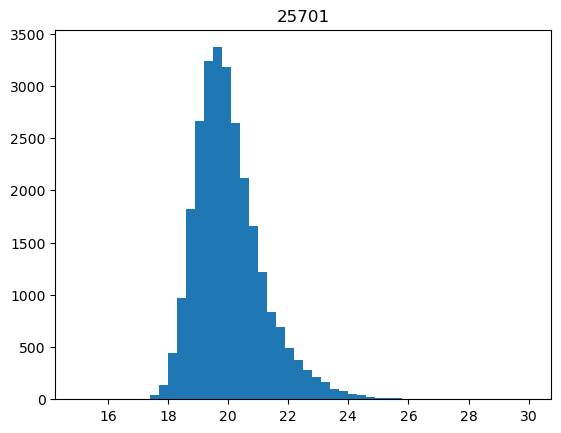

  4%|██▊                                                                             | 38/1075 [00:05<02:09,  8.00it/s]

2430


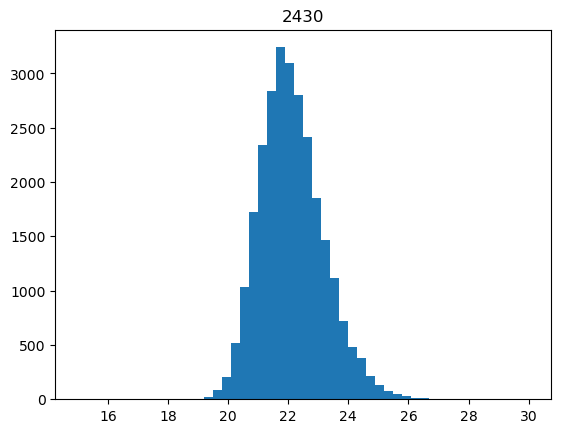

  4%|██▉                                                                             | 39/1075 [00:05<02:34,  6.71it/s]

16783


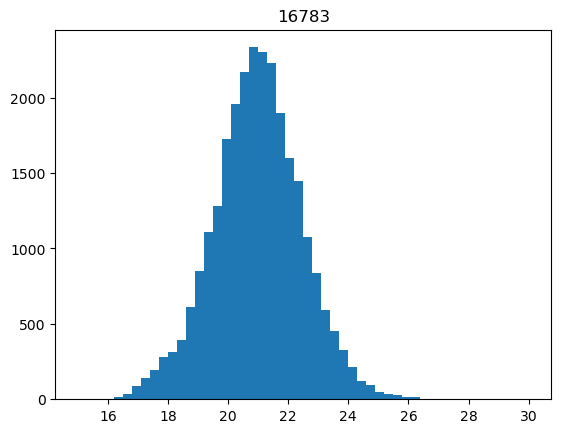

  4%|██▉                                                                             | 40/1075 [00:05<02:24,  7.14it/s]

6460


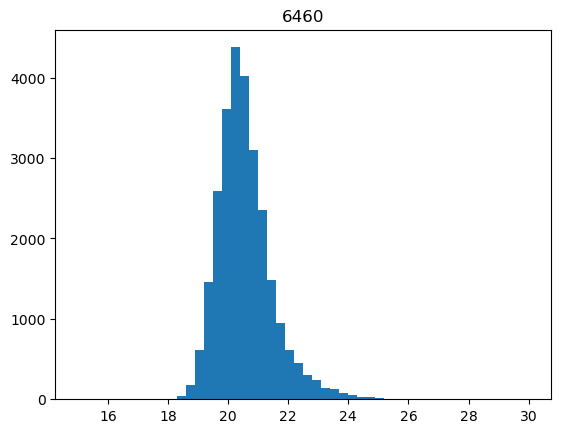

  4%|███                                                                             | 41/1075 [00:05<02:17,  7.50it/s]

2312


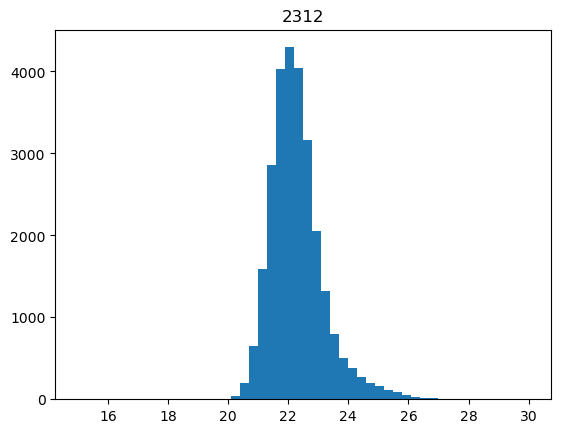

  4%|███▏                                                                            | 42/1075 [00:05<02:13,  7.76it/s]

3688


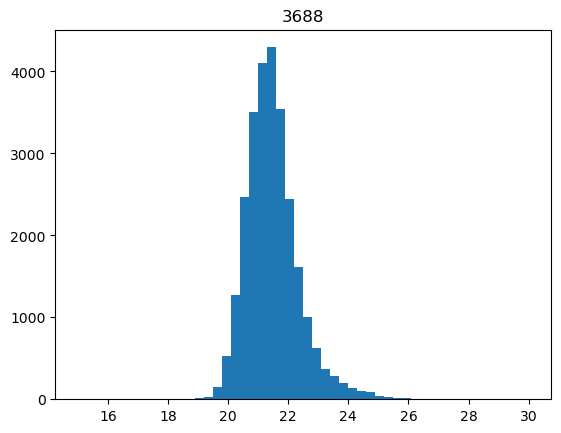

  4%|███▏                                                                            | 43/1075 [00:05<02:11,  7.87it/s]

3435


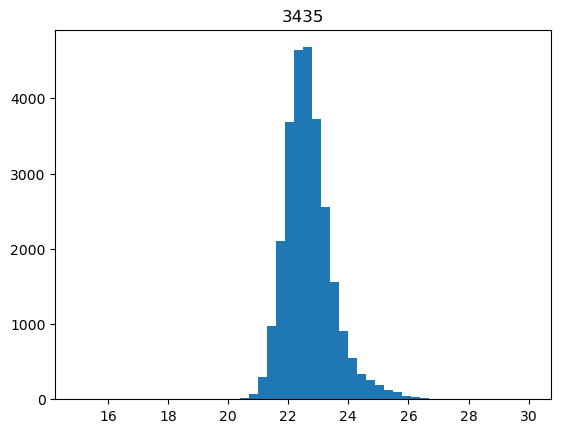

  4%|███▎                                                                            | 44/1075 [00:05<02:09,  7.95it/s]

8916


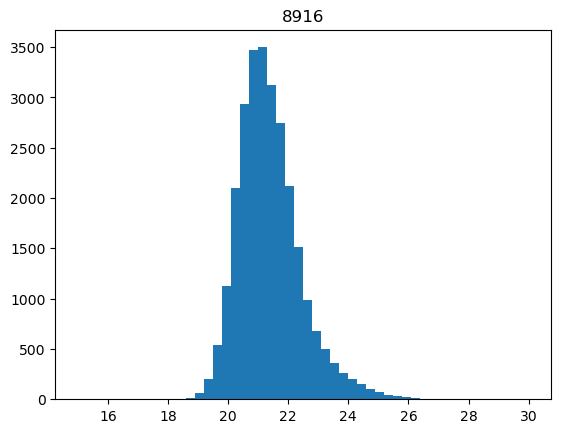

  4%|███▎                                                                            | 45/1075 [00:05<02:09,  7.94it/s]

17726


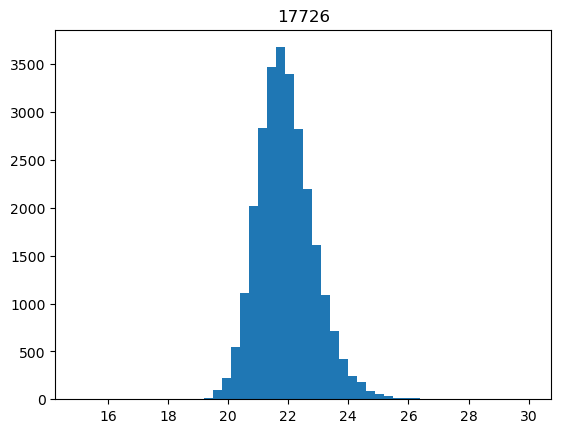

  4%|███▍                                                                            | 46/1075 [00:06<02:09,  7.96it/s]

5243


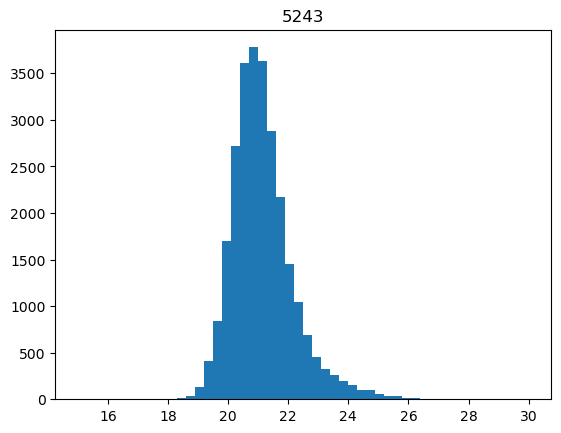

  4%|███▍                                                                            | 47/1075 [00:06<02:08,  7.97it/s]

8832


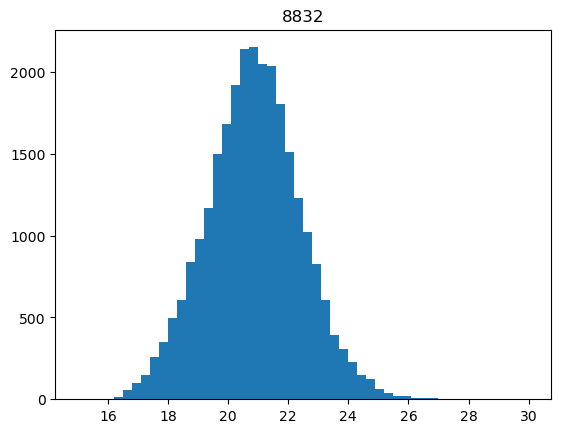

  4%|███▌                                                                            | 48/1075 [00:06<02:06,  8.10it/s]

6546


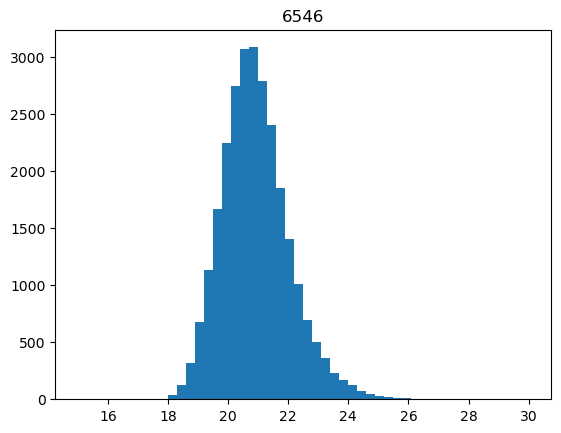

  5%|███▋                                                                            | 49/1075 [00:06<02:05,  8.14it/s]

6033


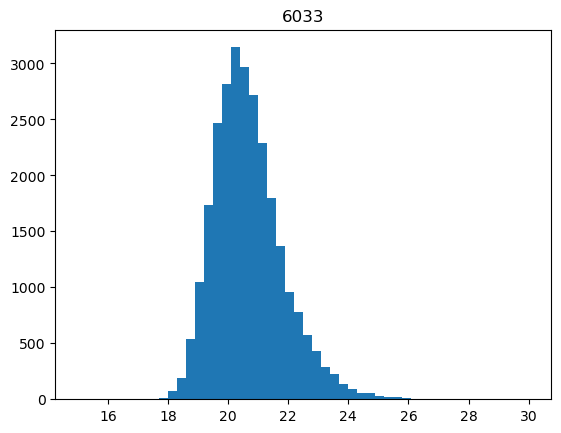

  5%|███▋                                                                            | 50/1075 [00:06<02:30,  6.80it/s]

22966


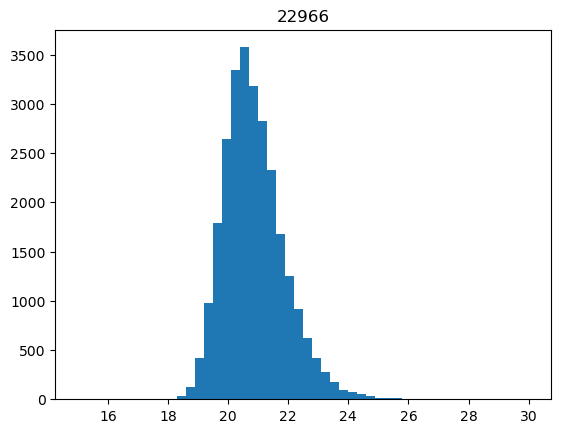

  5%|███▊                                                                            | 51/1075 [00:06<02:23,  7.15it/s]

10164


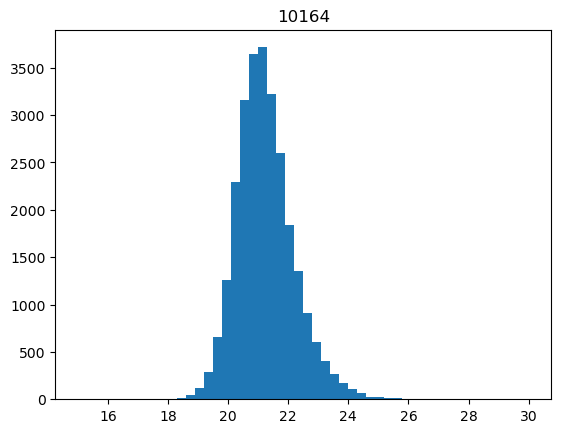

  5%|███▊                                                                            | 52/1075 [00:06<02:18,  7.38it/s]

18800


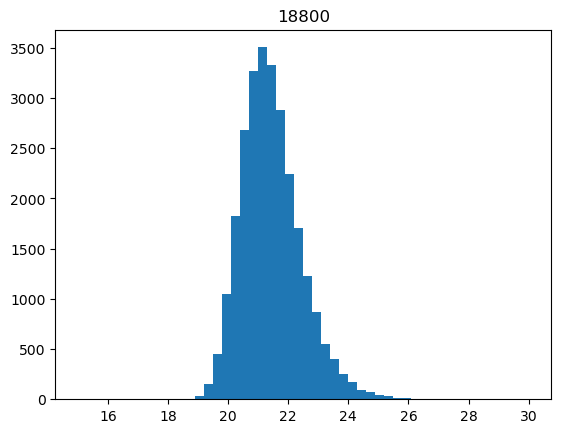

  5%|███▉                                                                            | 53/1075 [00:07<02:15,  7.54it/s]

14964


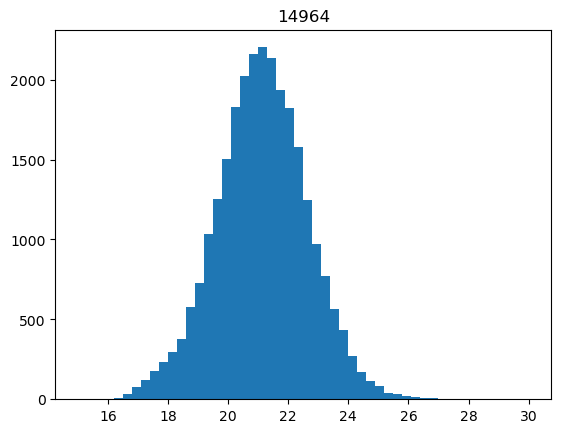

  5%|████                                                                            | 54/1075 [00:07<02:11,  7.76it/s]

3753


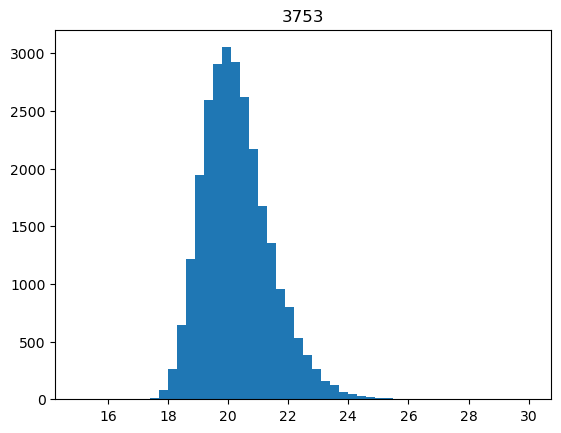

  5%|████                                                                            | 55/1075 [00:07<02:09,  7.87it/s]

15849


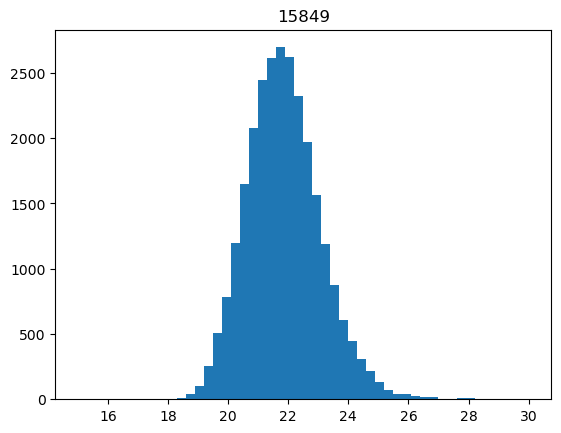

  5%|████▏                                                                           | 56/1075 [00:07<02:07,  7.96it/s]

9676


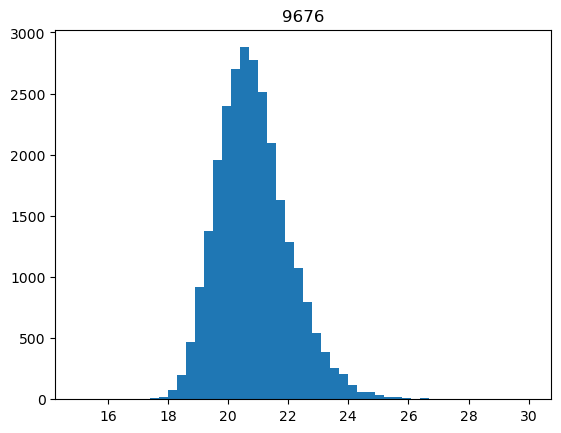

  5%|████▏                                                                           | 57/1075 [00:07<02:07,  8.01it/s]

20080


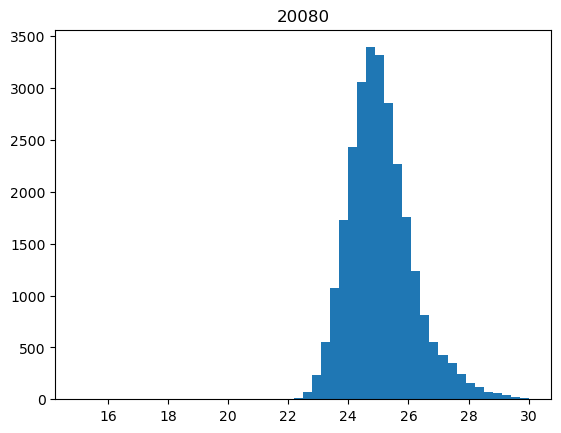

  5%|████▎                                                                           | 58/1075 [00:07<02:07,  7.99it/s]

16441


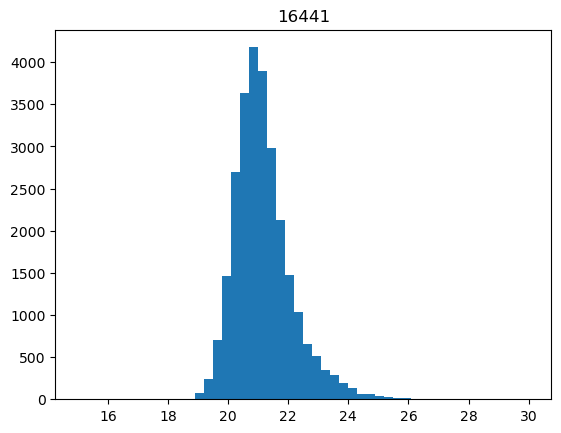

  5%|████▍                                                                           | 59/1075 [00:07<02:07,  7.95it/s]

16573


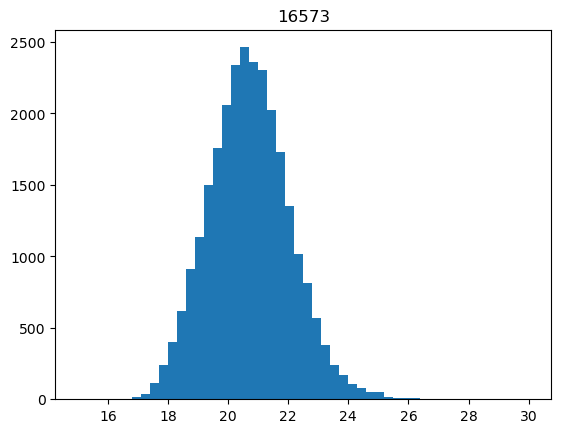

  6%|████▍                                                                           | 60/1075 [00:07<02:08,  7.93it/s]

9126


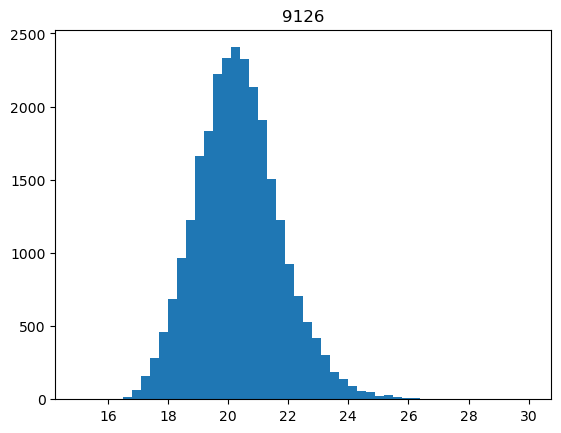

  6%|████▌                                                                           | 61/1075 [00:08<02:34,  6.56it/s]

5778


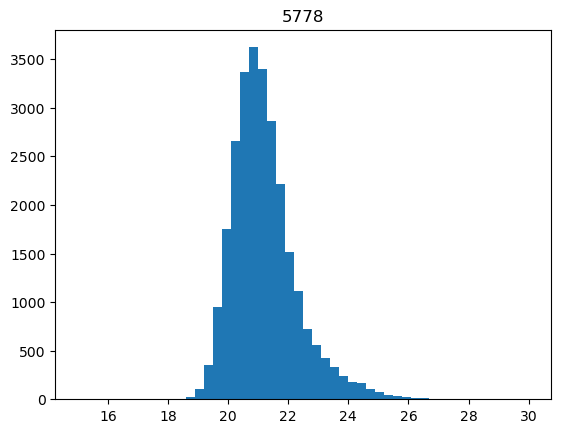

  6%|████▌                                                                           | 62/1075 [00:08<02:26,  6.93it/s]

16874


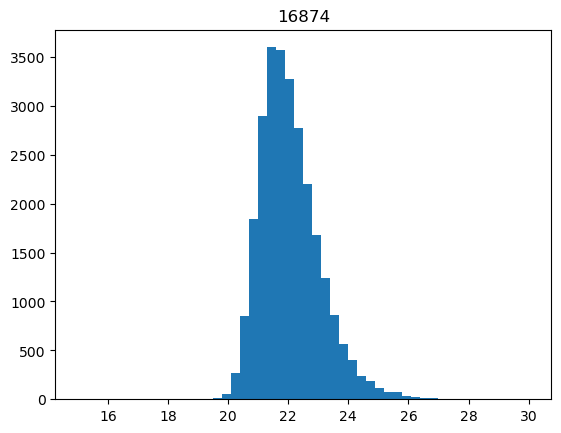

  6%|████▋                                                                           | 63/1075 [00:08<02:20,  7.19it/s]

25885


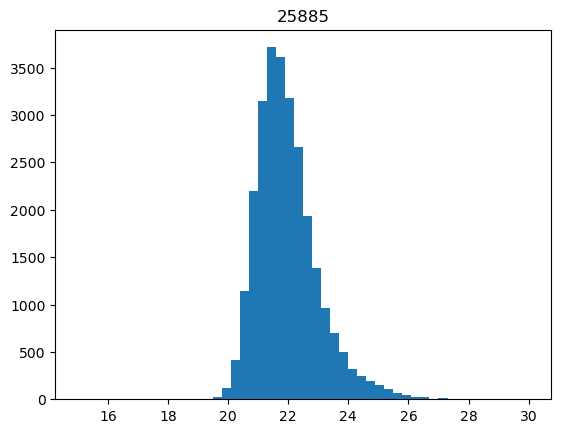

  6%|████▊                                                                           | 64/1075 [00:08<02:19,  7.27it/s]

9935


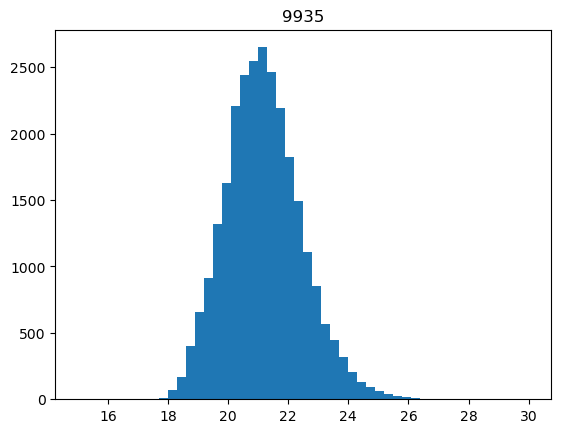

  6%|████▊                                                                           | 65/1075 [00:08<02:15,  7.46it/s]

7783


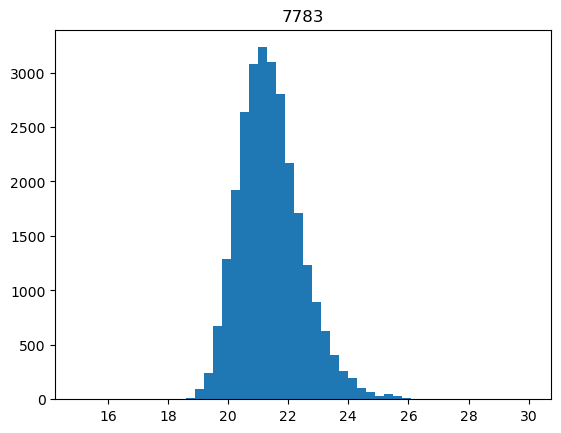

  6%|████▉                                                                           | 66/1075 [00:08<02:12,  7.59it/s]

20637


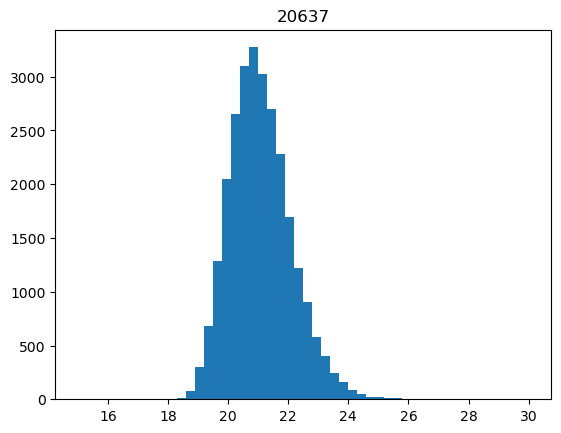

  6%|████▉                                                                           | 67/1075 [00:08<02:10,  7.71it/s]

9453


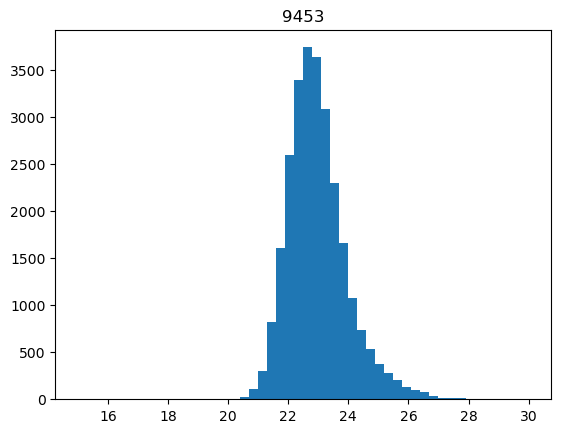

  6%|█████                                                                           | 68/1075 [00:08<02:09,  7.78it/s]

8726


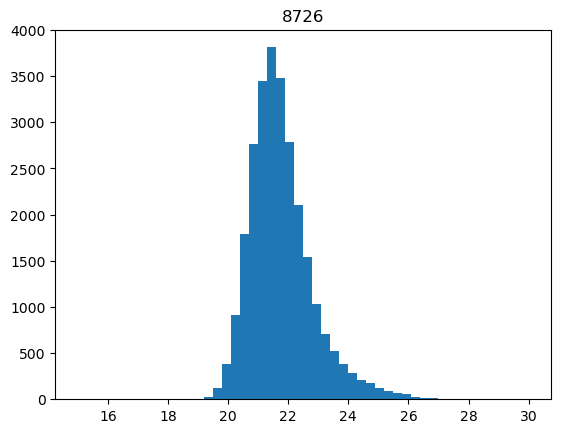

  6%|█████▏                                                                          | 69/1075 [00:09<02:08,  7.81it/s]

26779


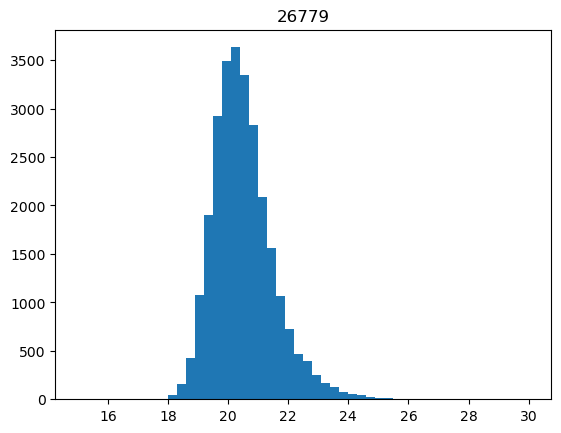

  7%|█████▏                                                                          | 70/1075 [00:09<02:07,  7.86it/s]

15748


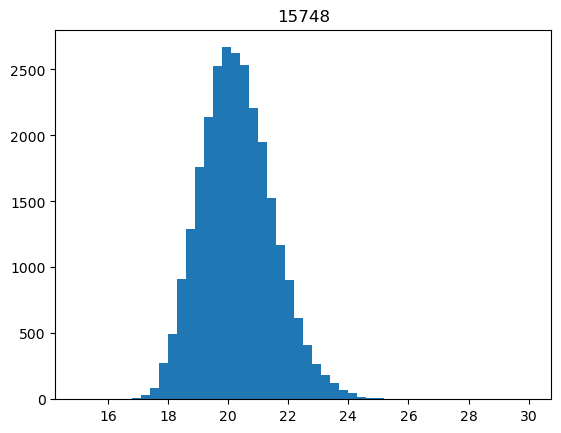

  7%|█████▎                                                                          | 71/1075 [00:09<02:06,  7.96it/s]

5722


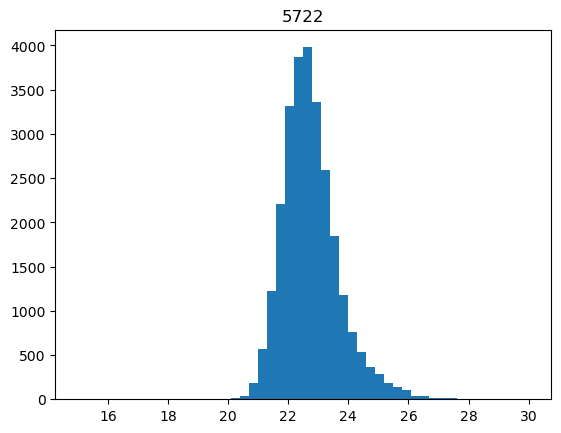

  7%|█████▎                                                                          | 72/1075 [00:09<02:30,  6.65it/s]

16653


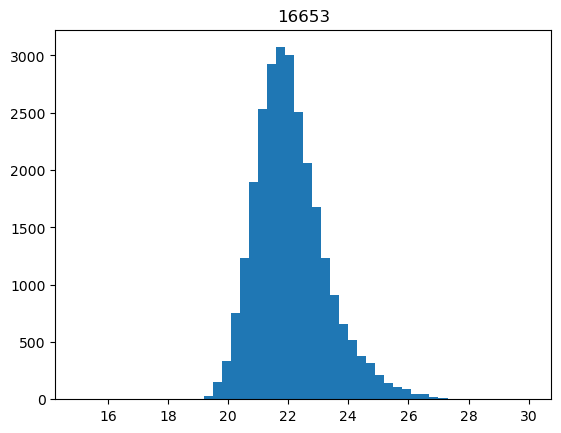

  7%|█████▍                                                                          | 73/1075 [00:09<02:22,  7.02it/s]

13870


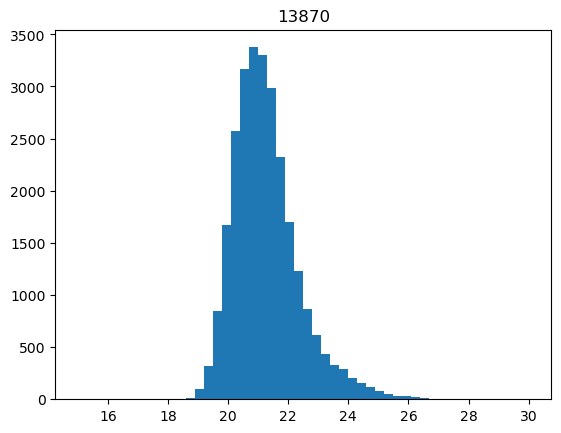

  7%|█████▌                                                                          | 74/1075 [00:09<02:17,  7.27it/s]

2695


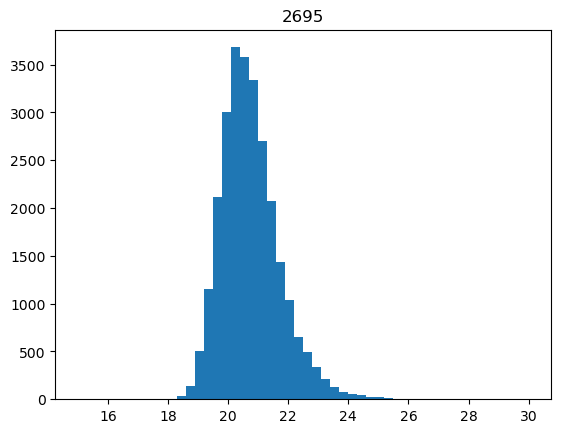

  7%|█████▌                                                                          | 75/1075 [00:09<02:14,  7.46it/s]

22746


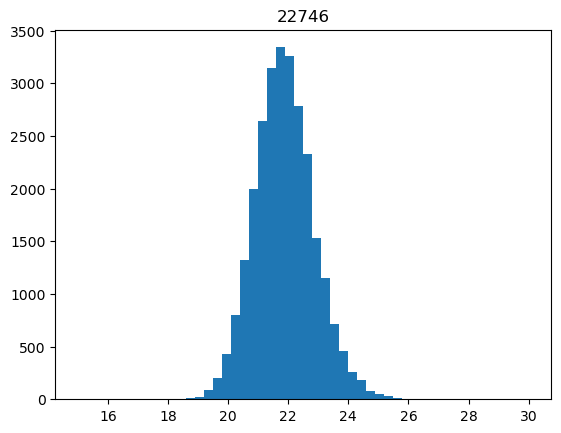

  7%|█████▋                                                                          | 76/1075 [00:10<02:12,  7.54it/s]

3100


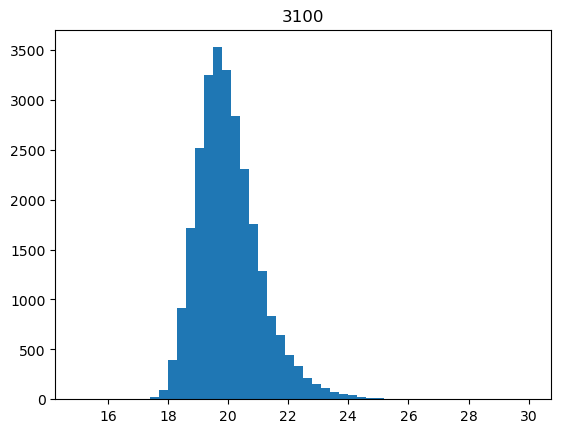

  7%|█████▋                                                                          | 77/1075 [00:10<02:11,  7.60it/s]

25990


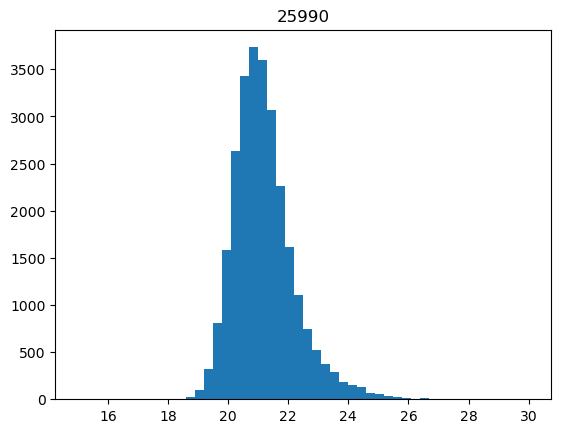

  7%|█████▊                                                                          | 78/1075 [00:10<02:10,  7.67it/s]

16424


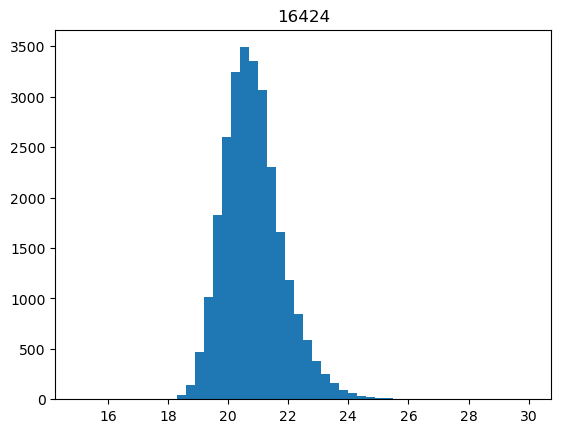

  7%|█████▉                                                                          | 79/1075 [00:10<02:08,  7.74it/s]

6320


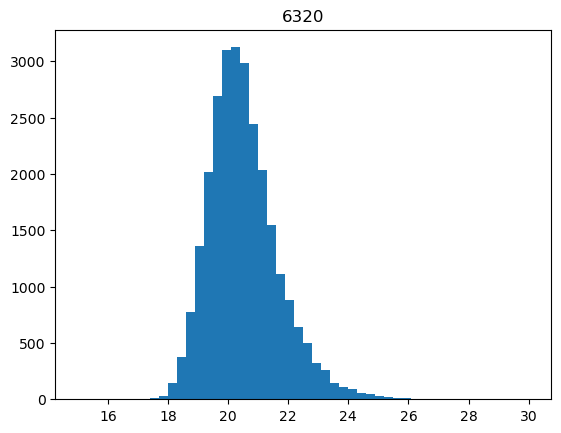

  7%|█████▉                                                                          | 80/1075 [00:10<02:06,  7.87it/s]

501


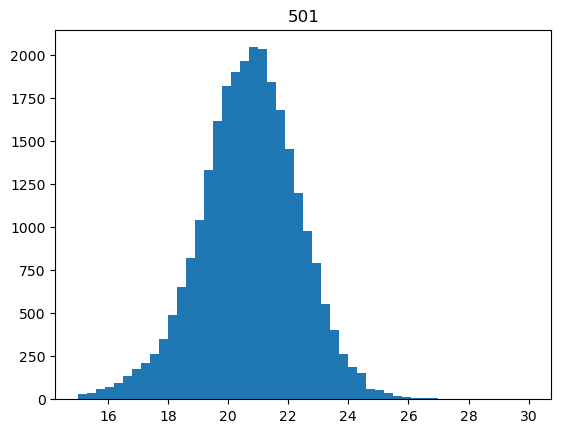

  8%|██████                                                                          | 81/1075 [00:10<02:07,  7.80it/s]

23925


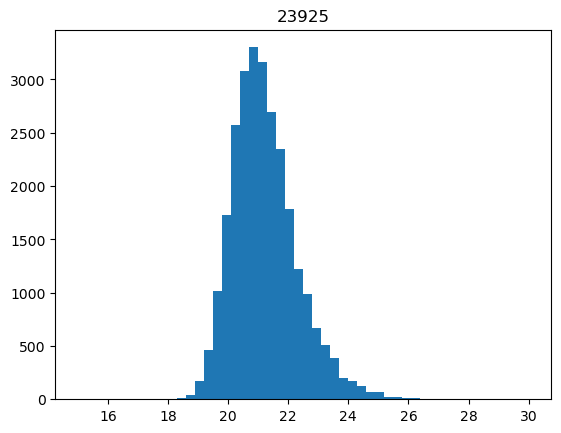

  8%|██████                                                                          | 82/1075 [00:10<02:06,  7.86it/s]

1055


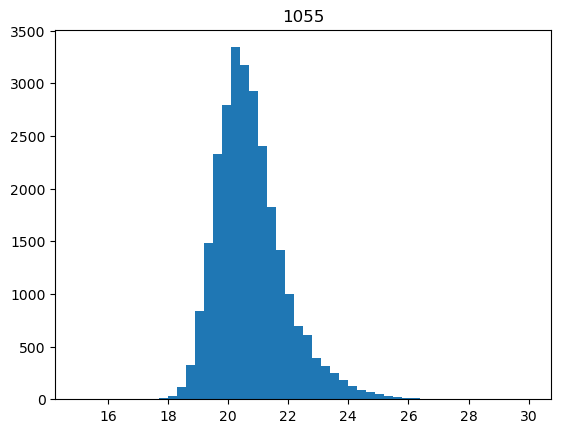

  8%|██████▏                                                                         | 83/1075 [00:11<02:33,  6.45it/s]

12456


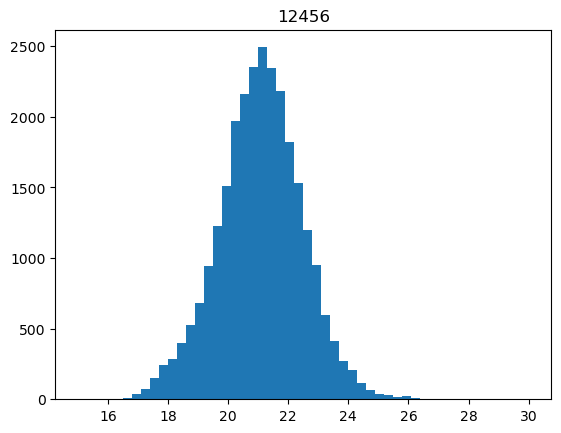

  8%|██████▎                                                                         | 84/1075 [00:11<02:24,  6.87it/s]

21948


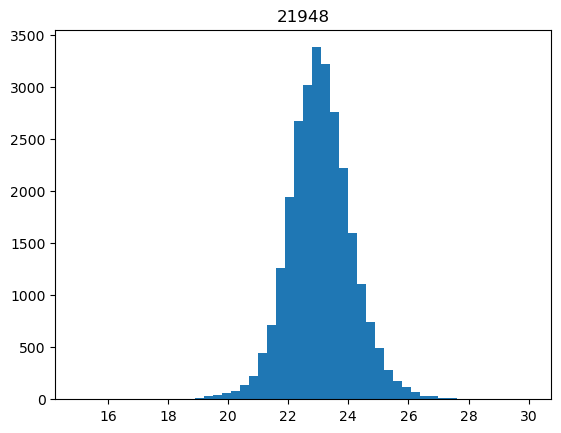

  8%|██████▎                                                                         | 85/1075 [00:11<02:18,  7.16it/s]

19488


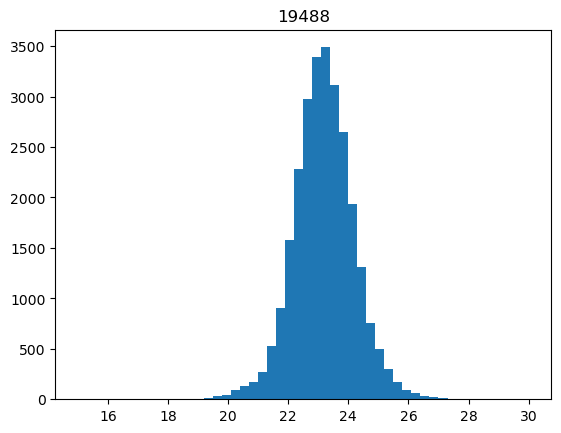

  8%|██████▍                                                                         | 86/1075 [00:11<02:13,  7.41it/s]

3685


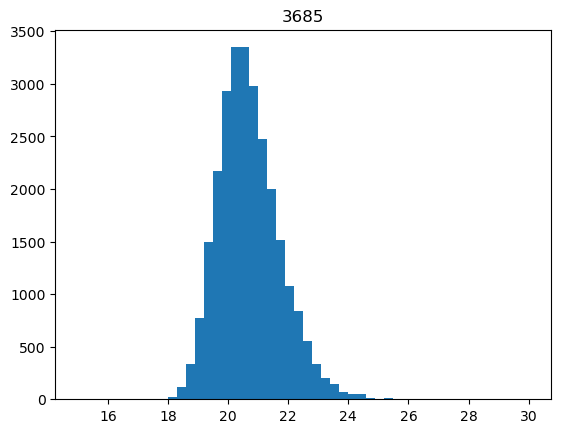

  8%|██████▍                                                                         | 87/1075 [00:11<02:10,  7.59it/s]

21522


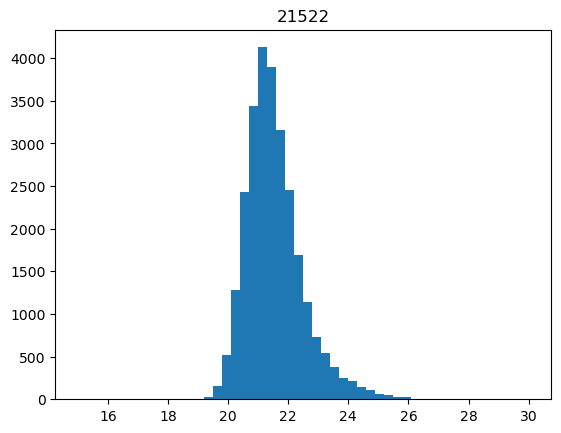

  8%|██████▌                                                                         | 88/1075 [00:11<02:08,  7.69it/s]

25135


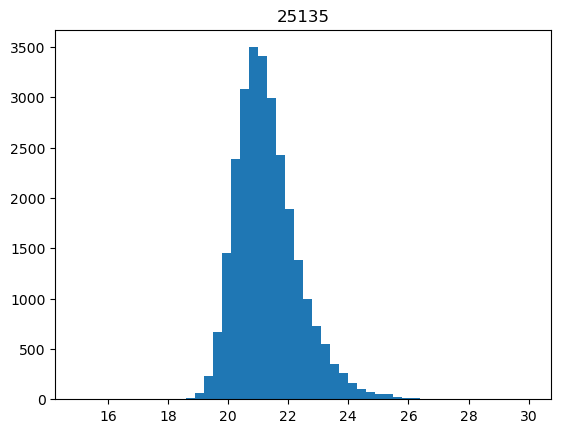

  8%|██████▌                                                                         | 89/1075 [00:11<02:06,  7.76it/s]

504


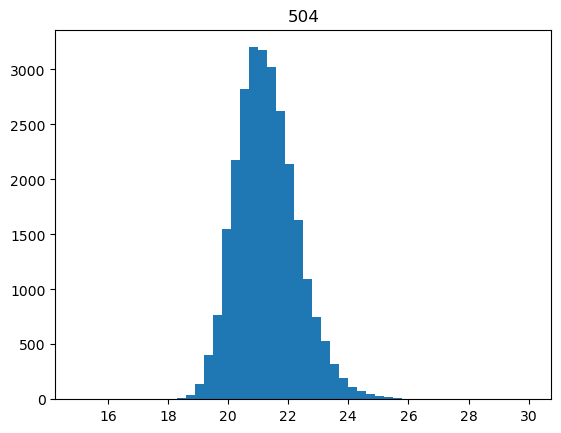

  8%|██████▋                                                                         | 90/1075 [00:11<02:07,  7.71it/s]

8947


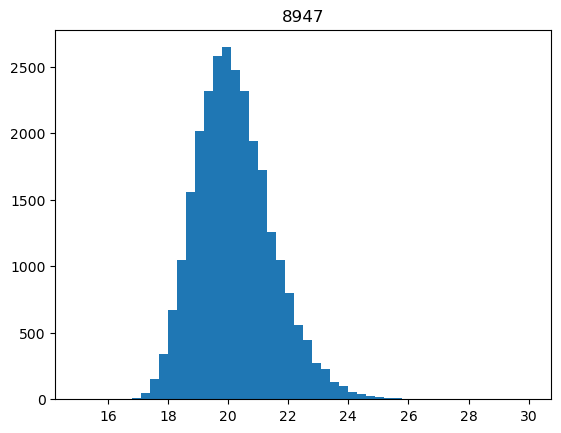

  8%|██████▊                                                                         | 91/1075 [00:12<02:06,  7.79it/s]

5546


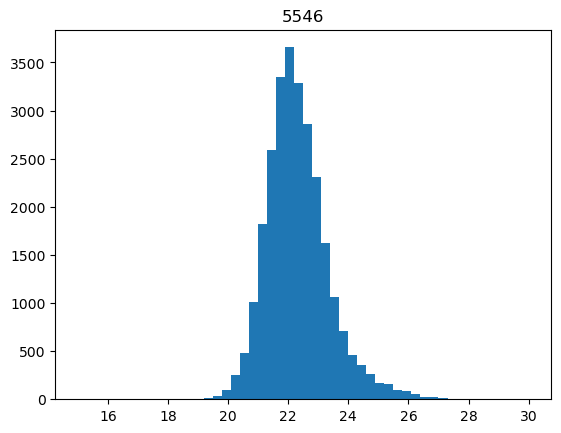

  9%|██████▊                                                                         | 92/1075 [00:12<02:05,  7.82it/s]

11921


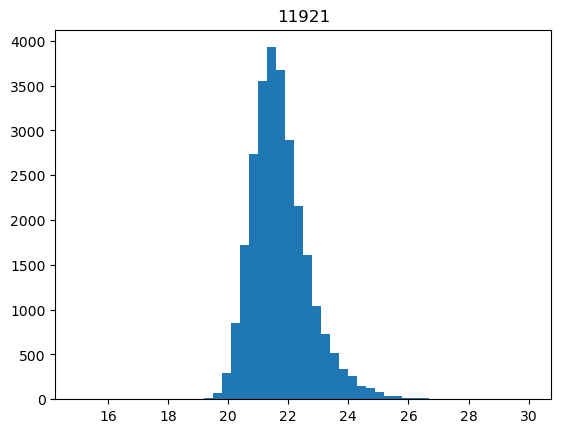

  9%|██████▉                                                                         | 93/1075 [00:12<02:05,  7.83it/s]

809


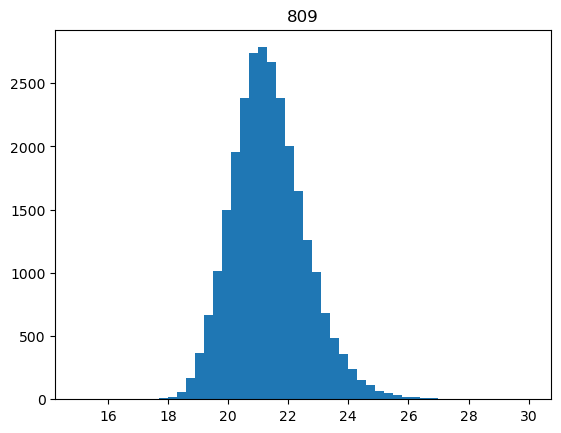

  9%|██████▉                                                                         | 94/1075 [00:12<02:28,  6.59it/s]

22612


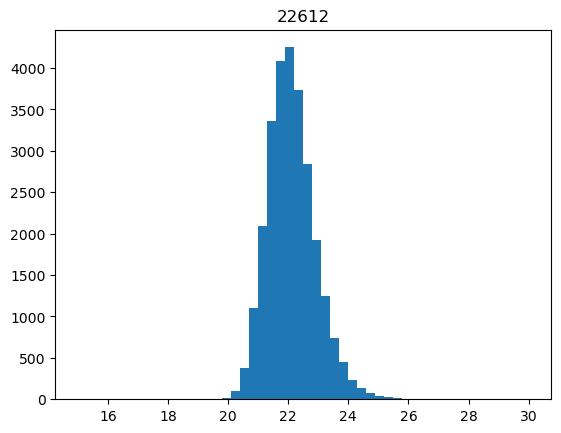

  9%|███████                                                                         | 95/1075 [00:12<02:21,  6.94it/s]

20185


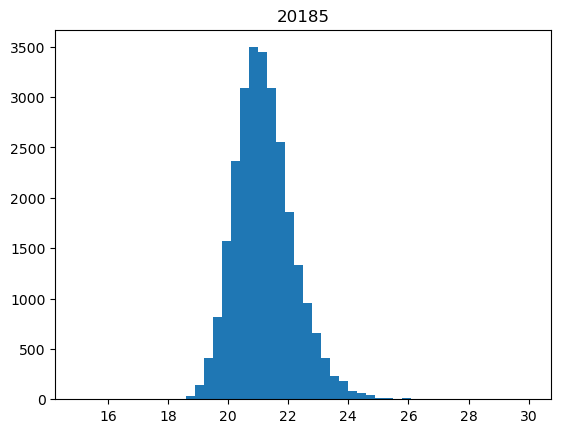

  9%|███████▏                                                                        | 96/1075 [00:12<02:15,  7.23it/s]

10304


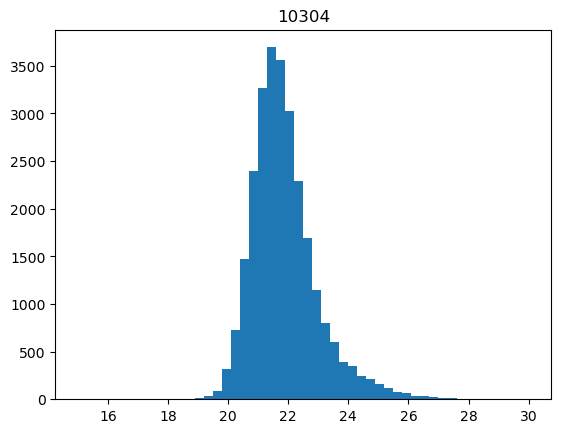

  9%|███████▏                                                                        | 97/1075 [00:12<02:11,  7.44it/s]

4409


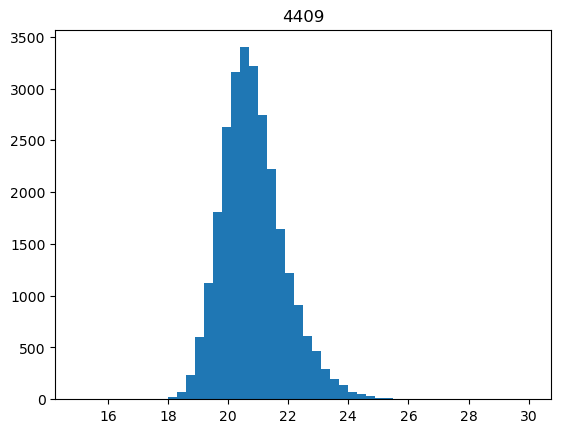

  9%|███████▎                                                                        | 98/1075 [00:13<02:08,  7.60it/s]

6329


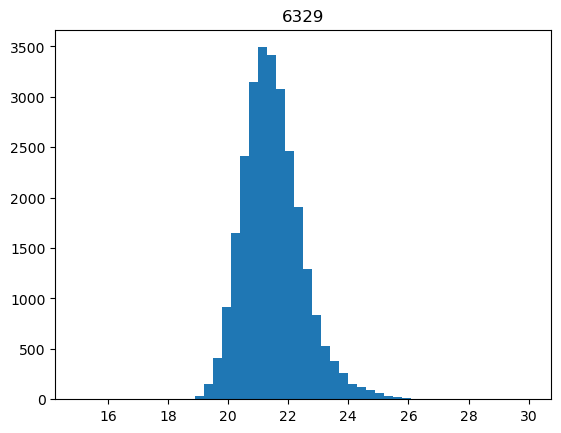

  9%|███████▎                                                                        | 99/1075 [00:13<02:06,  7.72it/s]

19924


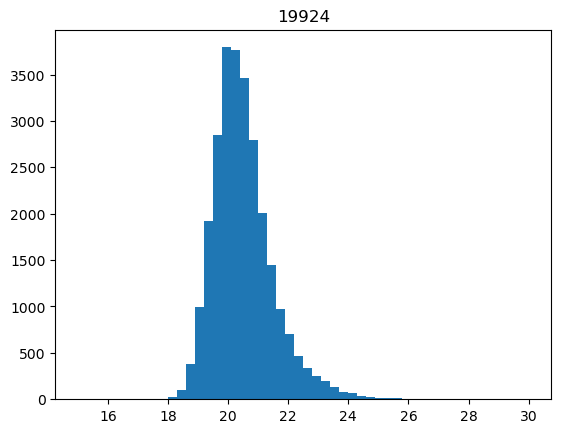

  9%|███████▎                                                                       | 100/1075 [00:13<02:06,  7.73it/s]

9391


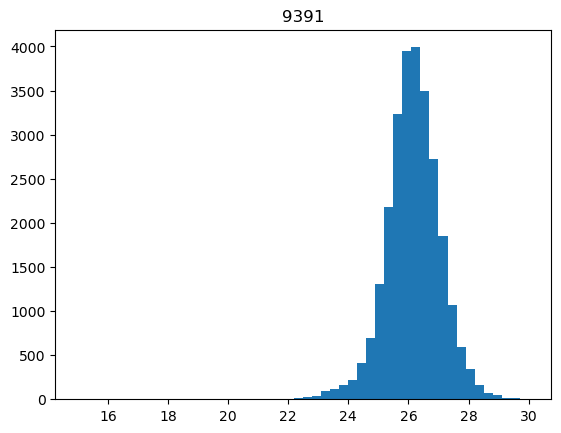

  9%|███████▍                                                                       | 101/1075 [00:13<02:07,  7.63it/s]

9466


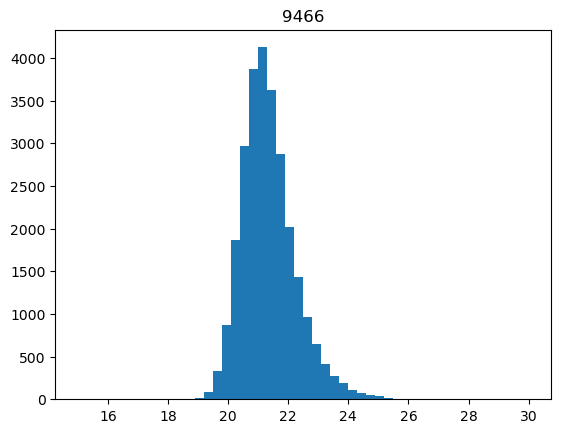

  9%|███████▍                                                                       | 102/1075 [00:13<02:06,  7.68it/s]

26362


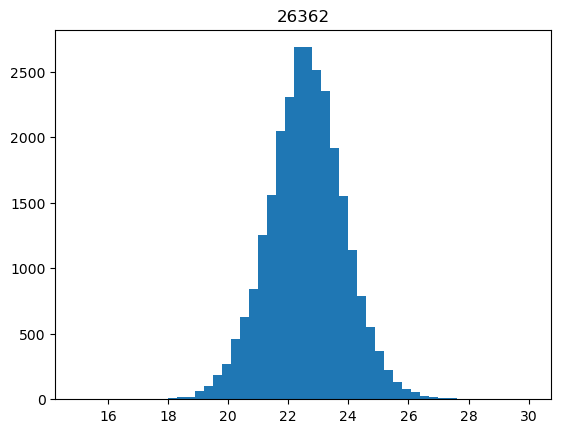

 10%|███████▌                                                                       | 103/1075 [00:13<02:05,  7.72it/s]

4065


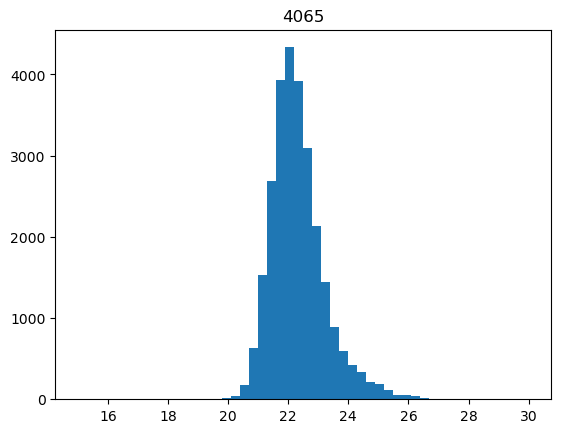

 10%|███████▋                                                                       | 104/1075 [00:13<02:03,  7.86it/s]

20553


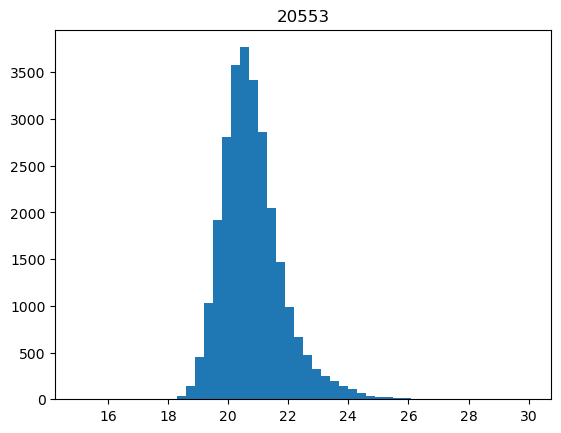

 10%|███████▋                                                                       | 105/1075 [00:14<02:30,  6.43it/s]

2633


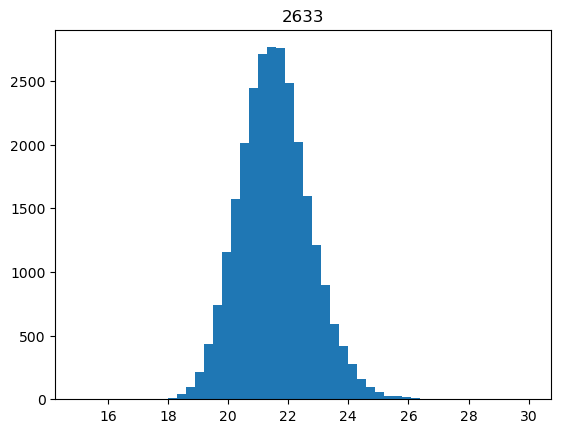

 10%|███████▊                                                                       | 106/1075 [00:14<02:21,  6.85it/s]

21161


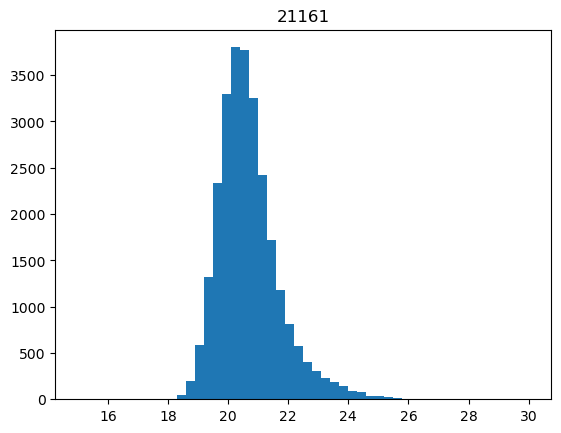

 10%|███████▊                                                                       | 107/1075 [00:14<02:16,  7.10it/s]

20702


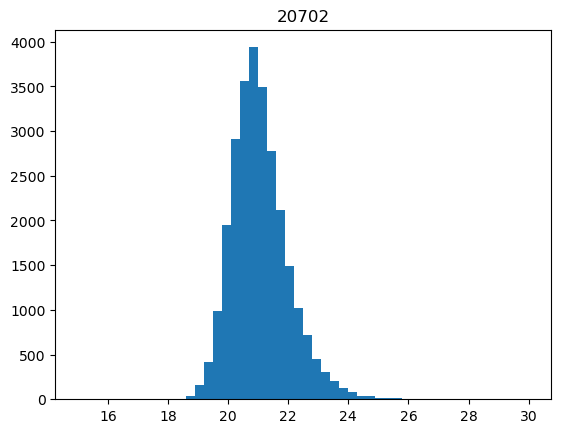

 10%|███████▉                                                                       | 108/1075 [00:14<02:13,  7.25it/s]

26029


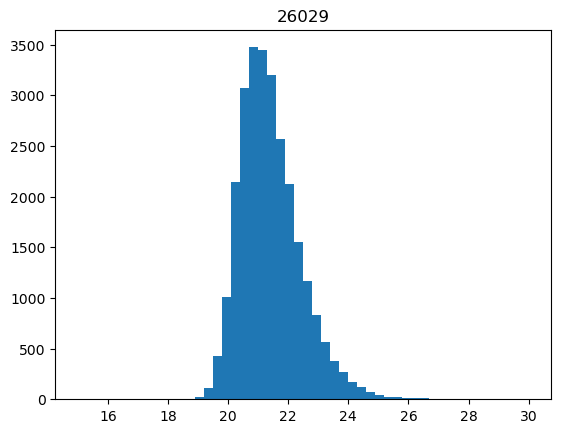

 10%|████████                                                                       | 109/1075 [00:14<02:09,  7.44it/s]

9556


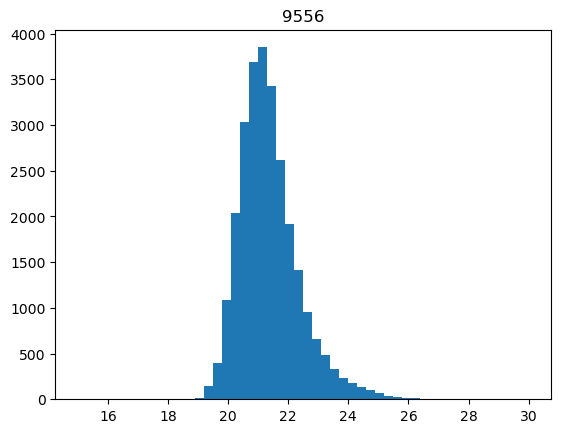

 10%|████████                                                                       | 110/1075 [00:14<02:07,  7.57it/s]

6358


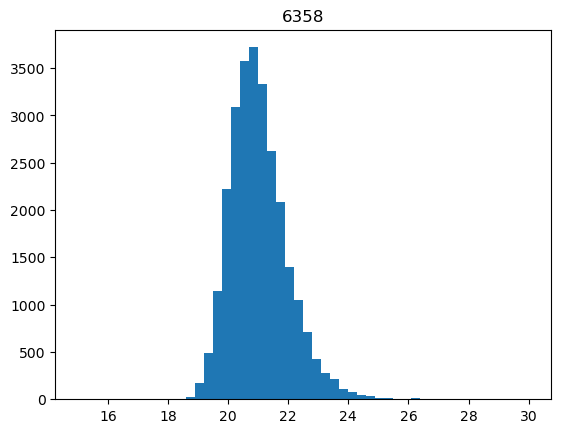

 10%|████████▏                                                                      | 111/1075 [00:14<02:06,  7.64it/s]

9438


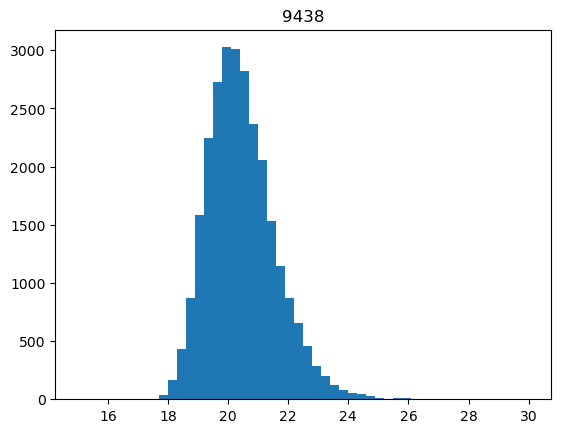

 10%|████████▏                                                                      | 112/1075 [00:14<02:05,  7.69it/s]

26467


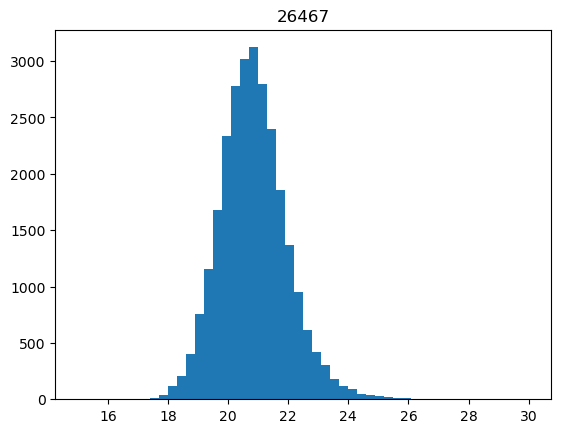

 11%|████████▎                                                                      | 113/1075 [00:15<02:04,  7.74it/s]

2405


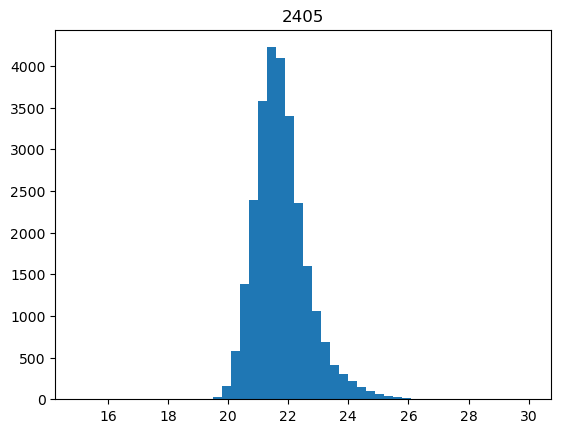

 11%|████████▍                                                                      | 114/1075 [00:15<02:04,  7.73it/s]

16445


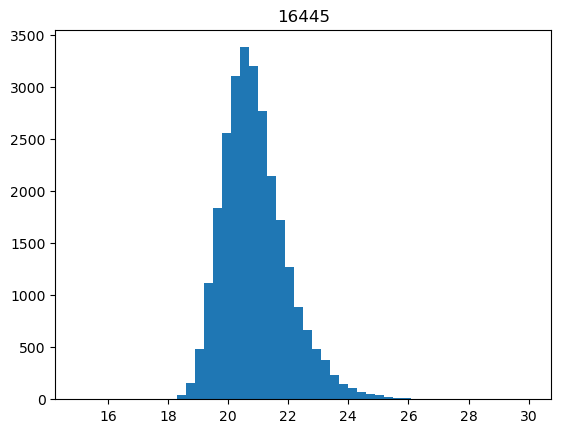

 11%|████████▍                                                                      | 115/1075 [00:15<02:03,  7.79it/s]

1966


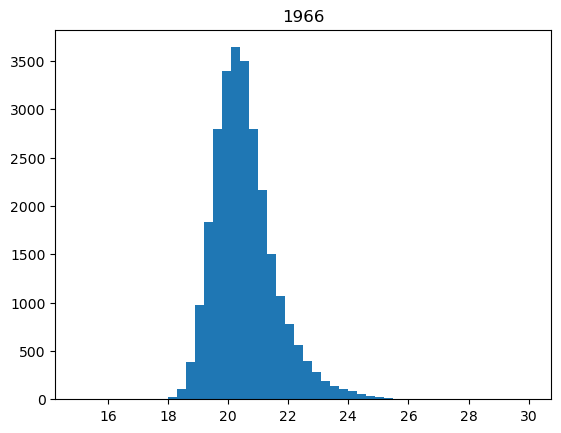

 11%|████████▌                                                                      | 116/1075 [00:15<02:25,  6.59it/s]

20006


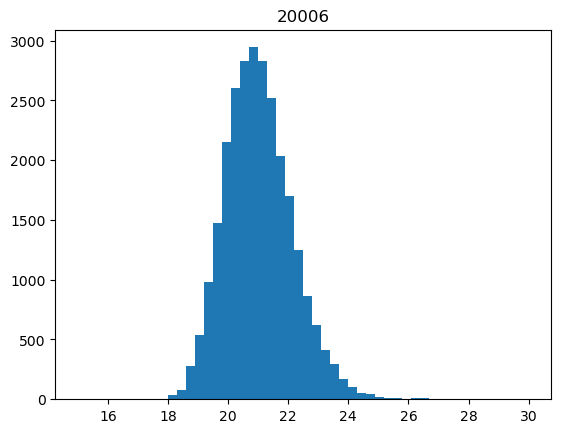

 11%|████████▌                                                                      | 117/1075 [00:15<02:17,  6.97it/s]

10417


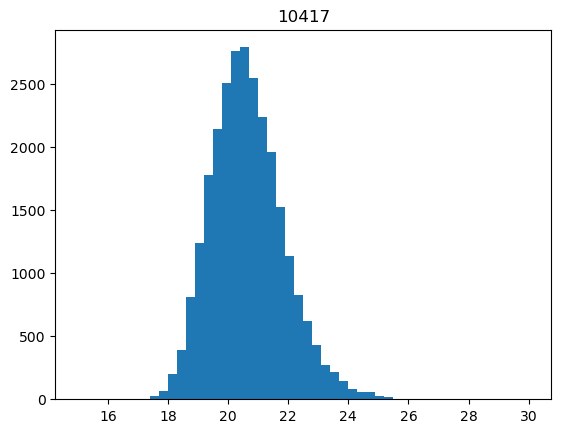

 11%|████████▋                                                                      | 118/1075 [00:15<02:11,  7.28it/s]

18883


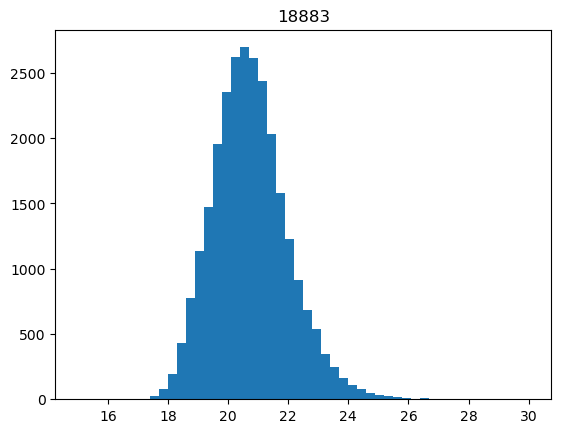

 11%|████████▋                                                                      | 119/1075 [00:15<02:07,  7.52it/s]

9244


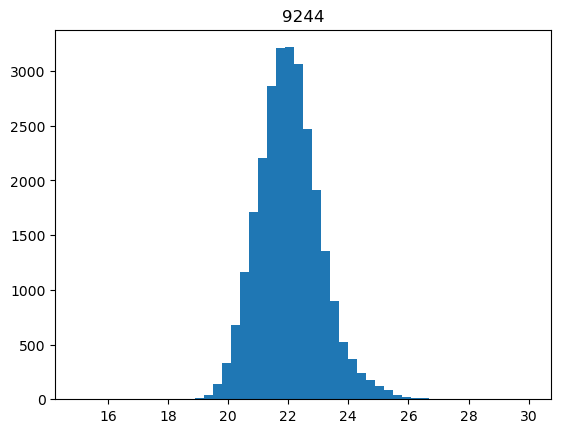

 11%|████████▊                                                                      | 120/1075 [00:15<02:04,  7.67it/s]

7442


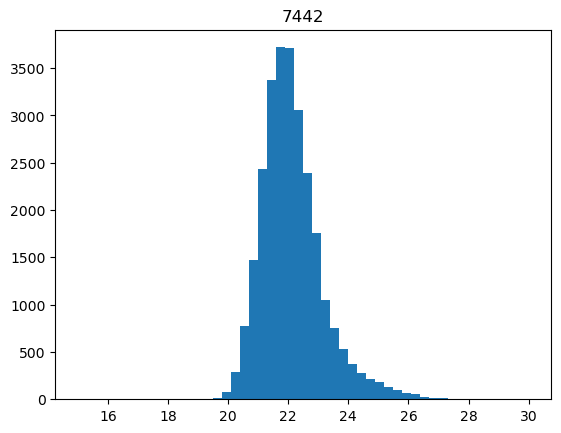

 11%|████████▉                                                                      | 121/1075 [00:16<02:02,  7.77it/s]

17047


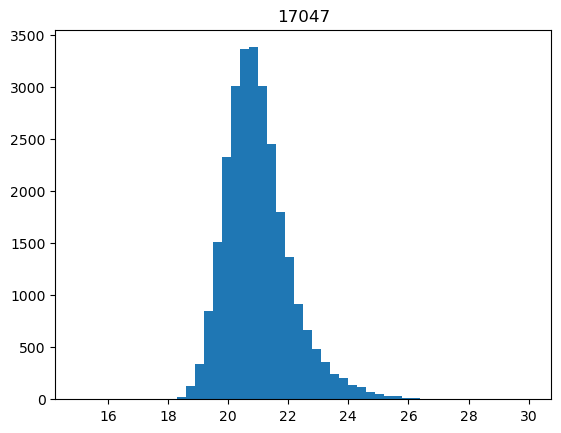

 11%|████████▉                                                                      | 122/1075 [00:16<02:01,  7.87it/s]

24815


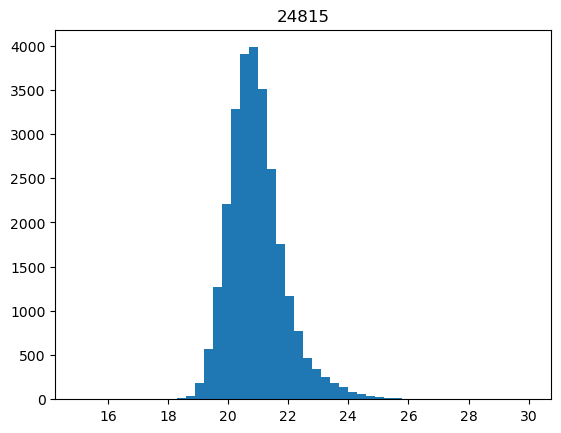

 11%|█████████                                                                      | 123/1075 [00:16<02:00,  7.89it/s]

23263


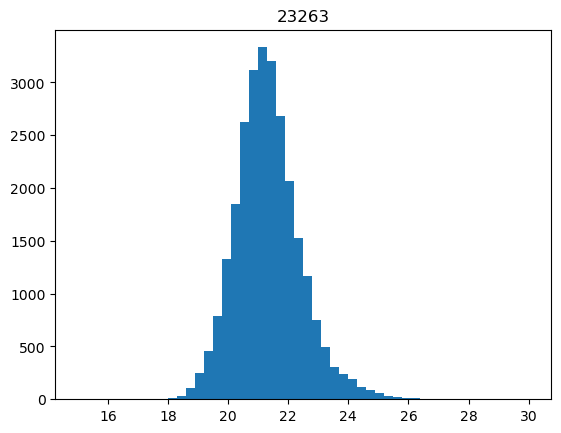

 12%|█████████                                                                      | 124/1075 [00:16<02:00,  7.90it/s]

6217


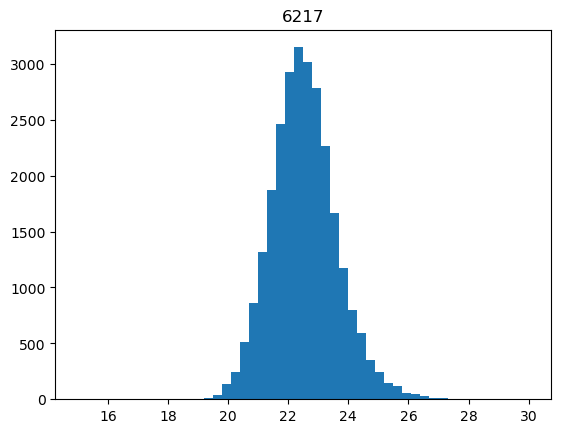

 12%|█████████▏                                                                     | 125/1075 [00:16<02:00,  7.91it/s]

6894


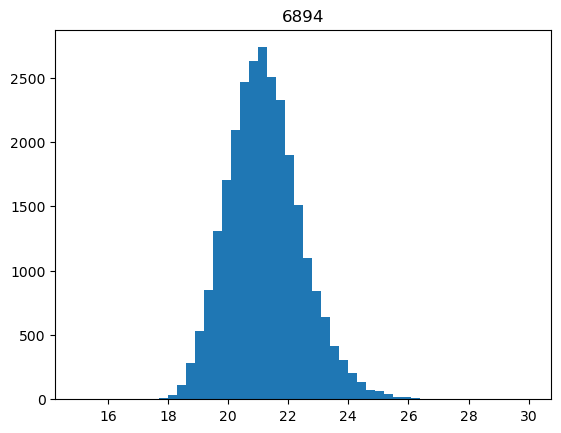

 12%|█████████▎                                                                     | 126/1075 [00:16<01:58,  8.02it/s]

3821


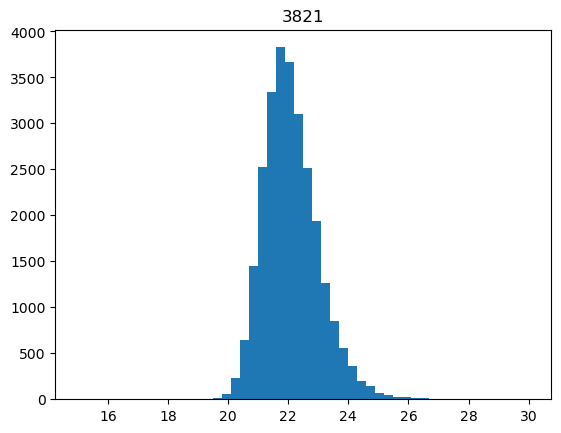

 12%|█████████▎                                                                     | 127/1075 [00:16<02:23,  6.59it/s]

22550


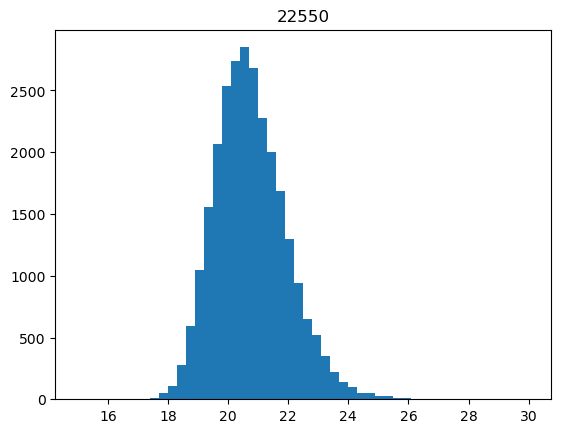

 12%|█████████▍                                                                     | 128/1075 [00:17<02:16,  6.94it/s]

7415


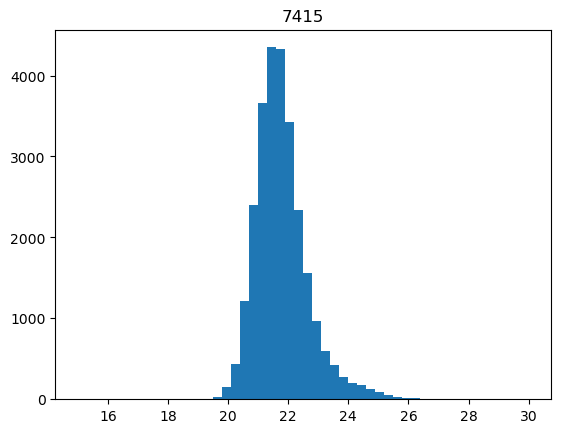

 12%|█████████▍                                                                     | 129/1075 [00:17<02:12,  7.16it/s]

17258


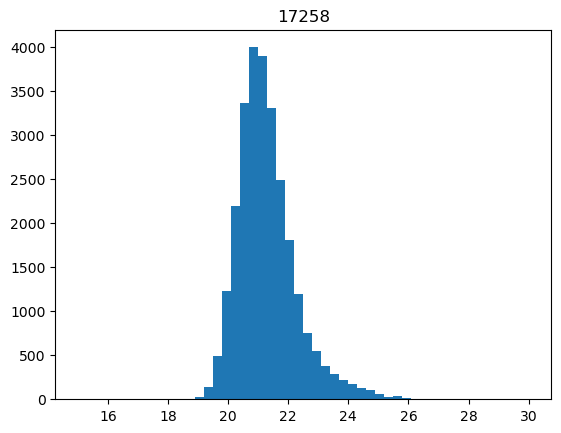

 12%|█████████▌                                                                     | 130/1075 [00:17<02:09,  7.30it/s]

14358


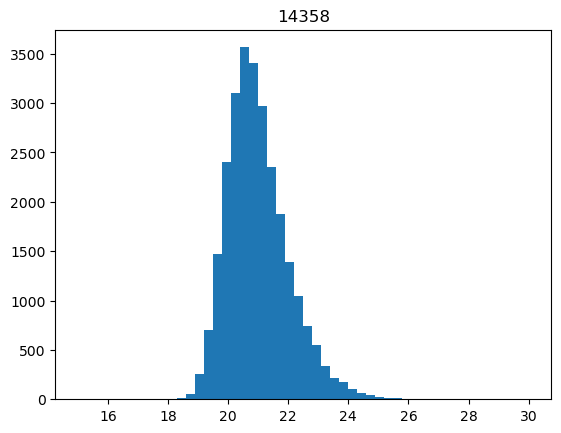

 12%|█████████▋                                                                     | 131/1075 [00:17<02:07,  7.43it/s]

17301


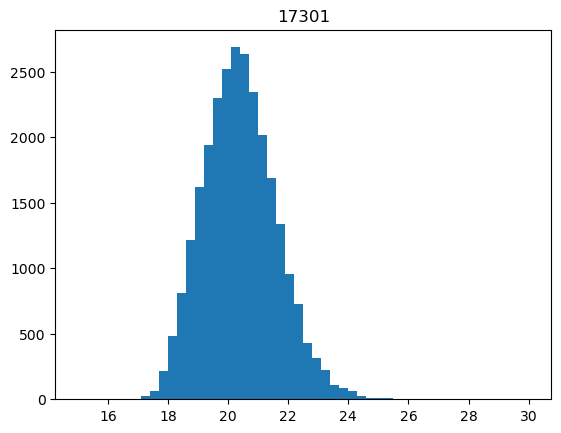

 12%|█████████▋                                                                     | 132/1075 [00:17<02:03,  7.63it/s]

12512


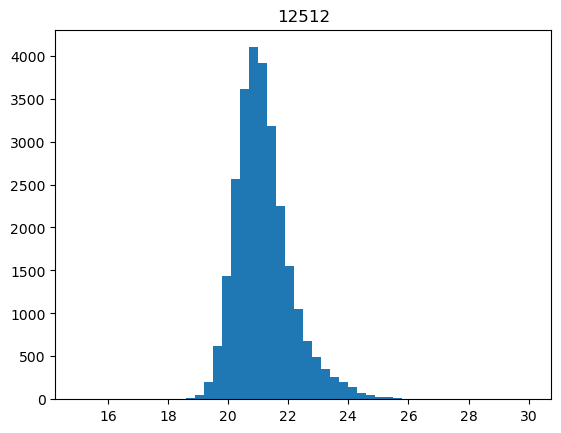

 12%|█████████▊                                                                     | 133/1075 [00:17<02:03,  7.61it/s]

21637


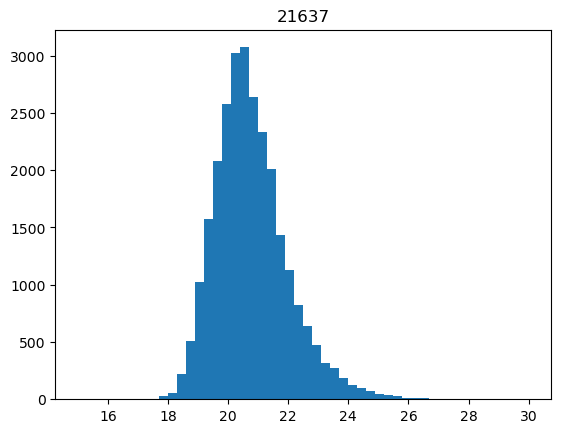

 12%|█████████▊                                                                     | 134/1075 [00:17<02:01,  7.72it/s]

2587


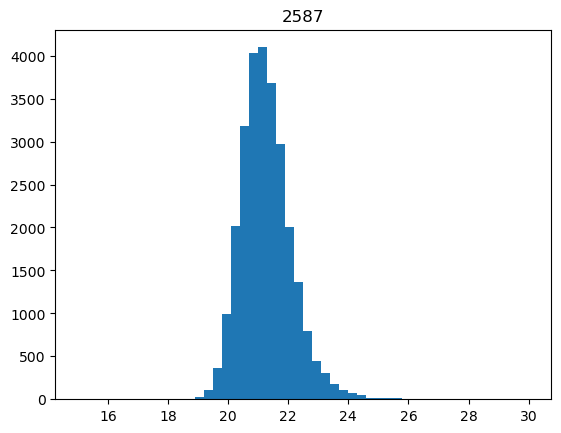

 13%|█████████▉                                                                     | 135/1075 [00:17<02:00,  7.80it/s]

25660


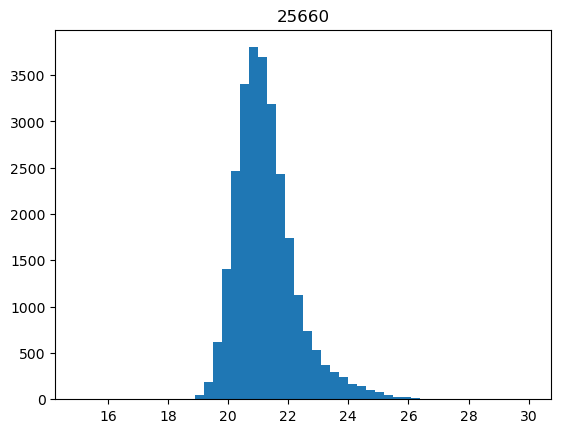

 13%|█████████▉                                                                     | 136/1075 [00:18<01:59,  7.88it/s]

2762


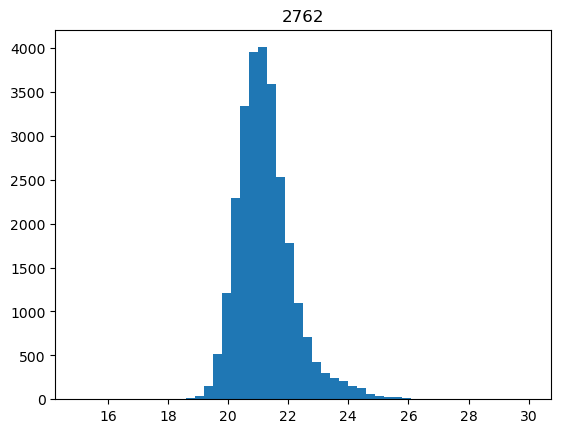

 13%|██████████                                                                     | 137/1075 [00:18<01:58,  7.91it/s]

15509


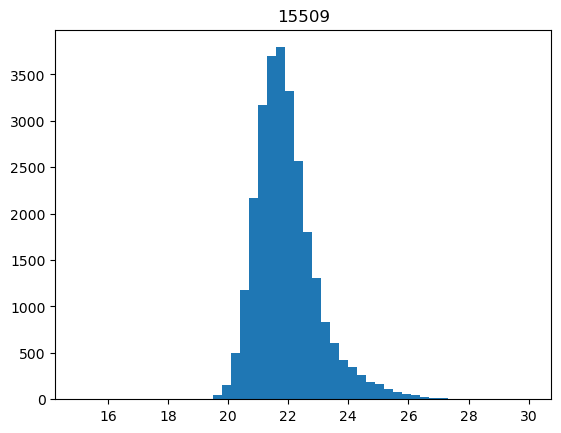

 13%|██████████▏                                                                    | 138/1075 [00:18<02:20,  6.66it/s]

7596


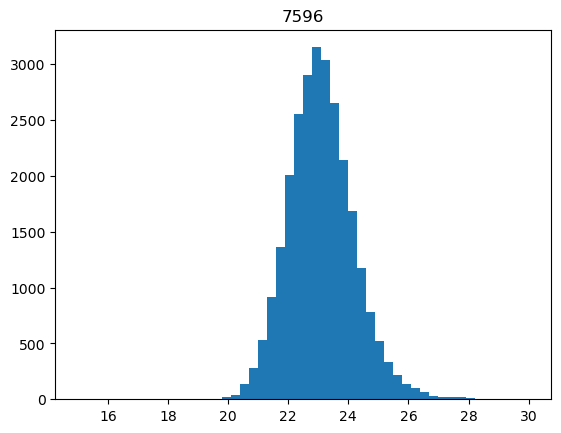

 13%|██████████▏                                                                    | 139/1075 [00:18<02:12,  7.05it/s]

25598


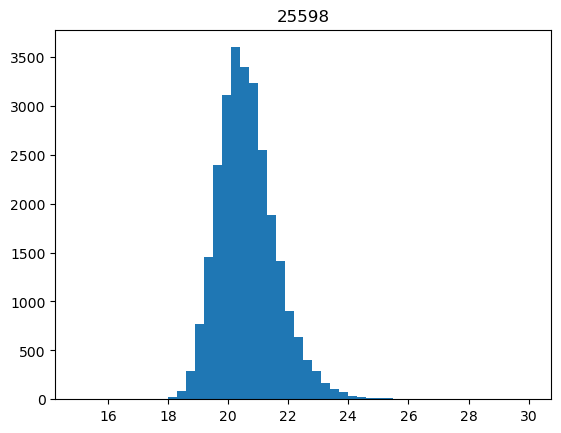

 13%|██████████▎                                                                    | 140/1075 [00:18<02:07,  7.33it/s]

9011


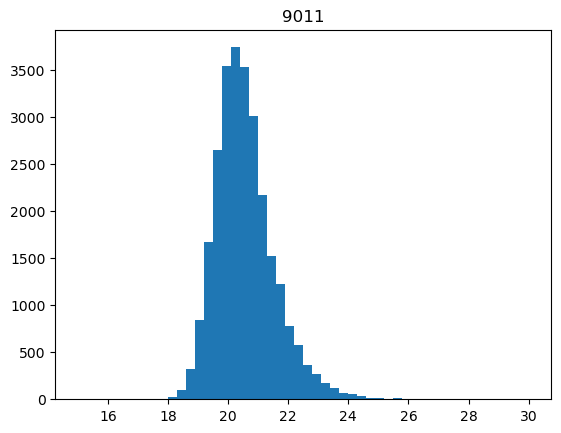

 13%|██████████▎                                                                    | 141/1075 [00:18<02:03,  7.53it/s]

23984


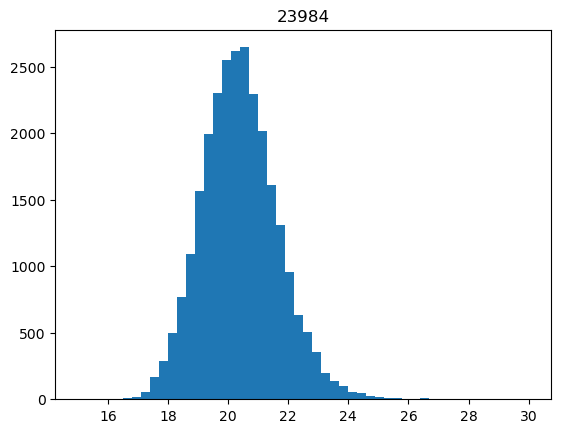

 13%|██████████▍                                                                    | 142/1075 [00:18<02:00,  7.72it/s]

23068


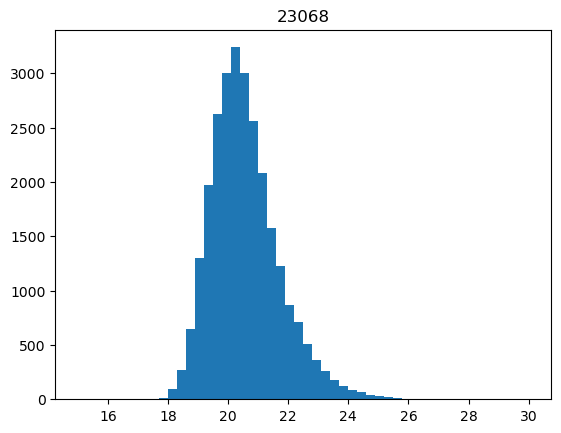

 13%|██████████▌                                                                    | 143/1075 [00:19<01:58,  7.84it/s]

9353


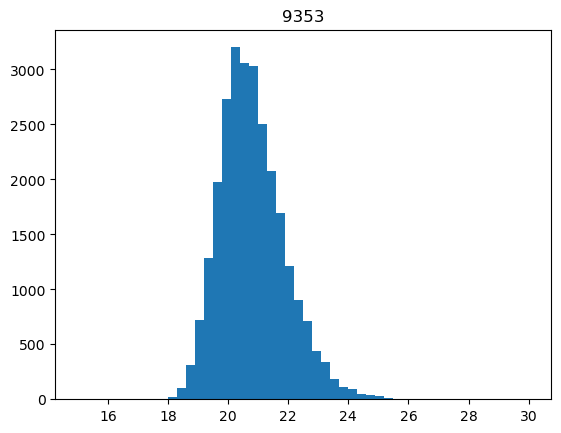

 13%|██████████▌                                                                    | 144/1075 [00:19<01:57,  7.90it/s]

20495


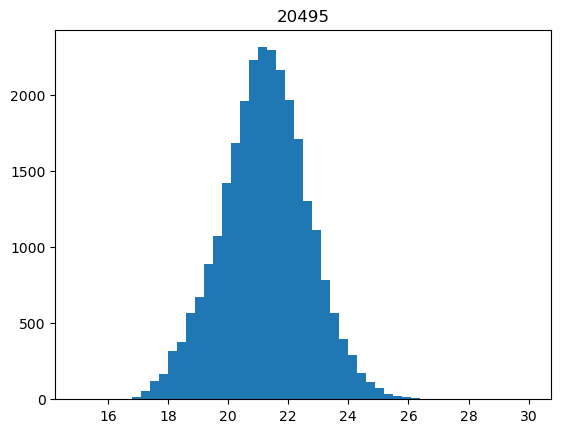

 13%|██████████▋                                                                    | 145/1075 [00:19<01:55,  8.03it/s]

19793


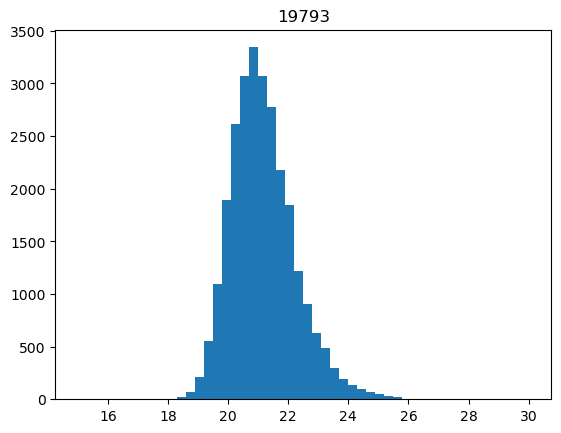

 14%|██████████▋                                                                    | 146/1075 [00:19<01:56,  8.00it/s]

12278


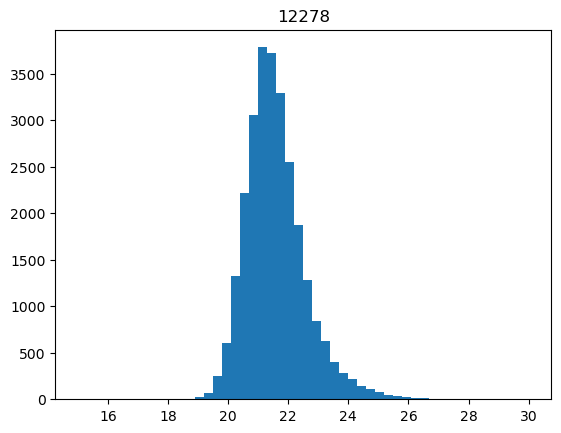

 14%|██████████▊                                                                    | 147/1075 [00:19<01:55,  8.02it/s]

932


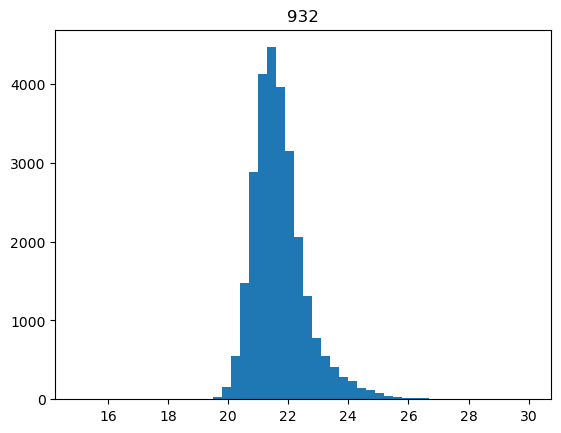

 14%|██████████▉                                                                    | 148/1075 [00:19<01:53,  8.15it/s]

16819


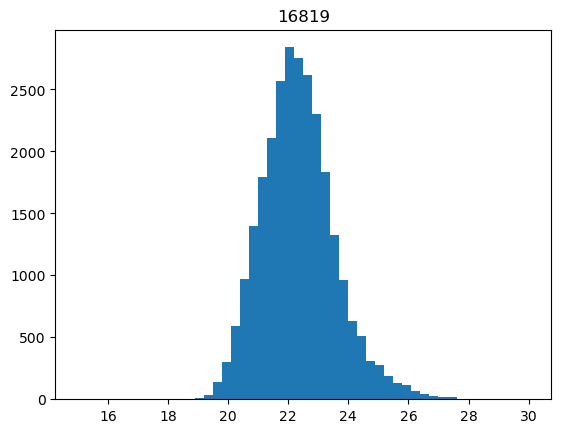

 14%|██████████▉                                                                    | 149/1075 [00:19<02:16,  6.80it/s]

14881


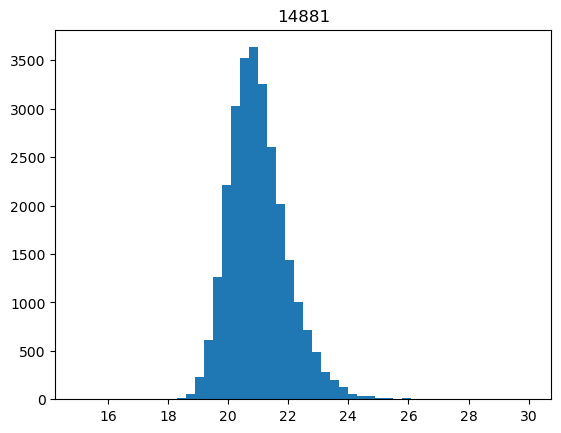

 14%|███████████                                                                    | 150/1075 [00:19<02:09,  7.12it/s]

3816


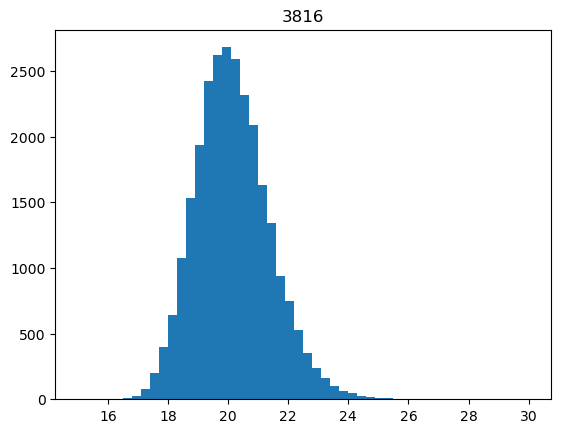

 14%|███████████                                                                    | 151/1075 [00:20<02:05,  7.36it/s]

14495


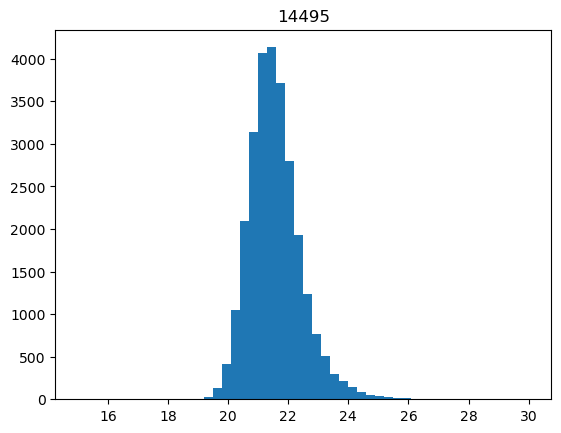

 14%|███████████▏                                                                   | 152/1075 [00:20<02:03,  7.46it/s]

11709


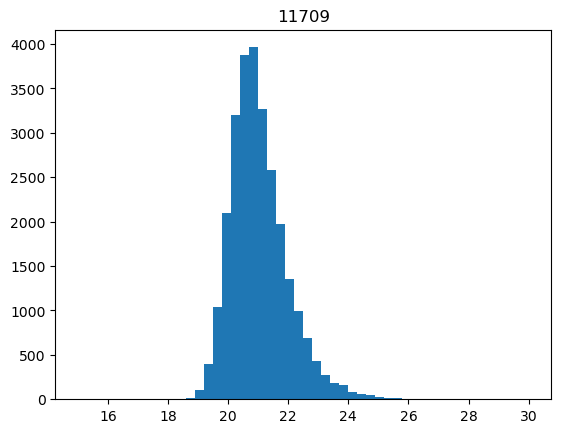

 14%|███████████▏                                                                   | 153/1075 [00:20<02:02,  7.53it/s]

26208


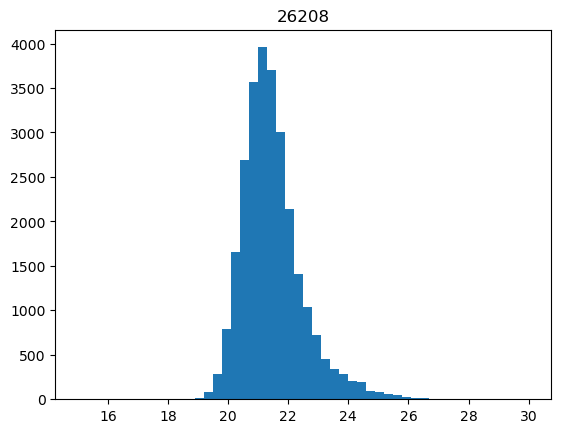

 14%|███████████▎                                                                   | 154/1075 [00:20<02:01,  7.59it/s]

16333


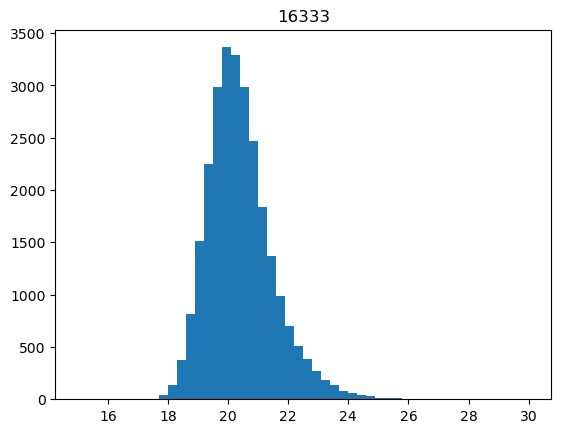

 14%|███████████▍                                                                   | 155/1075 [00:20<01:59,  7.67it/s]

24841


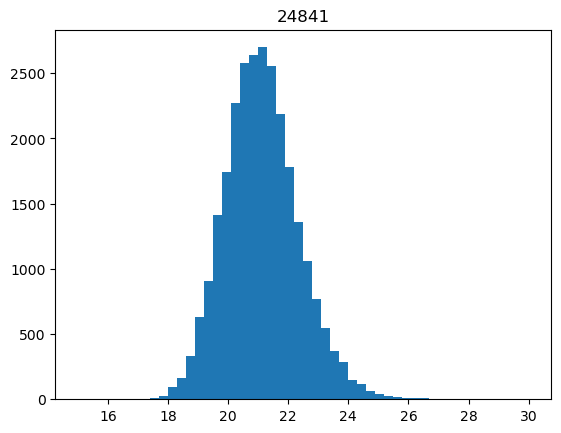

 15%|███████████▍                                                                   | 156/1075 [00:20<01:57,  7.84it/s]

635


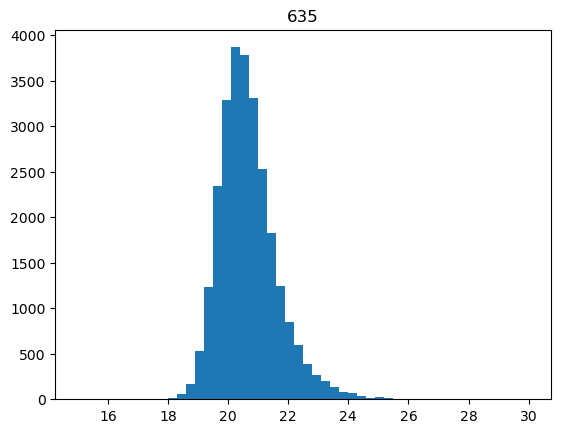

 15%|███████████▌                                                                   | 157/1075 [00:20<01:56,  7.85it/s]

16753


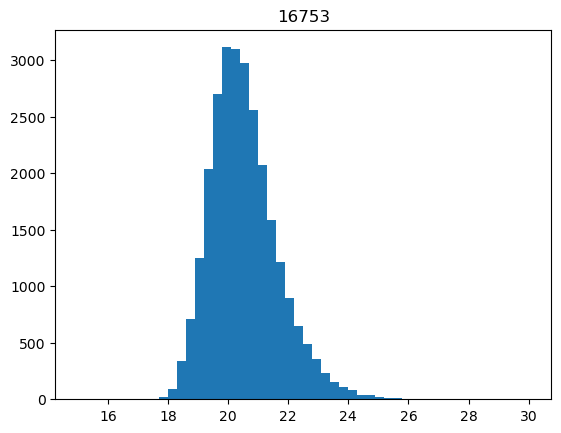

 15%|███████████▌                                                                   | 158/1075 [00:21<01:55,  7.91it/s]

20991


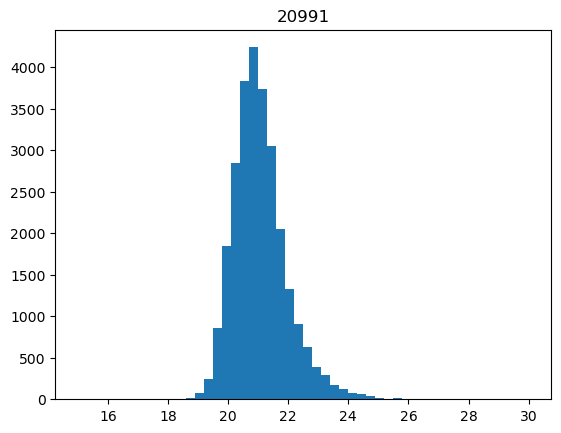

 15%|███████████▋                                                                   | 159/1075 [00:21<01:57,  7.79it/s]

22770


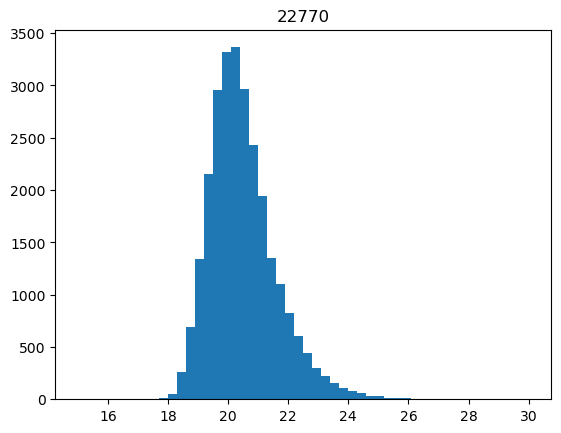

 15%|███████████▊                                                                   | 160/1075 [00:21<02:20,  6.53it/s]

18243


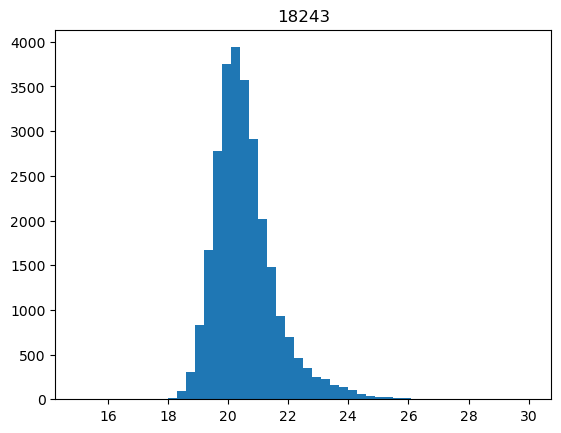

 15%|███████████▊                                                                   | 161/1075 [00:21<02:12,  6.90it/s]

8547


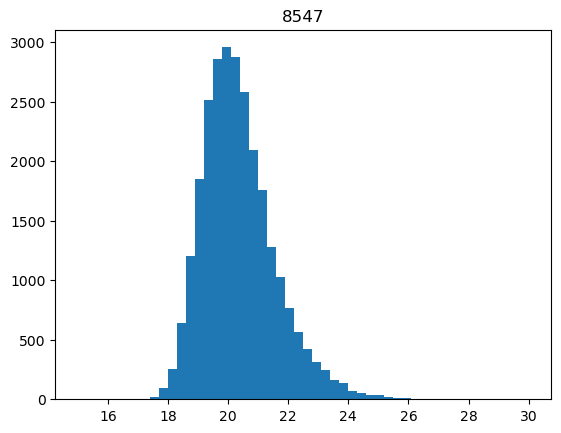

 15%|███████████▉                                                                   | 162/1075 [00:21<02:06,  7.19it/s]

19381


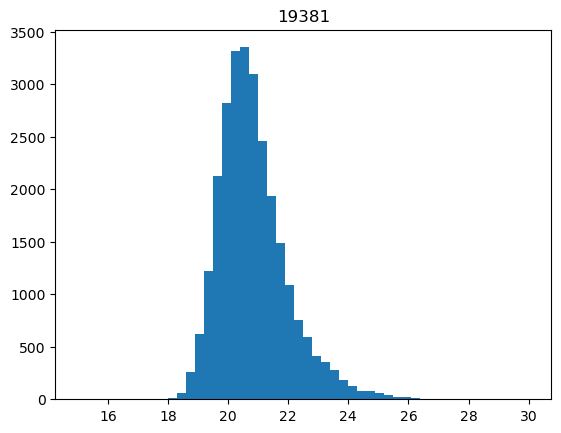

 15%|███████████▉                                                                   | 163/1075 [00:21<02:04,  7.34it/s]

1597


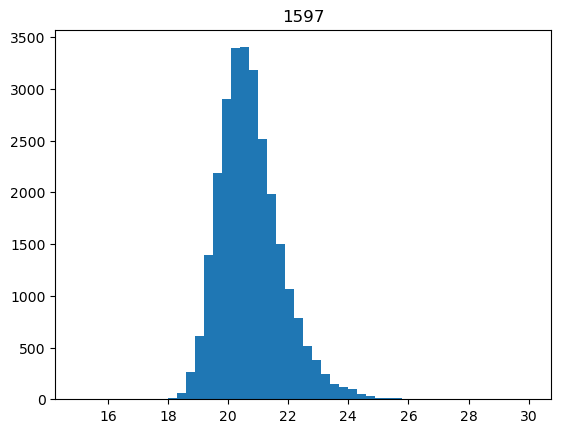

 15%|████████████                                                                   | 164/1075 [00:21<02:01,  7.51it/s]

2344


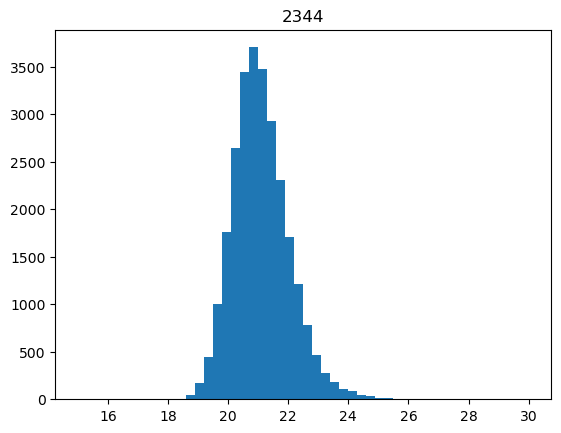

 15%|████████████▏                                                                  | 165/1075 [00:21<01:58,  7.66it/s]

6254


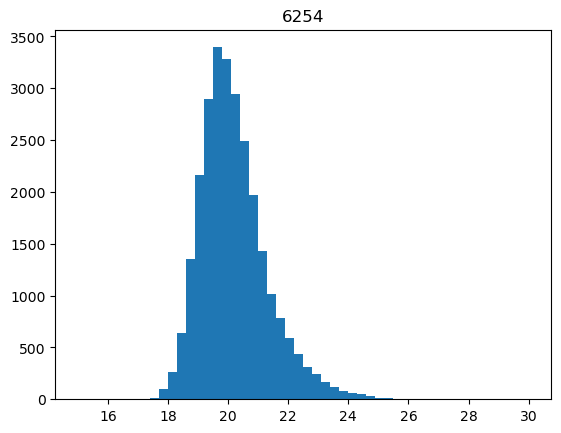

 15%|████████████▏                                                                  | 166/1075 [00:22<01:57,  7.74it/s]

20127


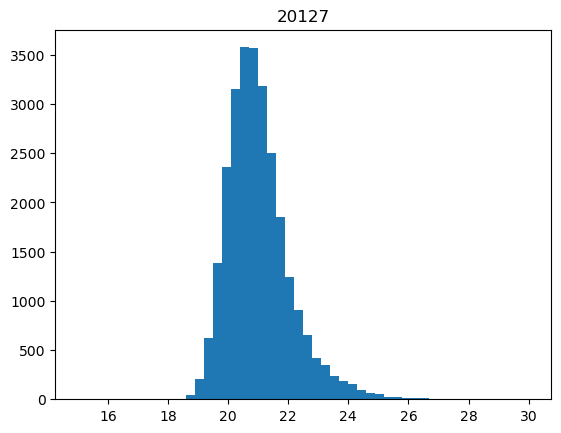

 16%|████████████▎                                                                  | 167/1075 [00:22<01:56,  7.80it/s]

10806


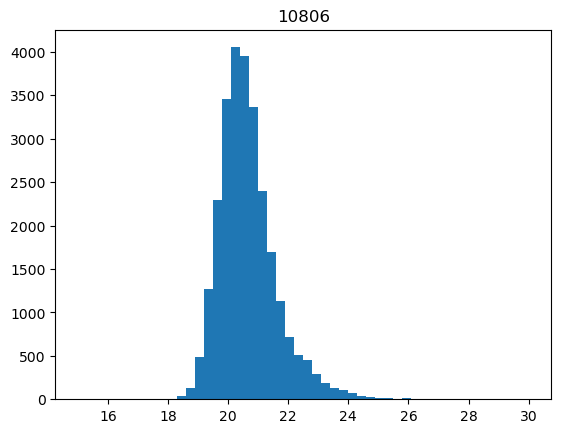

 16%|████████████▎                                                                  | 168/1075 [00:22<01:56,  7.80it/s]

5770


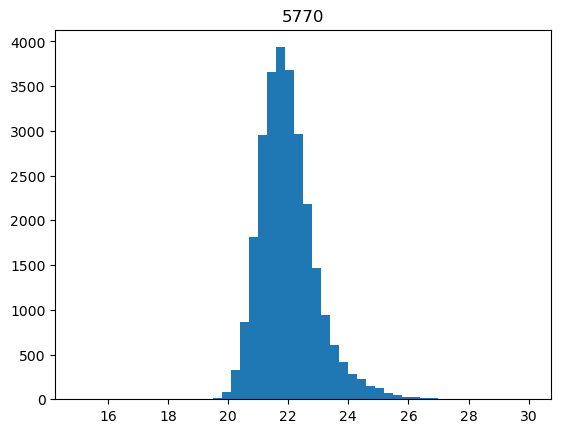

 16%|████████████▍                                                                  | 169/1075 [00:22<01:56,  7.81it/s]

25874


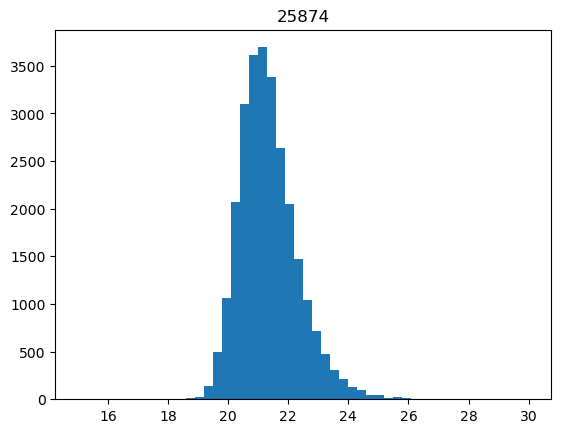

 16%|████████████▍                                                                  | 170/1075 [00:22<01:55,  7.81it/s]

15883


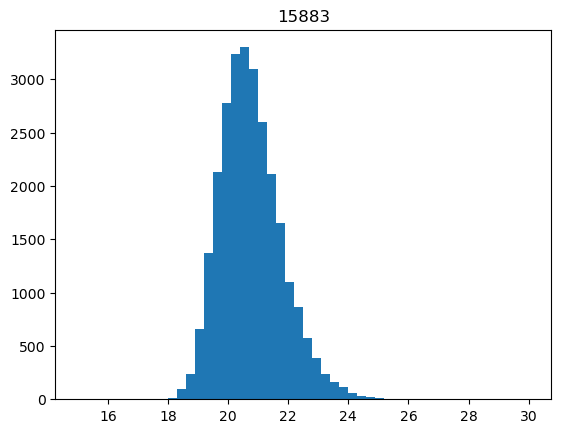

 16%|████████████▌                                                                  | 171/1075 [00:22<02:17,  6.56it/s]

7225


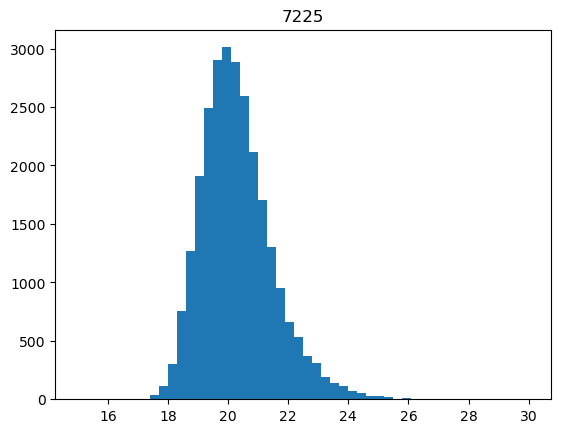

 16%|████████████▋                                                                  | 172/1075 [00:22<02:09,  6.99it/s]

3256


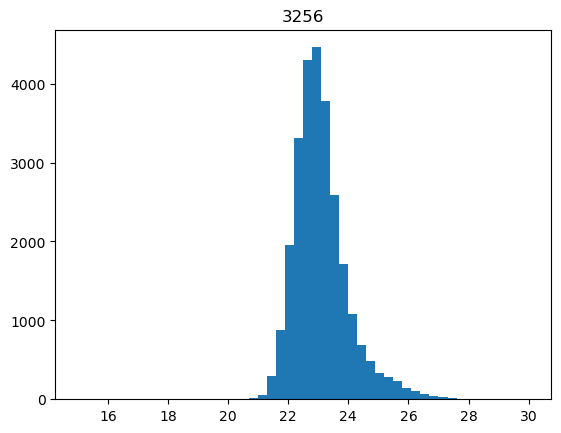

 16%|████████████▋                                                                  | 173/1075 [00:23<02:03,  7.33it/s]

329


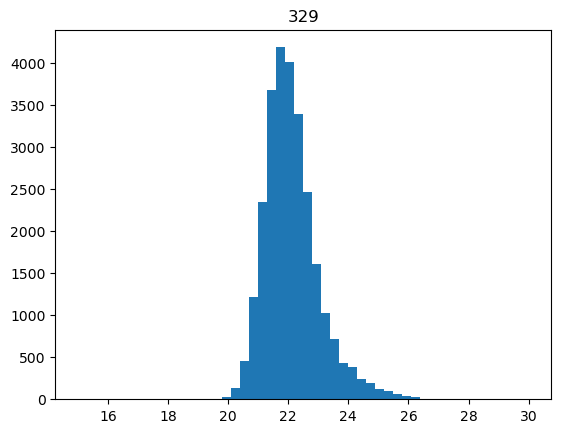

 16%|████████████▊                                                                  | 174/1075 [00:23<02:00,  7.50it/s]

9262


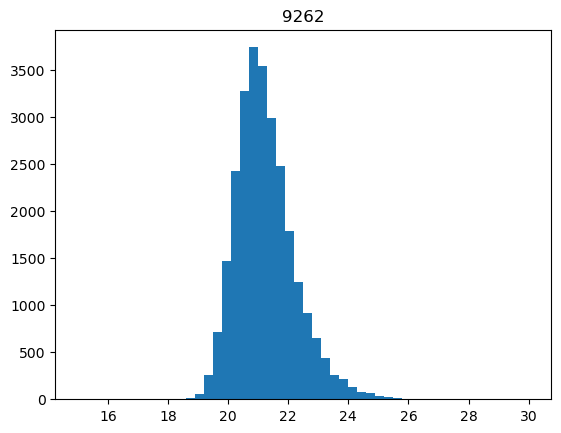

 16%|████████████▊                                                                  | 175/1075 [00:23<01:57,  7.64it/s]

20947


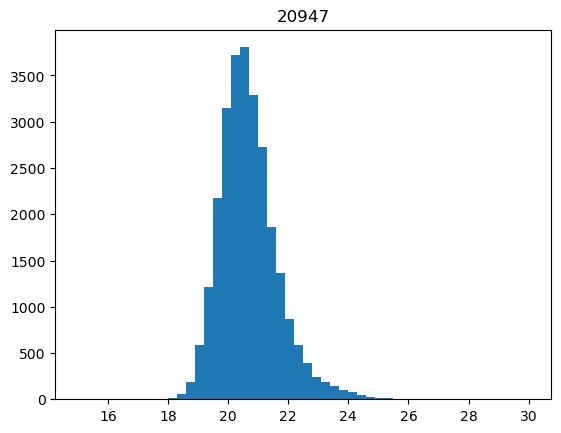

 16%|████████████▉                                                                  | 176/1075 [00:23<01:56,  7.75it/s]

12141


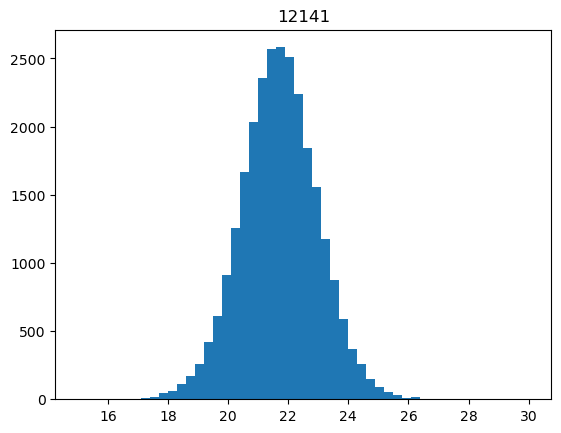

 16%|█████████████                                                                  | 177/1075 [00:23<01:54,  7.86it/s]

8538


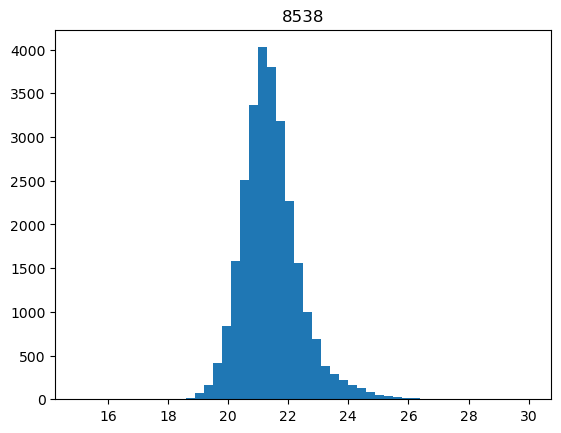

 17%|█████████████                                                                  | 178/1075 [00:23<01:54,  7.84it/s]

21005


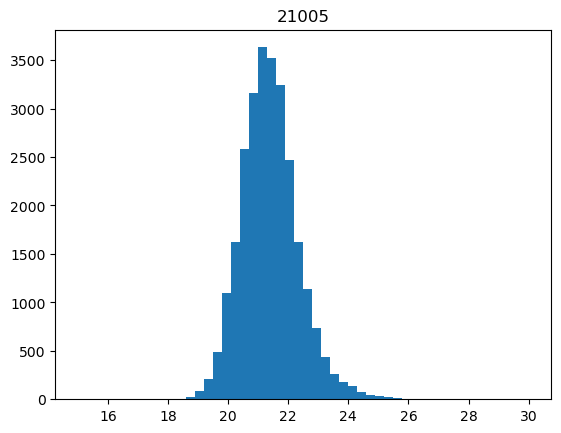

 17%|█████████████▏                                                                 | 179/1075 [00:23<01:53,  7.87it/s]

12360


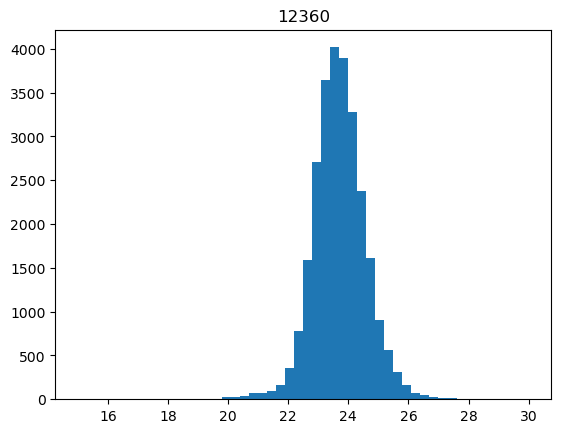

 17%|█████████████▏                                                                 | 180/1075 [00:23<01:53,  7.89it/s]

25366


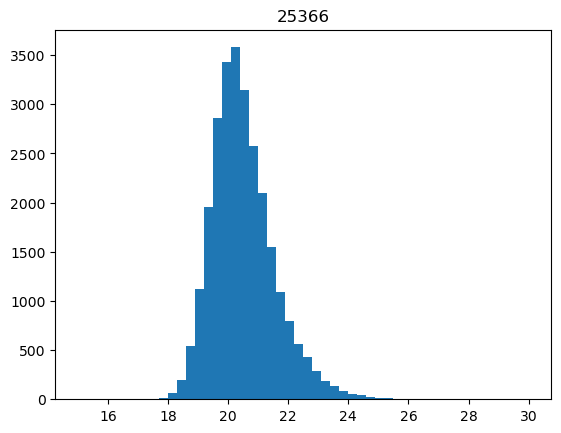

 17%|█████████████▎                                                                 | 181/1075 [00:24<01:52,  7.92it/s]

15567


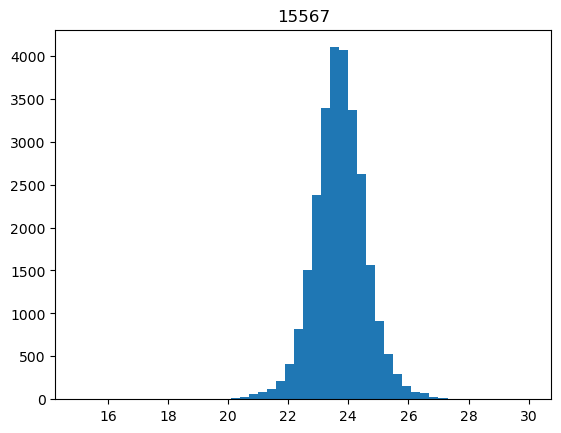

 17%|█████████████▎                                                                 | 182/1075 [00:24<02:14,  6.63it/s]

14069


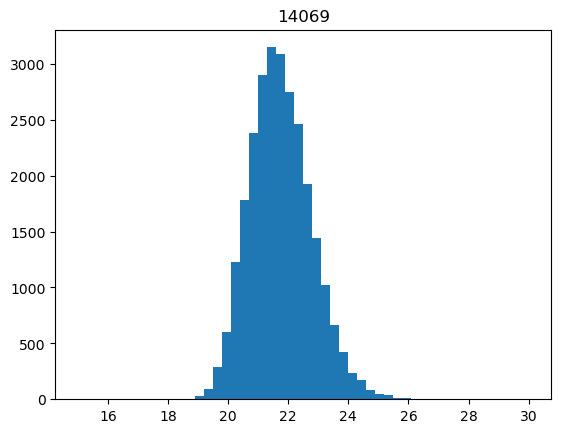

 17%|█████████████▍                                                                 | 183/1075 [00:24<02:07,  7.01it/s]

19028


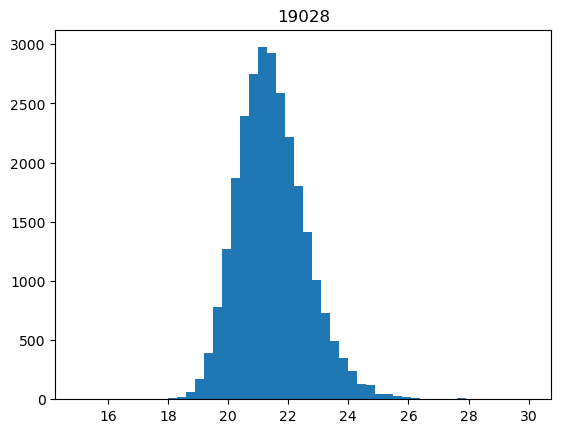

 17%|█████████████▌                                                                 | 184/1075 [00:24<02:02,  7.29it/s]

3908


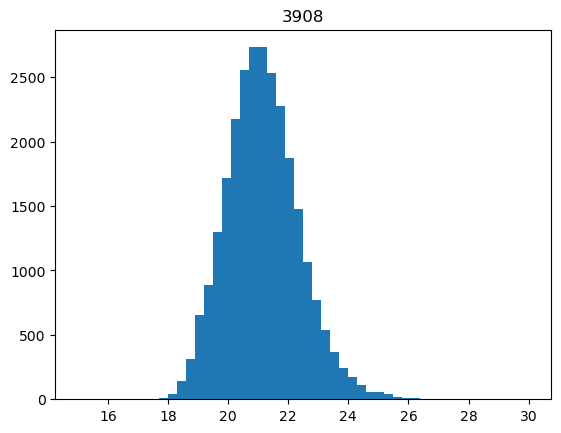

 17%|█████████████▌                                                                 | 185/1075 [00:24<01:58,  7.52it/s]

7363


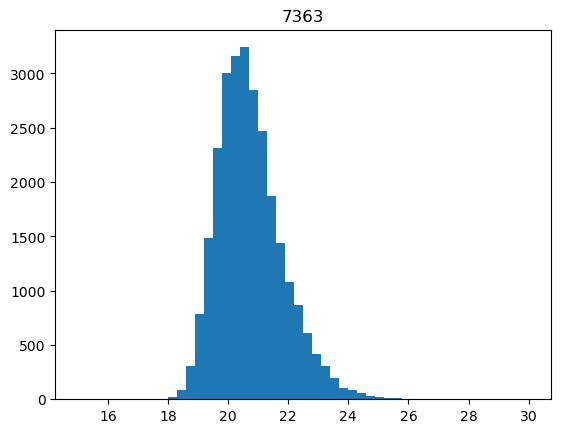

 17%|█████████████▋                                                                 | 186/1075 [00:24<01:57,  7.59it/s]

11731


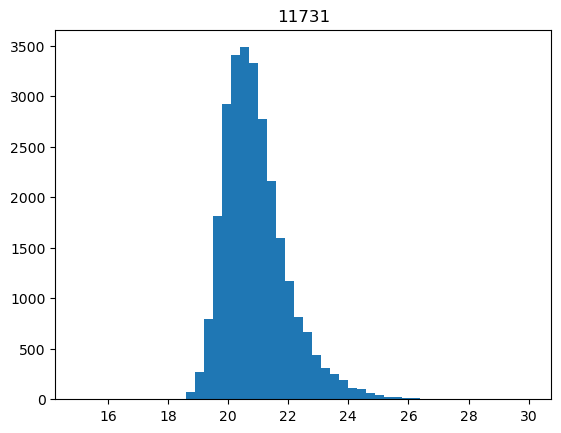

 17%|█████████████▋                                                                 | 187/1075 [00:24<01:55,  7.67it/s]

24752


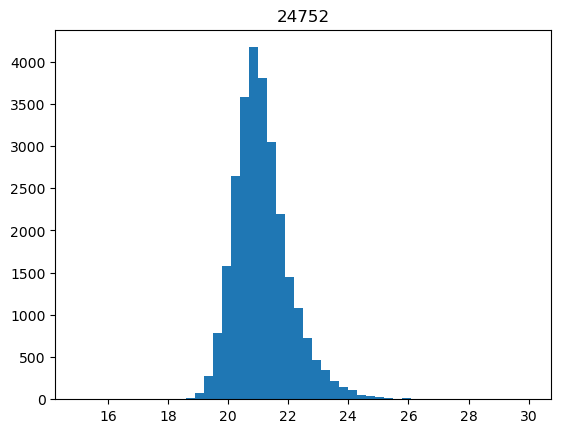

 17%|█████████████▊                                                                 | 188/1075 [00:25<01:54,  7.75it/s]

20247


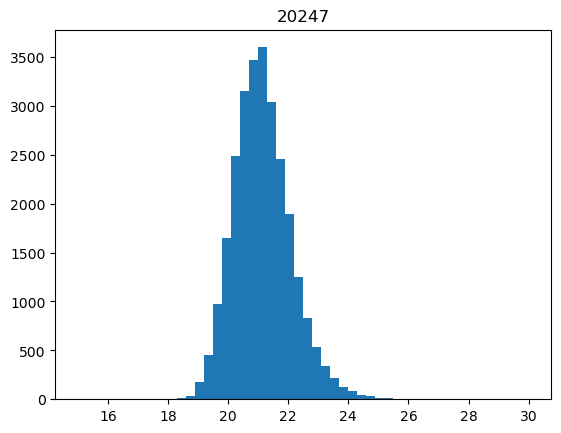

 18%|█████████████▉                                                                 | 189/1075 [00:25<01:52,  7.84it/s]

11215


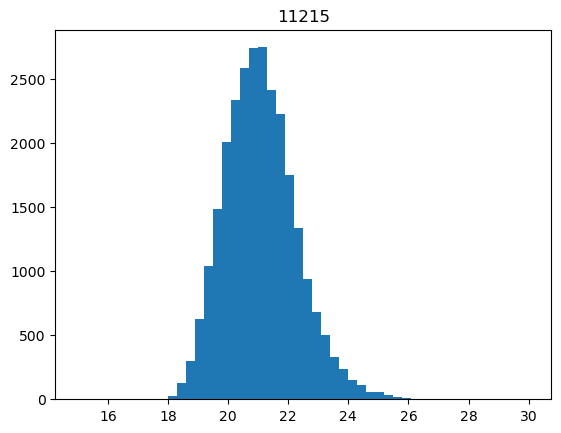

 18%|█████████████▉                                                                 | 190/1075 [00:25<01:51,  7.93it/s]

2483


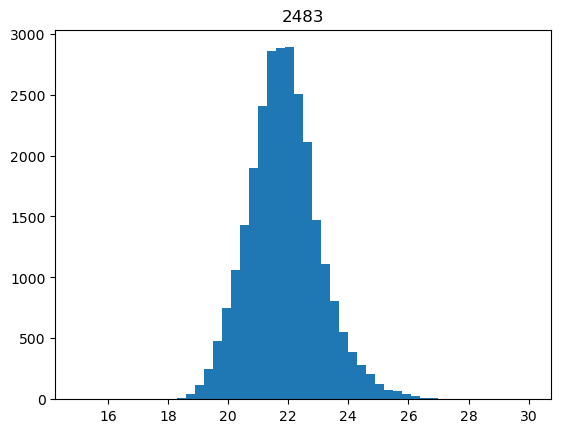

 18%|██████████████                                                                 | 191/1075 [00:25<01:52,  7.87it/s]

23989


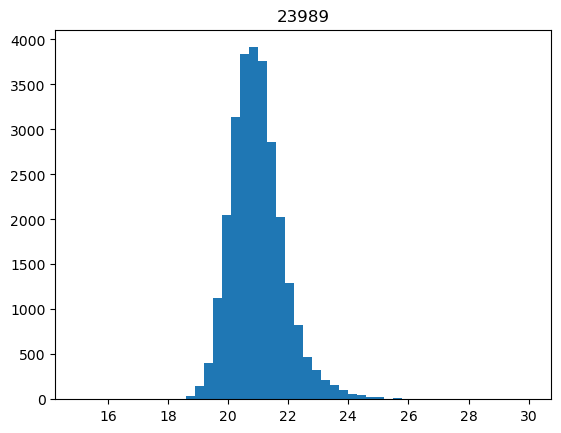

 18%|██████████████                                                                 | 192/1075 [00:25<01:52,  7.85it/s]

24240


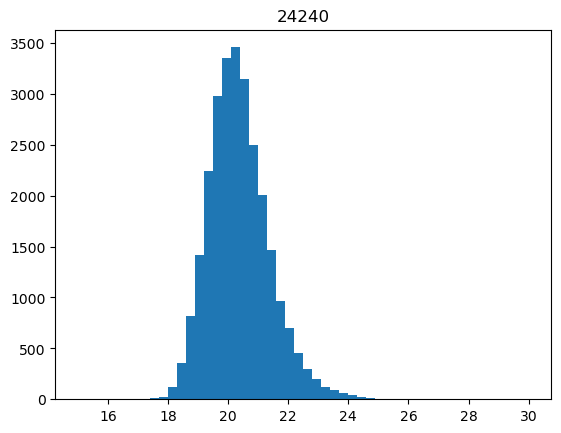

 18%|██████████████▏                                                                | 193/1075 [00:25<02:20,  6.30it/s]

9474


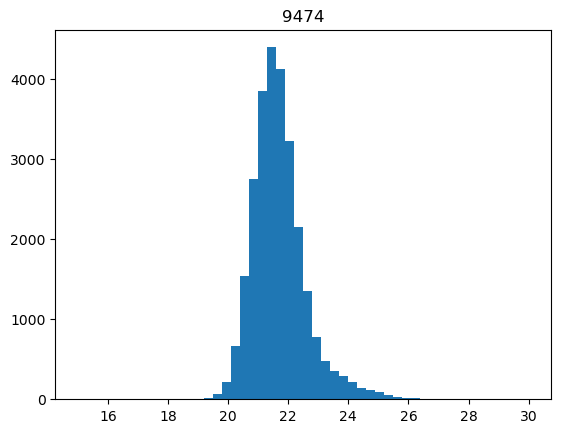

 18%|██████████████▎                                                                | 194/1075 [00:25<02:10,  6.73it/s]

5802


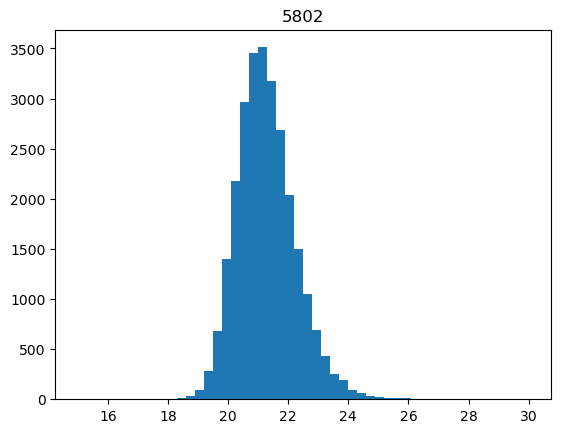

 18%|██████████████▎                                                                | 195/1075 [00:26<02:06,  6.96it/s]

16534


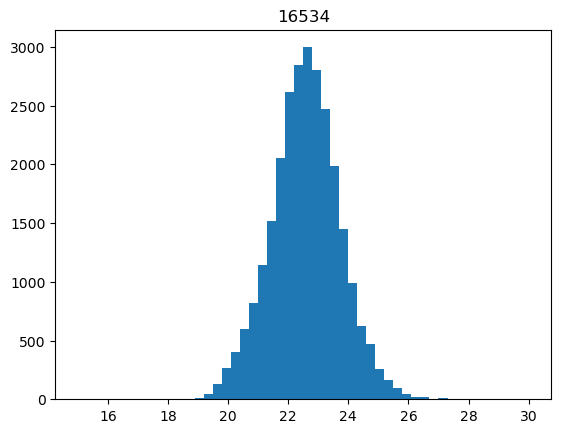

 18%|██████████████▍                                                                | 196/1075 [00:26<02:01,  7.21it/s]

19606


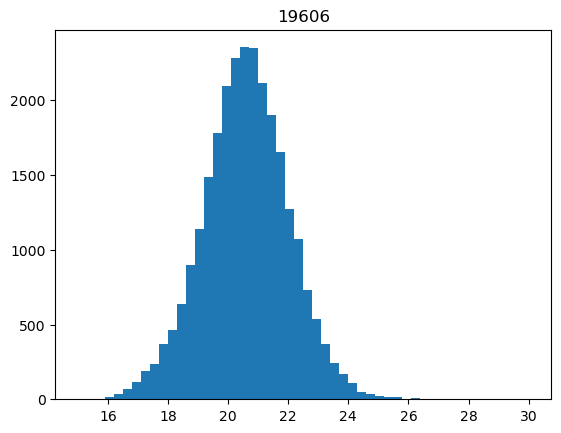

 18%|██████████████▍                                                                | 197/1075 [00:26<01:57,  7.45it/s]

19970


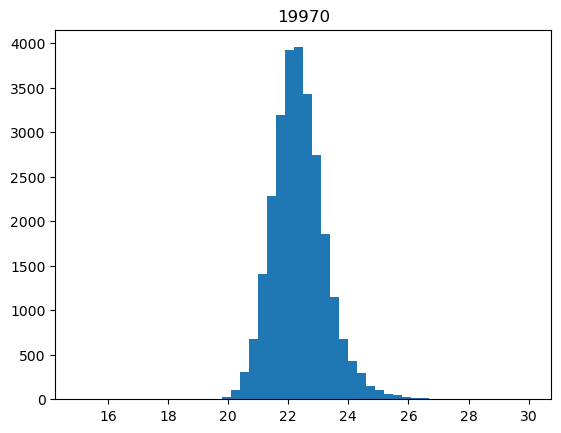

 18%|██████████████▌                                                                | 198/1075 [00:26<01:56,  7.50it/s]

6153


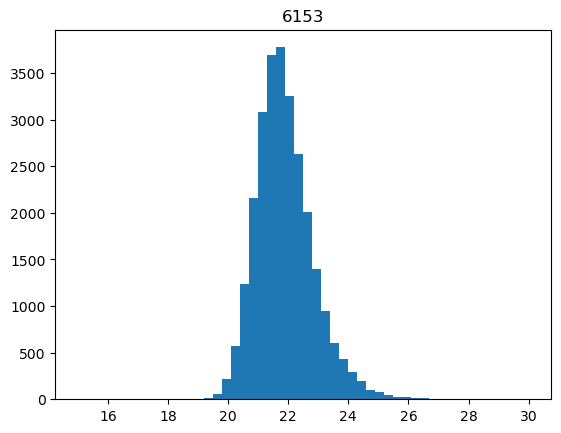

 19%|██████████████▌                                                                | 199/1075 [00:26<01:55,  7.59it/s]

13382


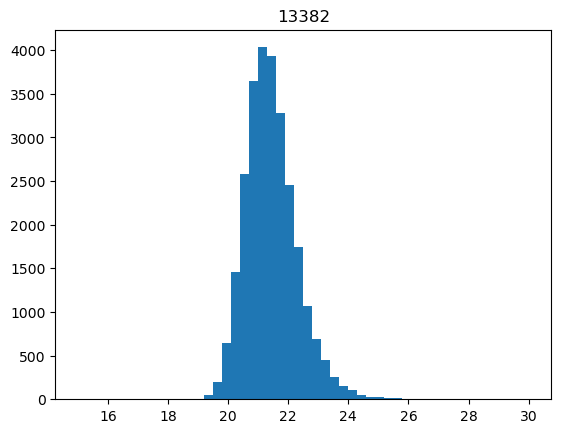

 19%|██████████████▋                                                                | 200/1075 [00:26<01:54,  7.66it/s]

337


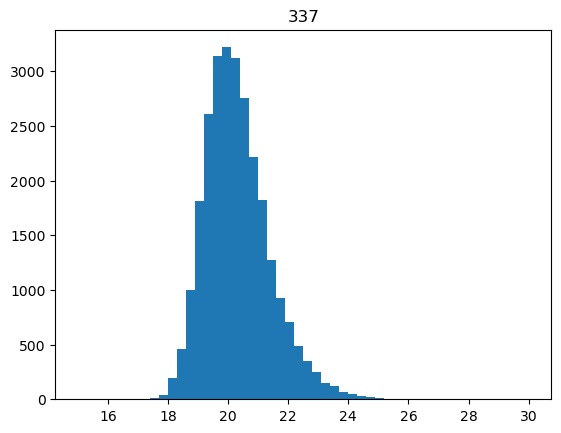

 19%|██████████████▊                                                                | 201/1075 [00:26<01:52,  7.76it/s]

4378


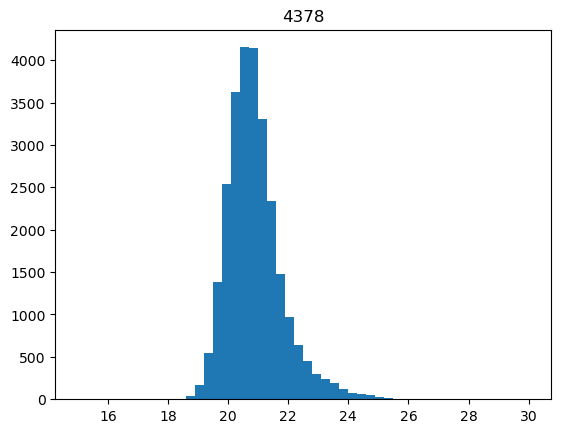

 19%|██████████████▊                                                                | 202/1075 [00:26<01:52,  7.79it/s]

2189


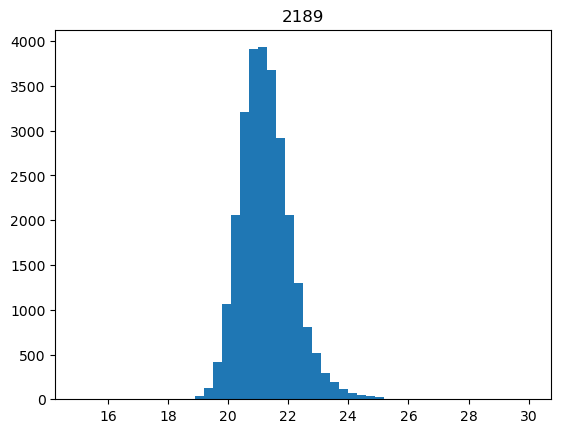

 19%|██████████████▉                                                                | 203/1075 [00:27<01:51,  7.80it/s]

11043


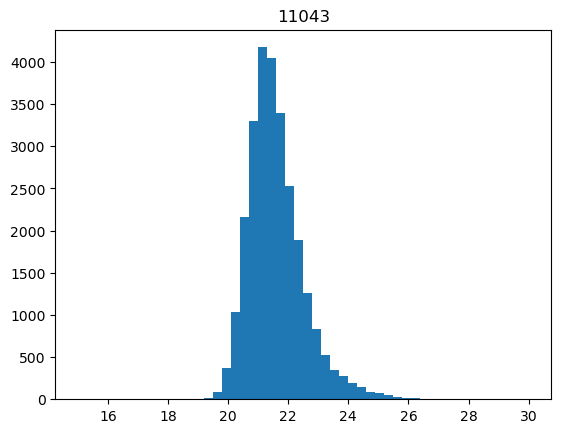

 19%|██████████████▉                                                                | 204/1075 [00:27<02:15,  6.42it/s]

5688


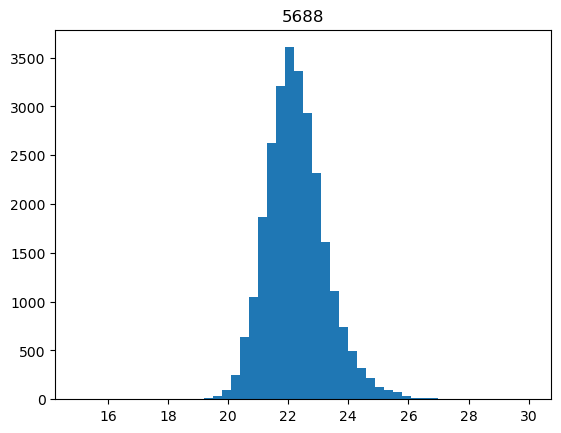

 19%|███████████████                                                                | 205/1075 [00:27<02:08,  6.75it/s]

8558


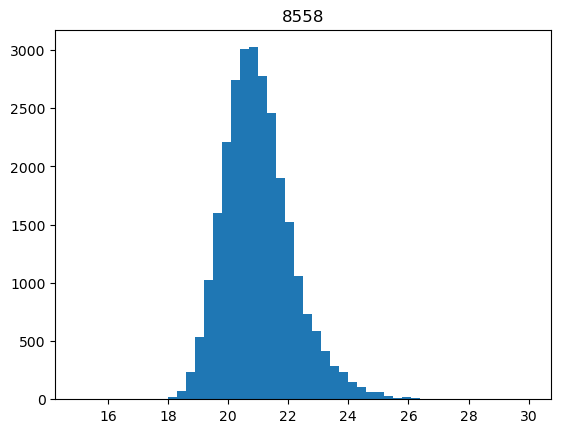

 19%|███████████████▏                                                               | 206/1075 [00:27<02:03,  7.02it/s]

58


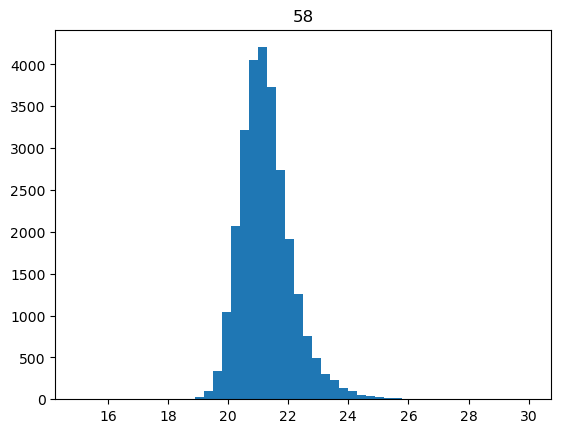

 19%|███████████████▏                                                               | 207/1075 [00:27<02:01,  7.13it/s]

4457


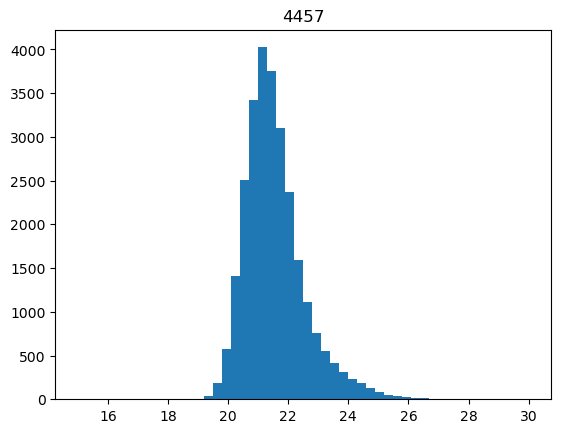

 19%|███████████████▎                                                               | 208/1075 [00:27<01:58,  7.29it/s]

1038


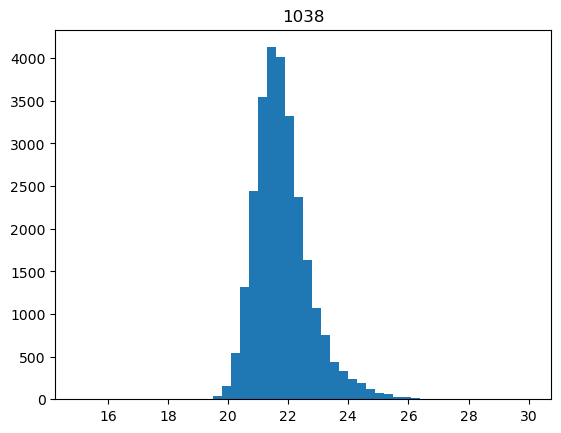

 19%|███████████████▎                                                               | 209/1075 [00:27<01:57,  7.36it/s]

6308


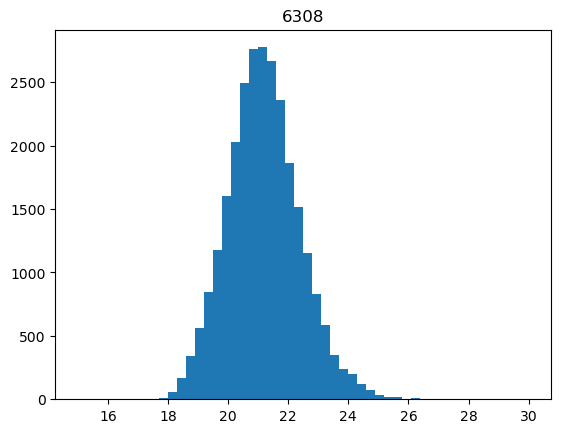

 20%|███████████████▍                                                               | 210/1075 [00:28<01:54,  7.56it/s]

19097


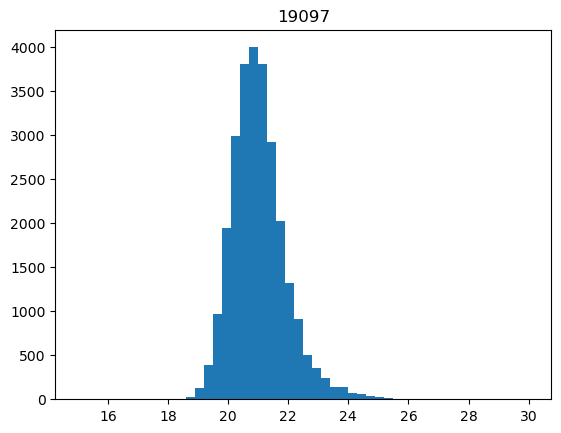

 20%|███████████████▌                                                               | 211/1075 [00:28<01:53,  7.60it/s]

1508


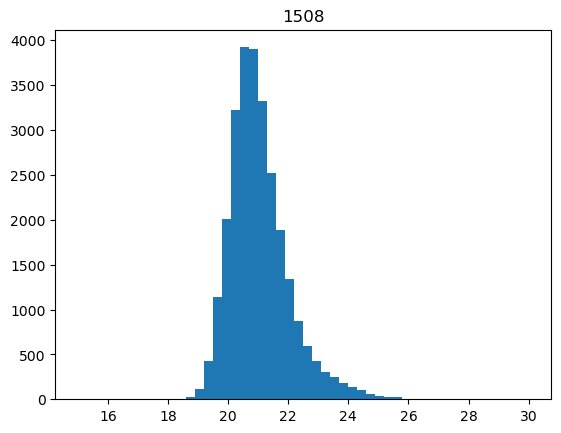

 20%|███████████████▌                                                               | 212/1075 [00:28<01:53,  7.61it/s]

1938


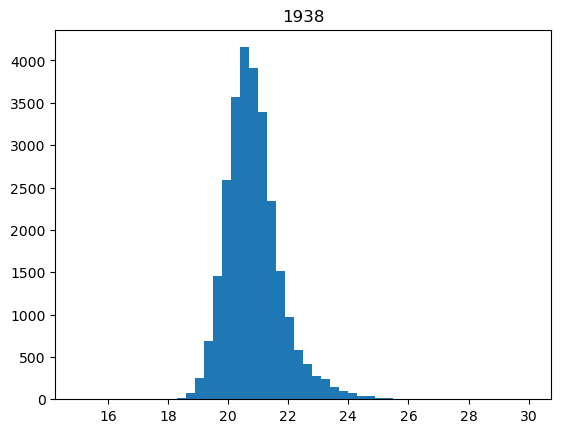

 20%|███████████████▋                                                               | 213/1075 [00:28<01:53,  7.60it/s]

1774


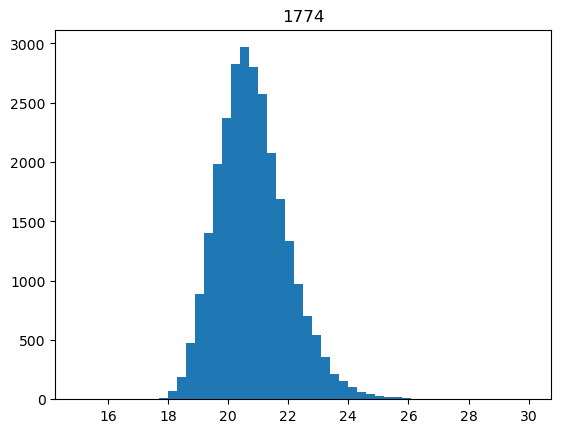

 20%|███████████████▋                                                               | 214/1075 [00:28<01:52,  7.62it/s]

1600


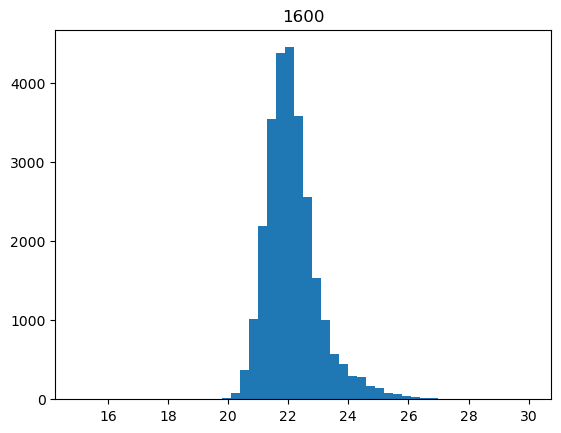

 20%|███████████████▊                                                               | 215/1075 [00:28<02:13,  6.46it/s]

6133


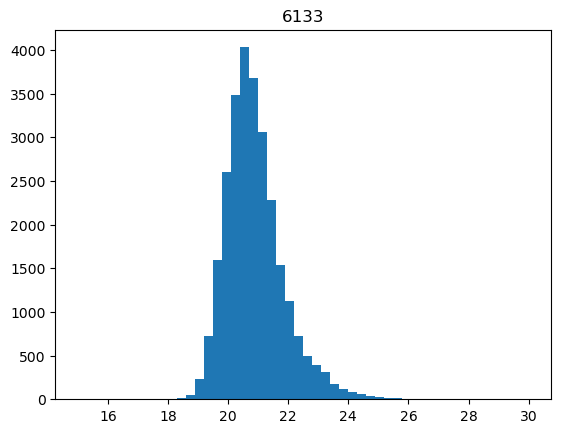

 20%|███████████████▊                                                               | 216/1075 [00:28<02:06,  6.79it/s]

21708


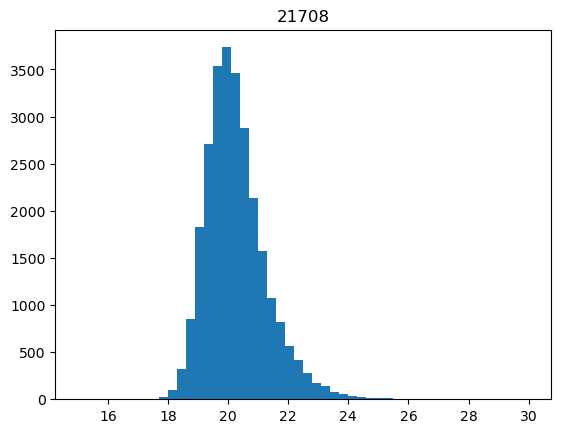

 20%|███████████████▉                                                               | 217/1075 [00:29<02:01,  7.06it/s]

18661


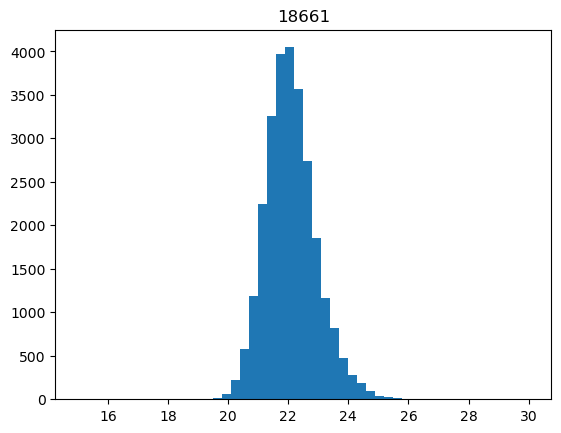

 20%|████████████████                                                               | 218/1075 [00:29<01:58,  7.26it/s]

4071


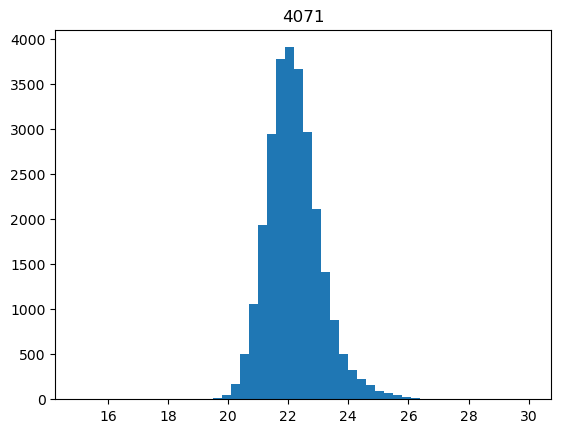

 20%|████████████████                                                               | 219/1075 [00:29<01:56,  7.35it/s]

7802


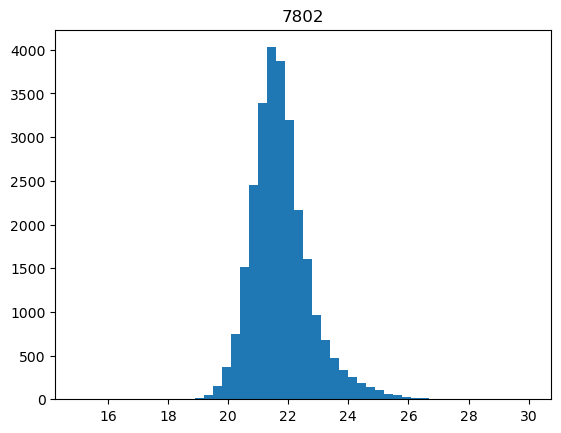

 20%|████████████████▏                                                              | 220/1075 [00:29<01:56,  7.35it/s]

6022


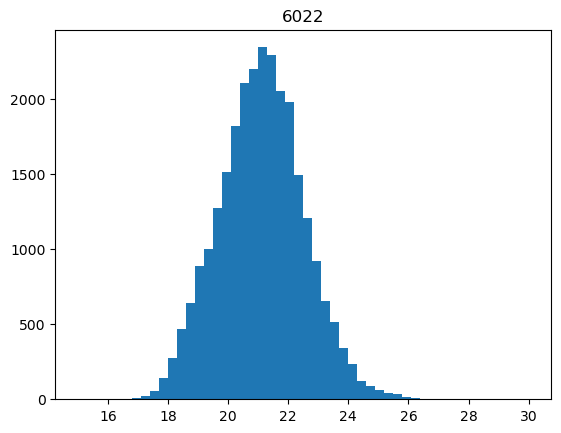

 21%|████████████████▏                                                              | 221/1075 [00:29<01:53,  7.55it/s]

15386


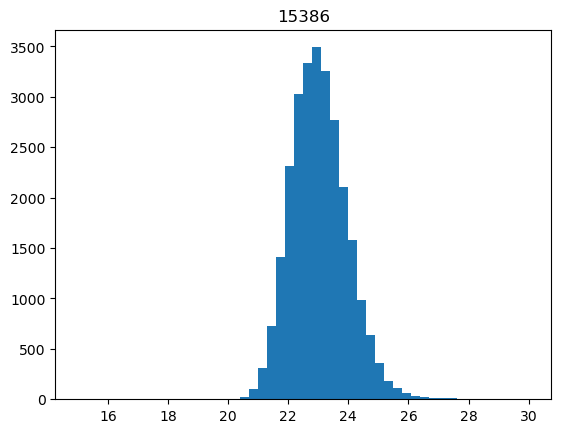

 21%|████████████████▎                                                              | 222/1075 [00:29<01:52,  7.56it/s]

8159


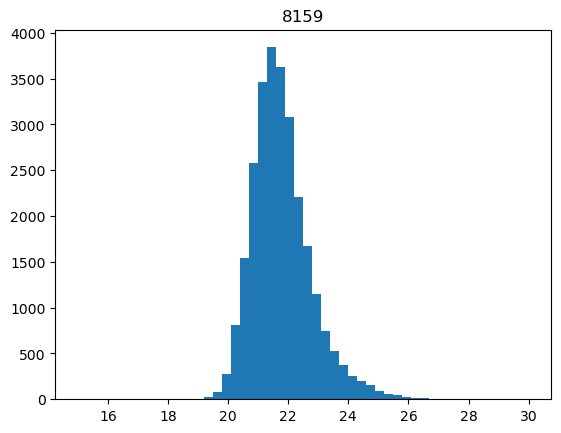

 21%|████████████████▍                                                              | 223/1075 [00:29<01:53,  7.53it/s]

6914


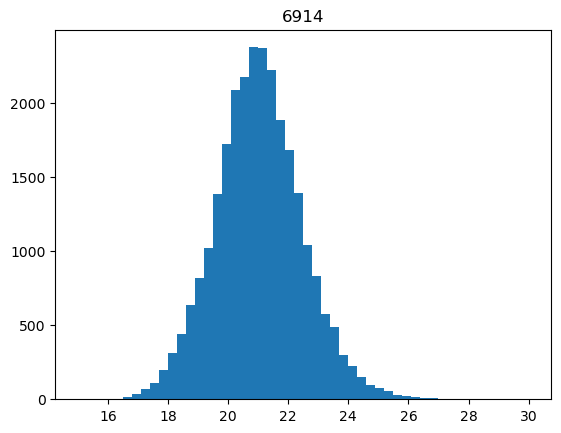

 21%|████████████████▍                                                              | 224/1075 [00:29<01:50,  7.70it/s]

3083


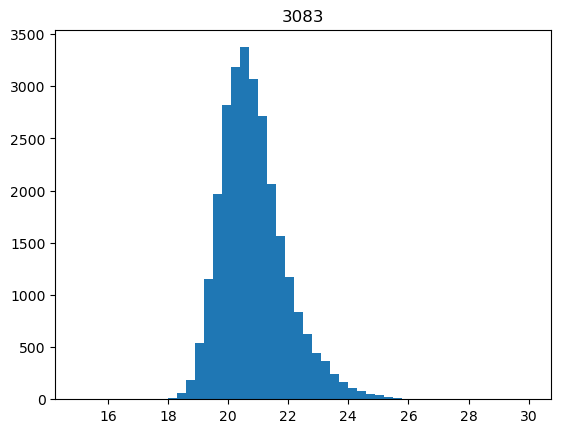

 21%|████████████████▌                                                              | 225/1075 [00:30<01:49,  7.73it/s]

2686


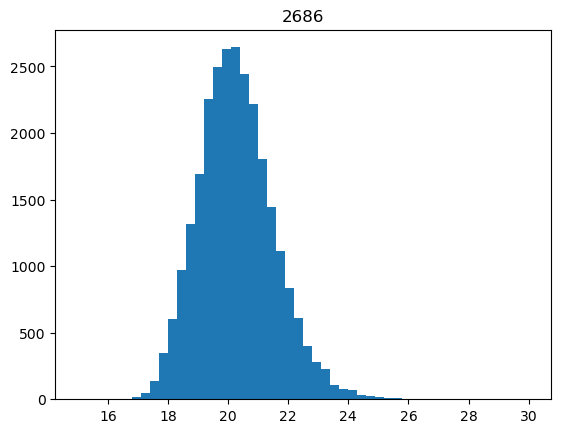

 21%|████████████████▌                                                              | 226/1075 [00:30<02:10,  6.49it/s]

3301


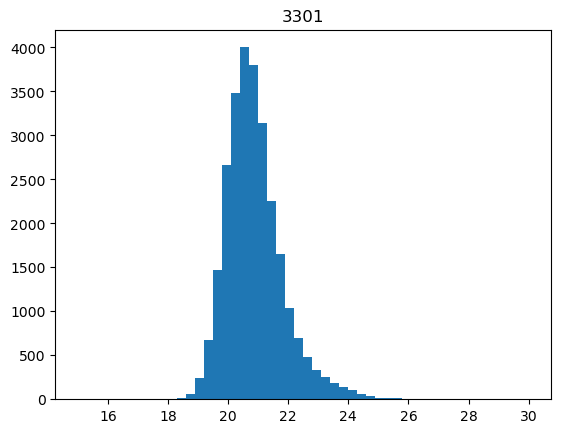

 21%|████████████████▋                                                              | 227/1075 [00:30<02:04,  6.79it/s]

23290


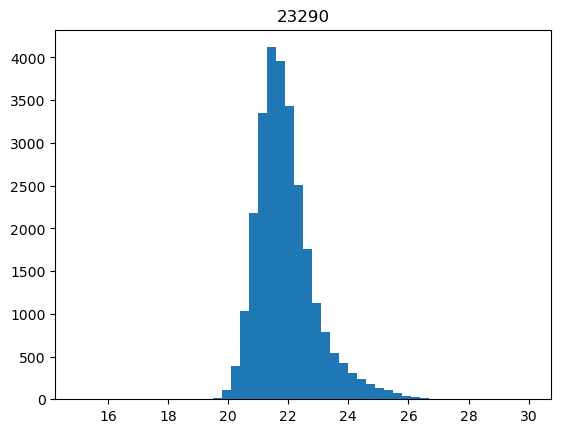

 21%|████████████████▊                                                              | 228/1075 [00:30<02:01,  7.00it/s]

7346


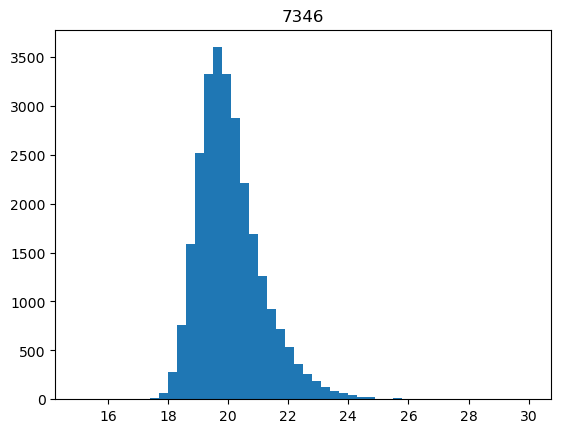

 21%|████████████████▊                                                              | 229/1075 [00:30<01:57,  7.22it/s]

9299


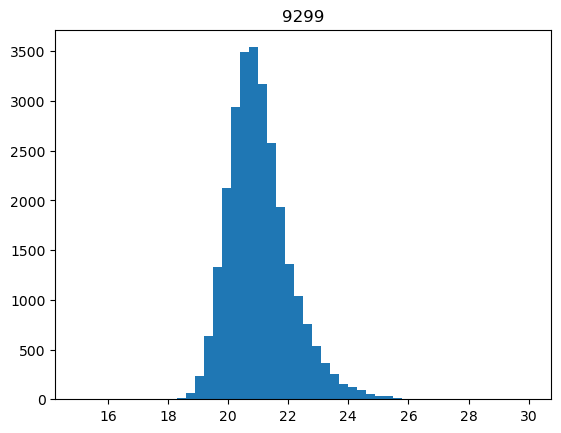

 21%|████████████████▉                                                              | 230/1075 [00:30<01:54,  7.39it/s]

13228


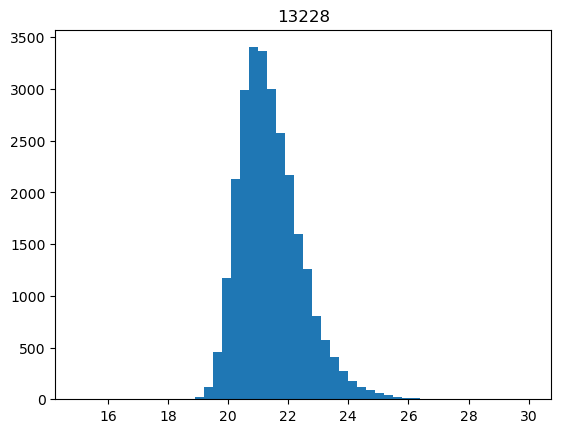

 21%|████████████████▉                                                              | 231/1075 [00:30<01:53,  7.46it/s]

7627


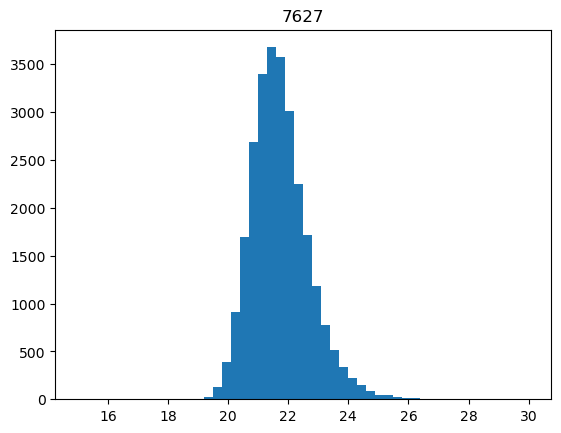

 22%|█████████████████                                                              | 232/1075 [00:31<01:51,  7.56it/s]

26742


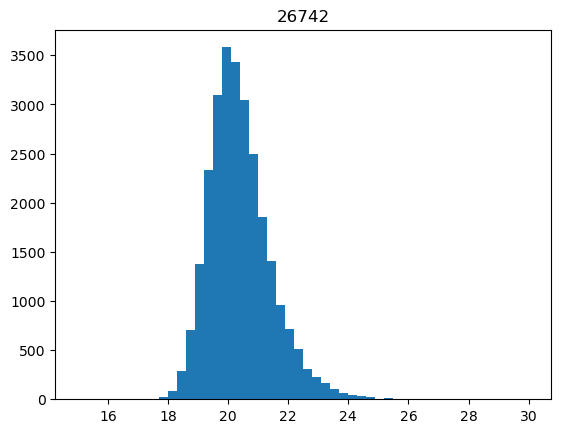

 22%|█████████████████                                                              | 233/1075 [00:31<01:49,  7.67it/s]

20545


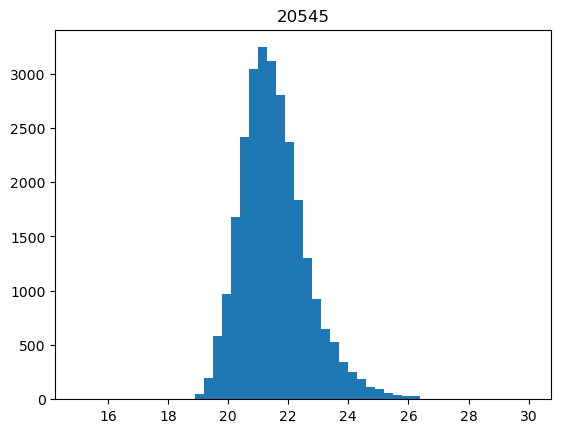

 22%|█████████████████▏                                                             | 234/1075 [00:31<01:48,  7.77it/s]

6235


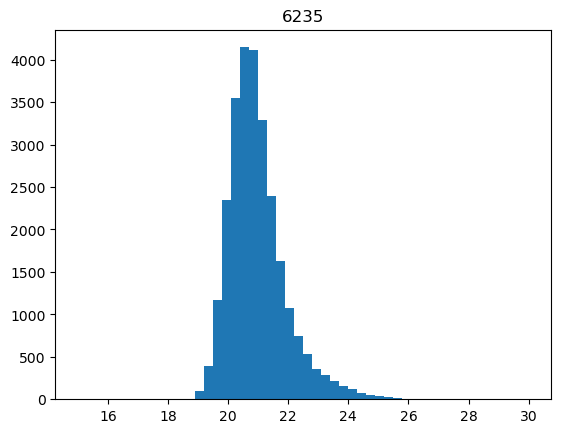

 22%|█████████████████▎                                                             | 235/1075 [00:31<01:49,  7.67it/s]

16693


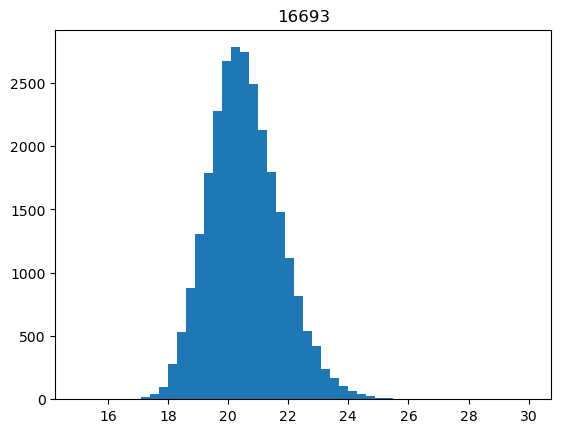

 22%|█████████████████▎                                                             | 236/1075 [00:31<01:48,  7.71it/s]

14568


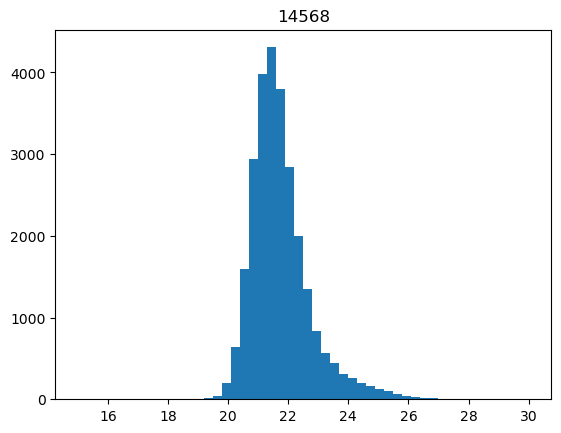

 22%|█████████████████▍                                                             | 237/1075 [00:31<02:07,  6.58it/s]

14914


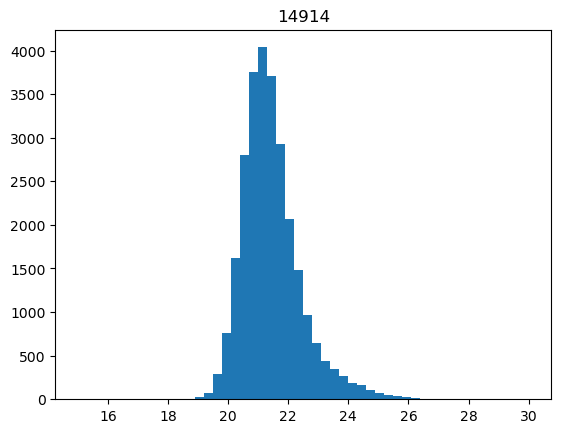

 22%|█████████████████▍                                                             | 238/1075 [00:31<02:02,  6.84it/s]

3286


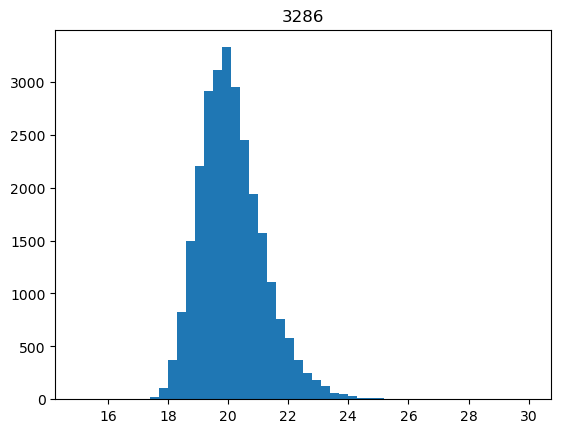

 22%|█████████████████▌                                                             | 239/1075 [00:32<01:58,  7.07it/s]

20254


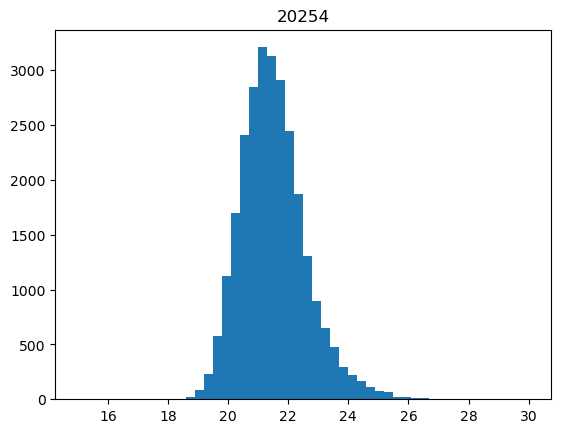

 22%|█████████████████▋                                                             | 240/1075 [00:32<01:53,  7.33it/s]

1444


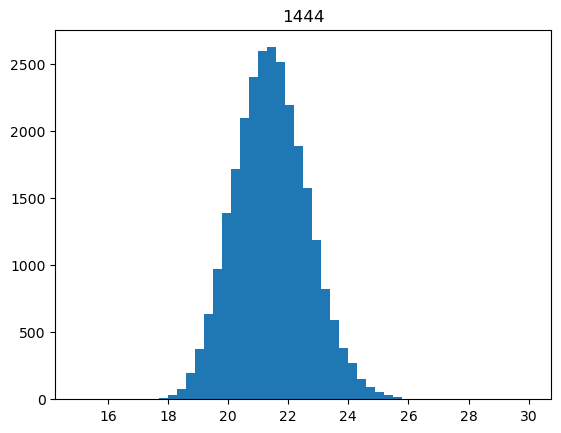

 22%|█████████████████▋                                                             | 241/1075 [00:32<01:51,  7.50it/s]

21371


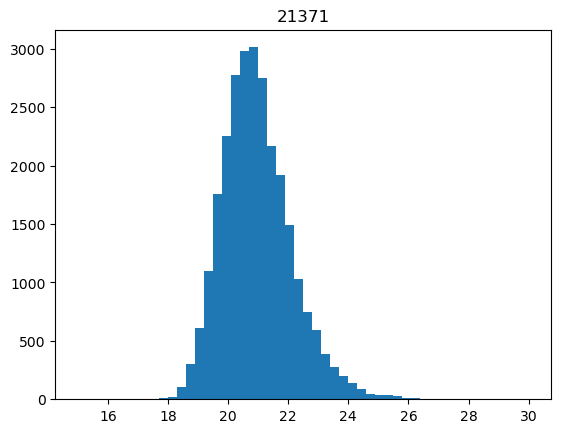

 23%|█████████████████▊                                                             | 242/1075 [00:32<01:50,  7.56it/s]

20487


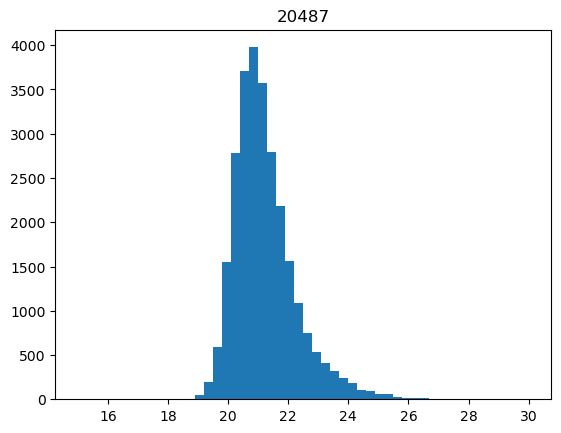

 23%|█████████████████▊                                                             | 243/1075 [00:32<01:49,  7.58it/s]

24383


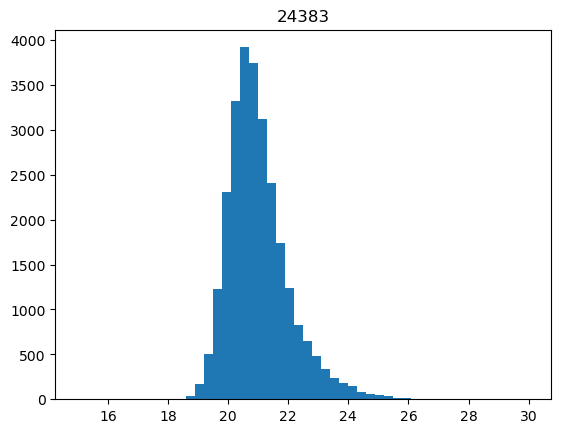

 23%|█████████████████▉                                                             | 244/1075 [00:32<01:50,  7.54it/s]

6755


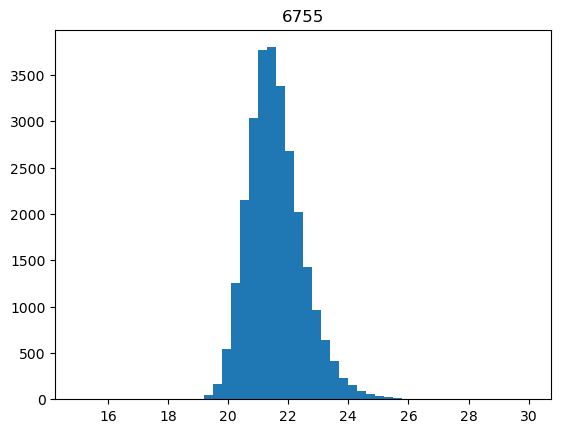

 23%|██████████████████                                                             | 245/1075 [00:32<01:48,  7.64it/s]

18040


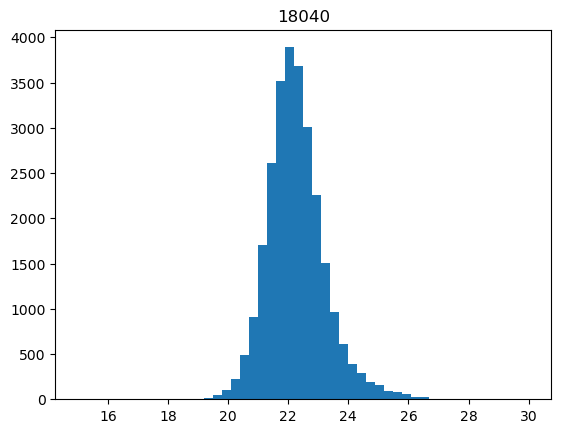

 23%|██████████████████                                                             | 246/1075 [00:32<01:48,  7.67it/s]

3179


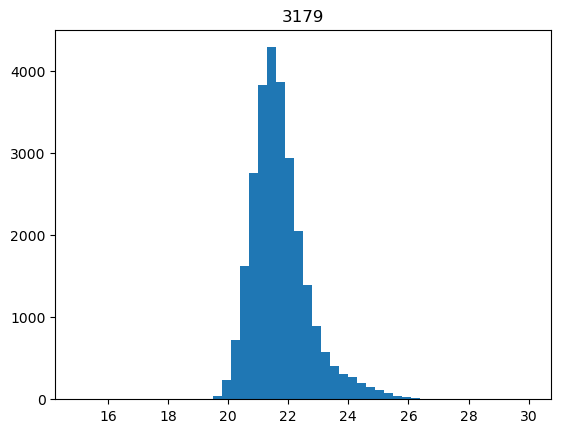

 23%|██████████████████▏                                                            | 247/1075 [00:33<01:47,  7.71it/s]

1761


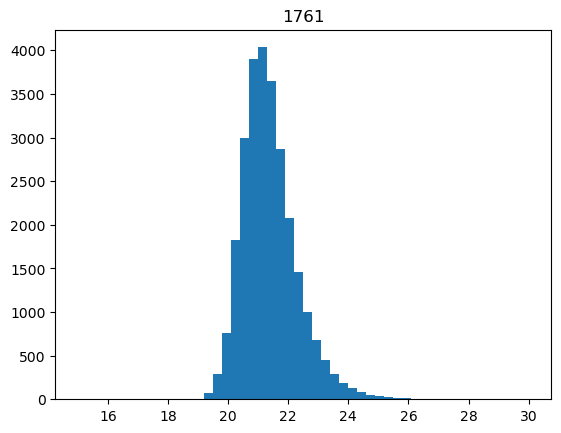

 23%|██████████████████▏                                                            | 248/1075 [00:33<02:09,  6.37it/s]

20053


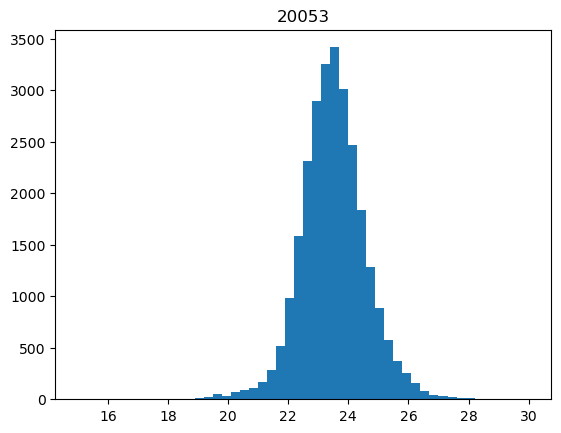

 23%|██████████████████▎                                                            | 249/1075 [00:33<02:01,  6.78it/s]

19036


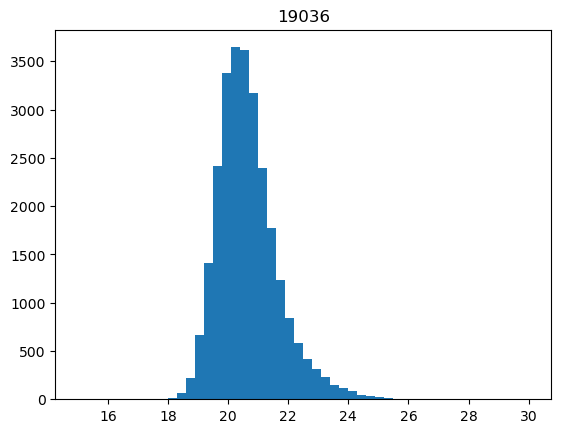

 23%|██████████████████▎                                                            | 250/1075 [00:33<01:56,  7.11it/s]

10538


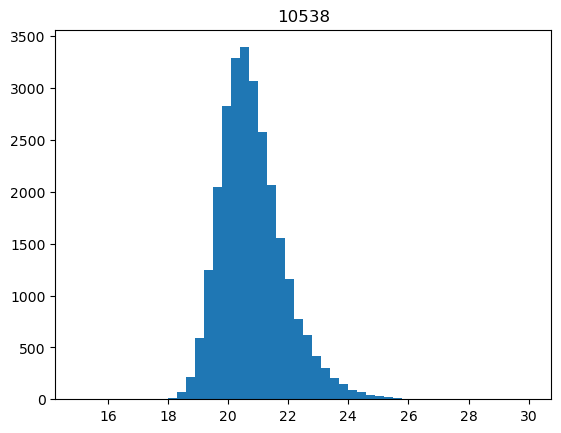

 23%|██████████████████▍                                                            | 251/1075 [00:33<01:52,  7.34it/s]

25410


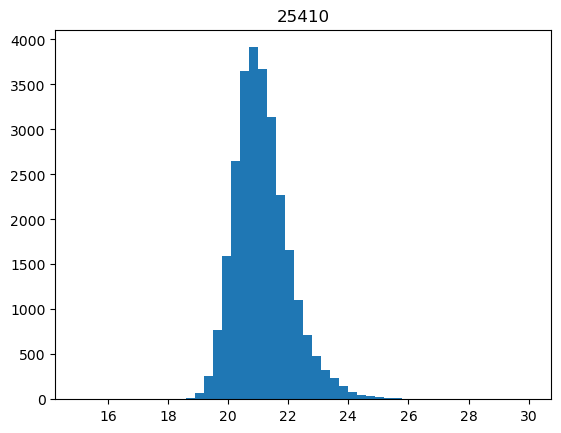

 23%|██████████████████▌                                                            | 252/1075 [00:33<01:50,  7.46it/s]

15132


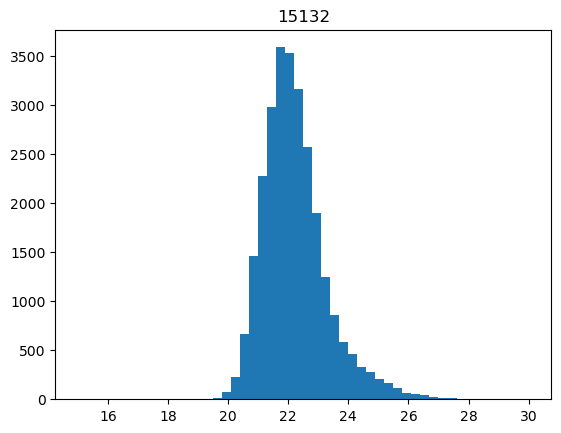

 24%|██████████████████▌                                                            | 253/1075 [00:33<01:48,  7.54it/s]

23235


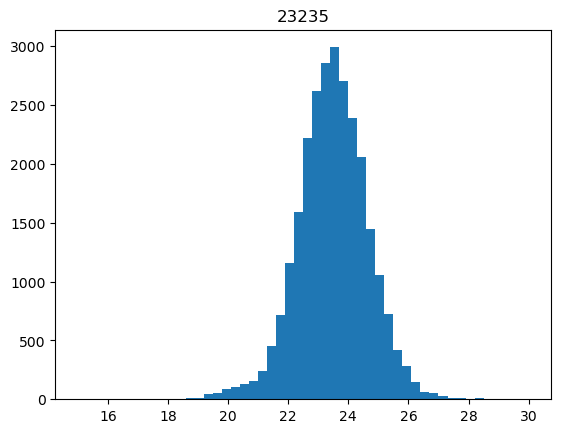

 24%|██████████████████▋                                                            | 254/1075 [00:34<01:47,  7.60it/s]

19335


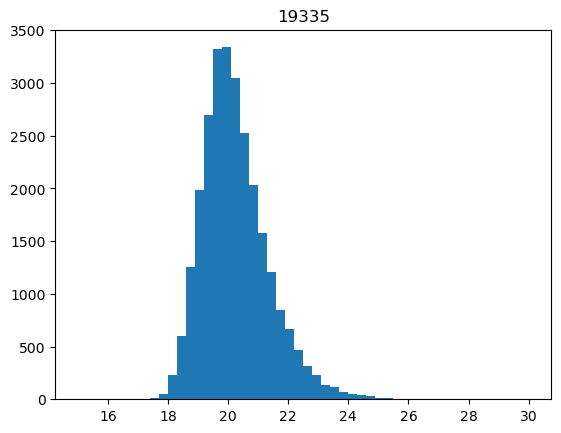

 24%|██████████████████▋                                                            | 255/1075 [00:34<01:46,  7.74it/s]

23952


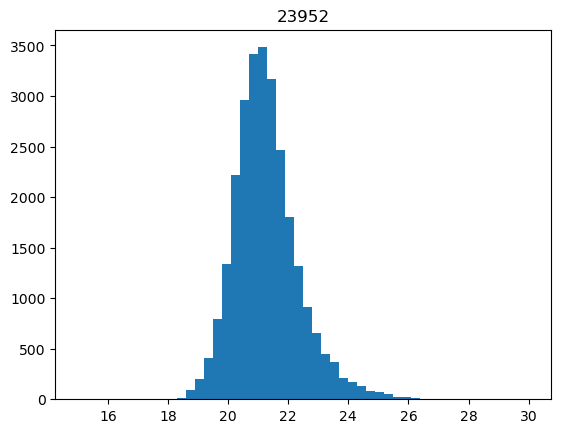

 24%|██████████████████▊                                                            | 256/1075 [00:34<01:45,  7.79it/s]

14355


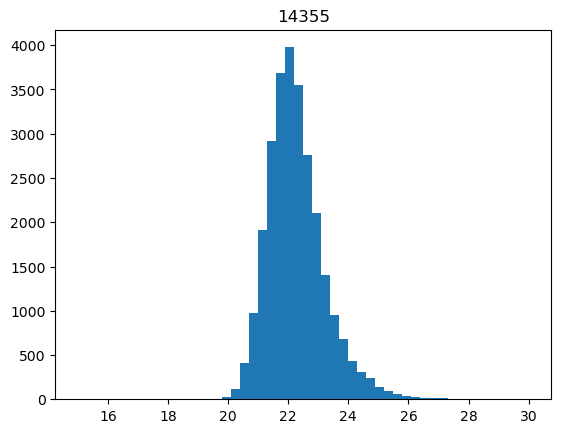

 24%|██████████████████▉                                                            | 257/1075 [00:34<01:46,  7.69it/s]

26513


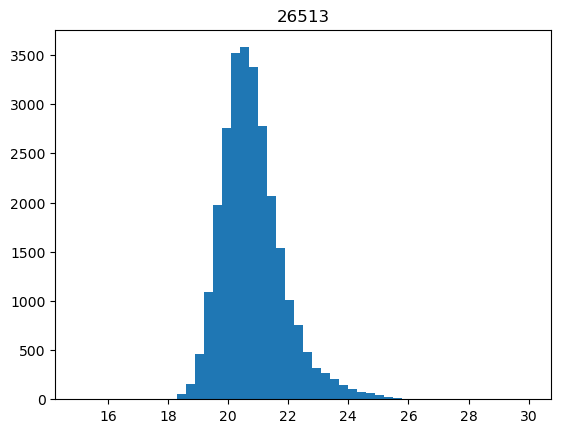

 24%|██████████████████▉                                                            | 258/1075 [00:34<01:45,  7.71it/s]

19918


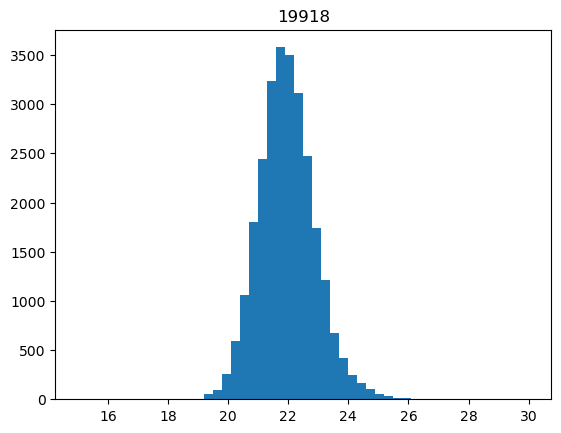

 24%|███████████████████                                                            | 259/1075 [00:34<02:05,  6.51it/s]

131


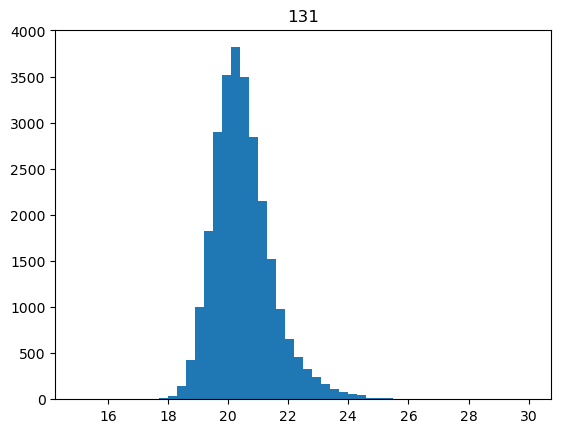

 24%|███████████████████                                                            | 260/1075 [00:34<02:00,  6.74it/s]

20981


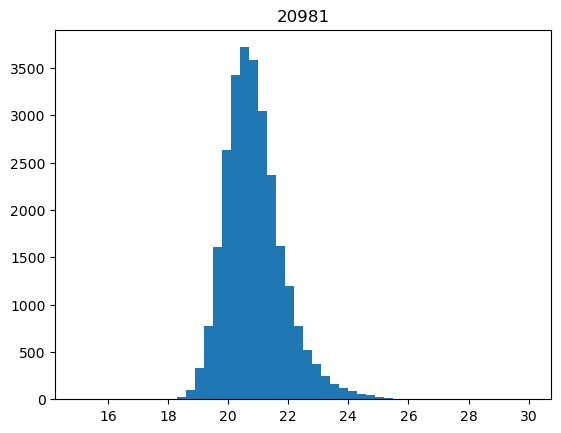

 24%|███████████████████▏                                                           | 261/1075 [00:35<01:56,  6.99it/s]

24144


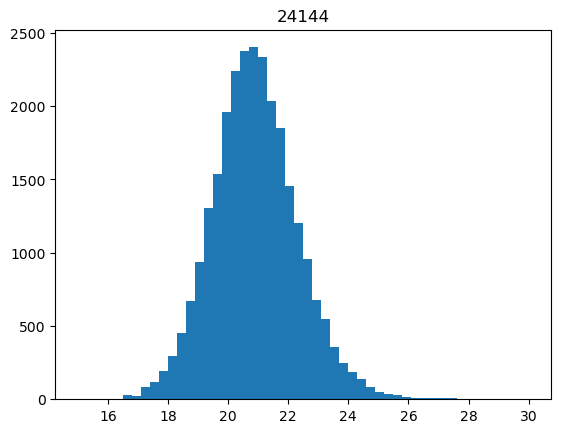

 24%|███████████████████▎                                                           | 262/1075 [00:35<01:52,  7.25it/s]

22207


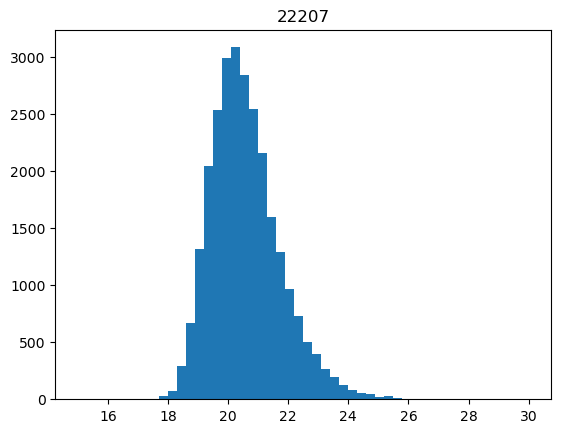

 24%|███████████████████▎                                                           | 263/1075 [00:35<01:49,  7.44it/s]

1058


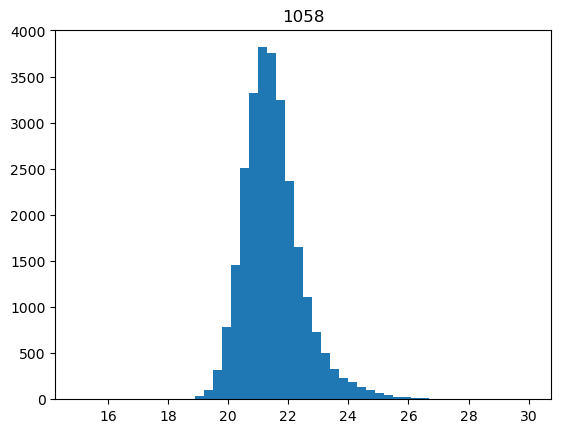

 25%|███████████████████▍                                                           | 264/1075 [00:35<01:47,  7.55it/s]

19498


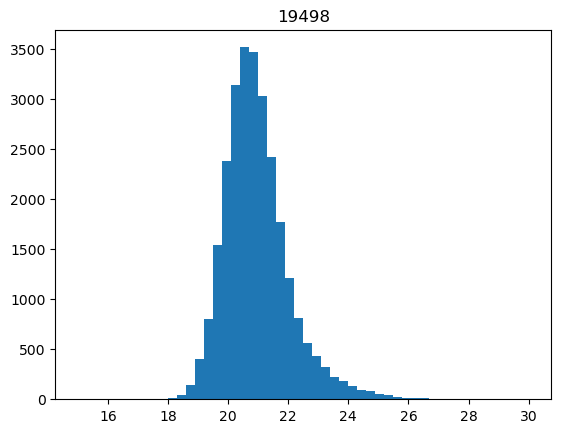

 25%|███████████████████▍                                                           | 265/1075 [00:35<01:45,  7.66it/s]

9417


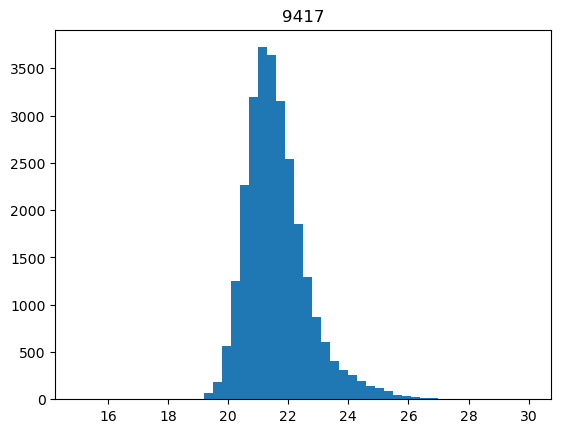

 25%|███████████████████▌                                                           | 266/1075 [00:35<01:45,  7.67it/s]

16163


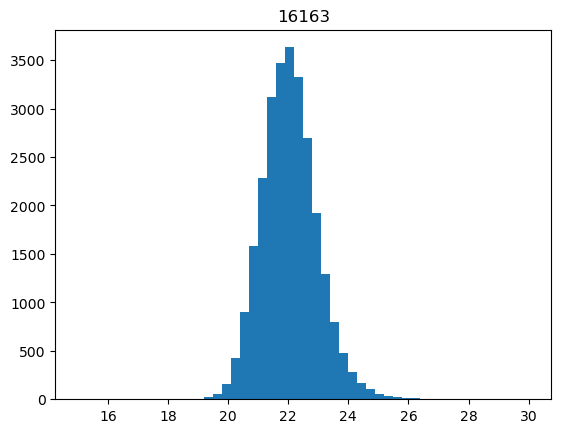

 25%|███████████████████▌                                                           | 267/1075 [00:35<01:45,  7.64it/s]

10020


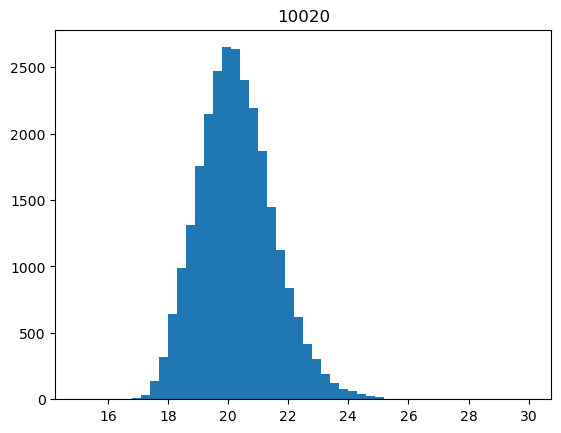

 25%|███████████████████▋                                                           | 268/1075 [00:35<01:43,  7.78it/s]

16935


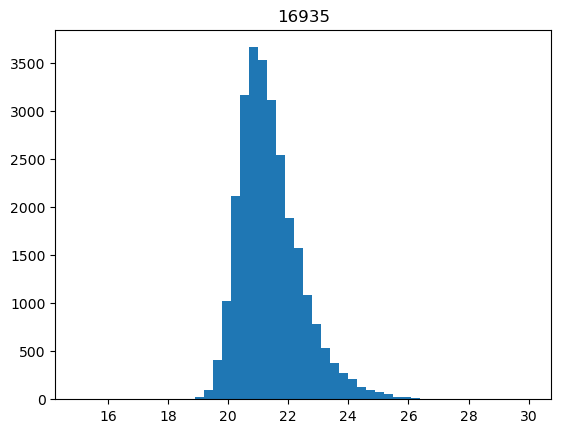

 25%|███████████████████▊                                                           | 269/1075 [00:36<01:42,  7.84it/s]

22781


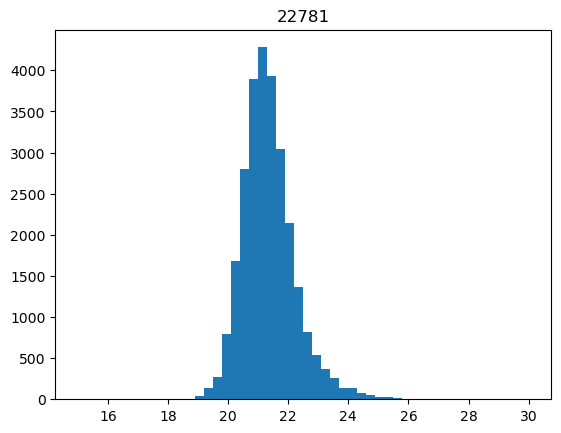

 25%|███████████████████▊                                                           | 270/1075 [00:36<02:02,  6.56it/s]

1109


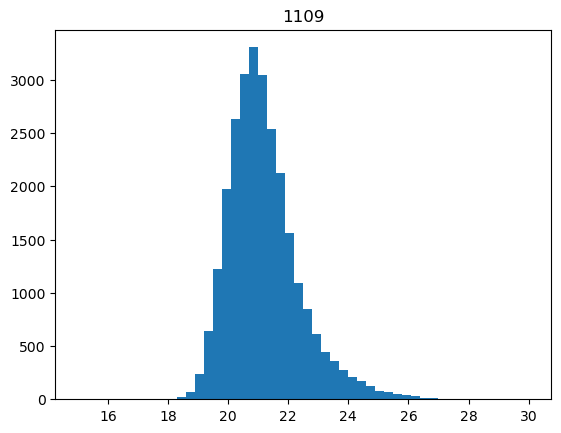

 25%|███████████████████▉                                                           | 271/1075 [00:36<01:56,  6.92it/s]

23072


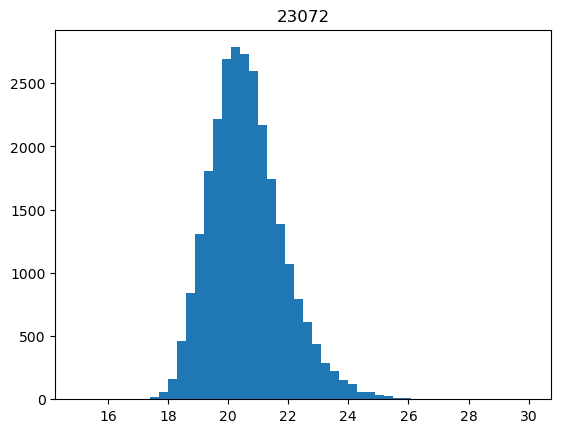

 25%|███████████████████▉                                                           | 272/1075 [00:36<01:51,  7.18it/s]

10186


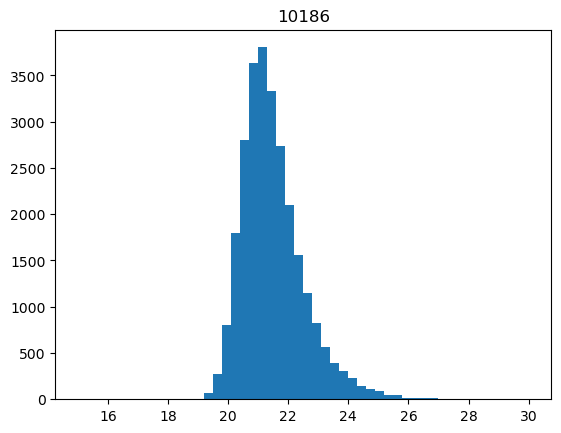

 25%|████████████████████                                                           | 273/1075 [00:36<01:49,  7.36it/s]

10241


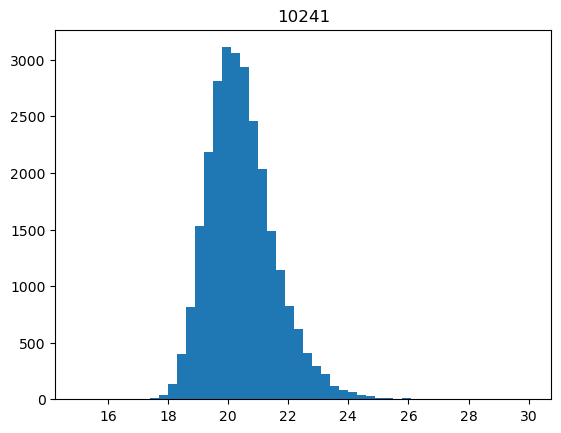

 25%|████████████████████▏                                                          | 274/1075 [00:36<01:46,  7.54it/s]

3633


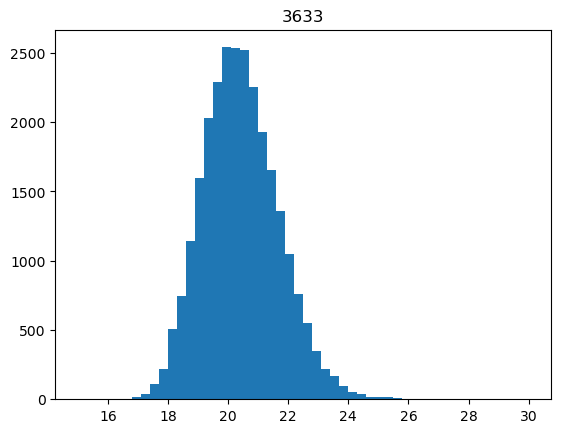

 26%|████████████████████▏                                                          | 275/1075 [00:36<01:43,  7.71it/s]

4626


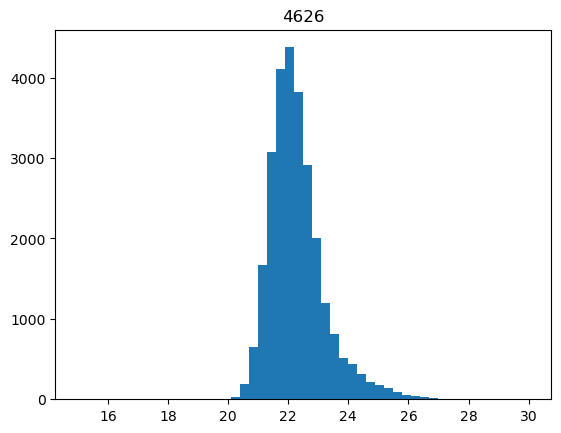

 26%|████████████████████▎                                                          | 276/1075 [00:37<01:42,  7.79it/s]

26420


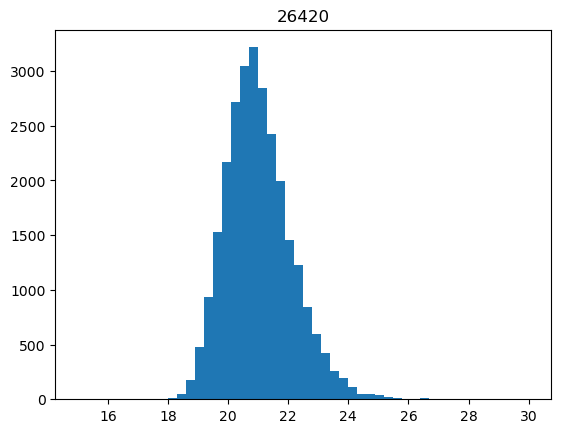

 26%|████████████████████▎                                                          | 277/1075 [00:37<01:42,  7.76it/s]

13338


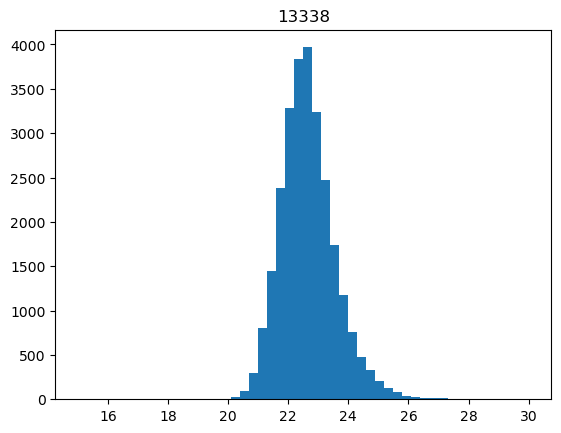

 26%|████████████████████▍                                                          | 278/1075 [00:37<01:42,  7.74it/s]

5402


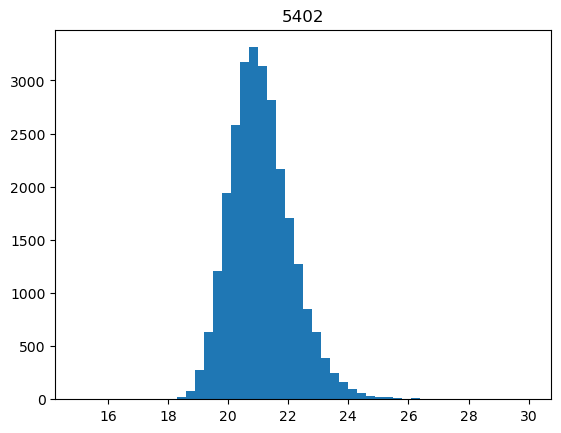

 26%|████████████████████▌                                                          | 279/1075 [00:37<01:42,  7.76it/s]

4655


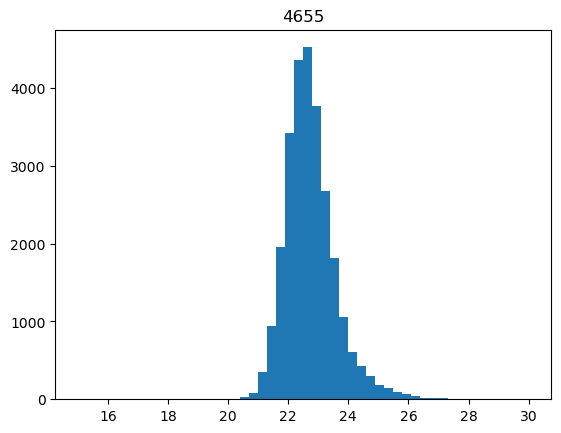

 26%|████████████████████▌                                                          | 280/1075 [00:37<01:40,  7.89it/s]

5115


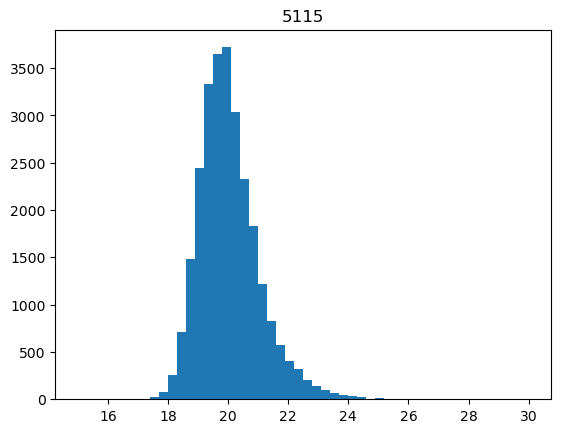

 26%|████████████████████▋                                                          | 281/1075 [00:37<02:03,  6.42it/s]

22499


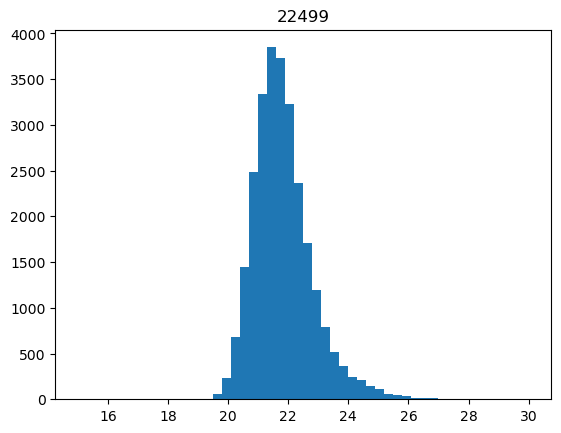

 26%|████████████████████▋                                                          | 282/1075 [00:37<01:56,  6.80it/s]

8767


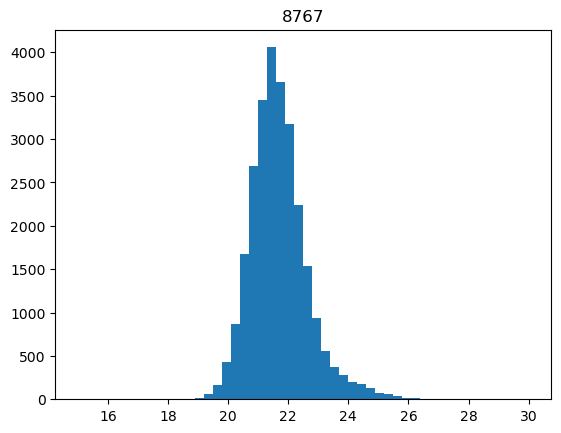

 26%|████████████████████▊                                                          | 283/1075 [00:38<01:53,  7.00it/s]

7954


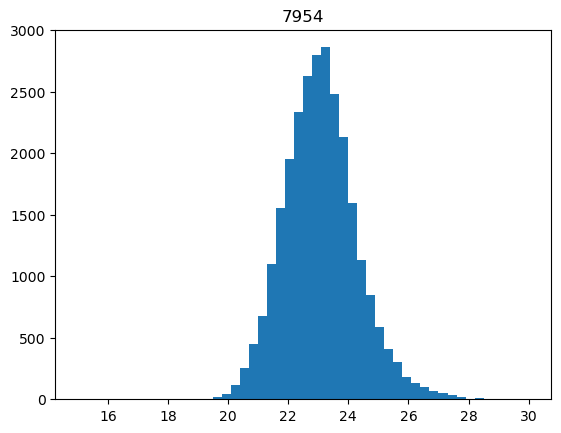

 26%|████████████████████▊                                                          | 284/1075 [00:38<01:49,  7.21it/s]

17184


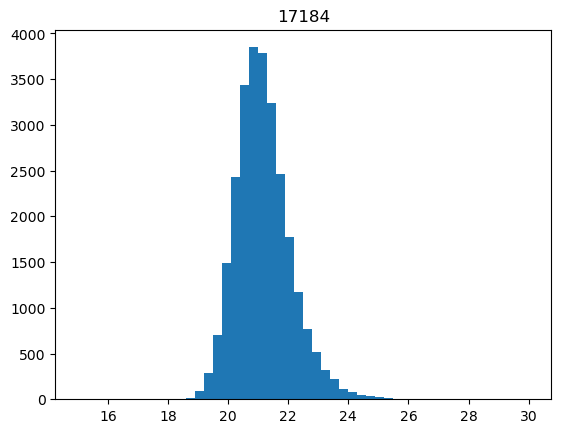

 27%|████████████████████▉                                                          | 285/1075 [00:38<01:47,  7.36it/s]

16501


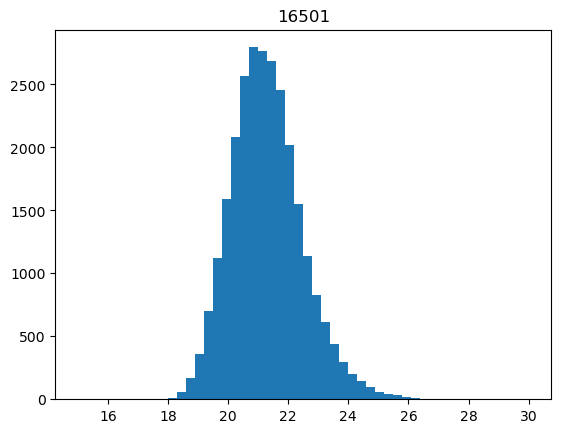

 27%|█████████████████████                                                          | 286/1075 [00:38<01:44,  7.53it/s]

9286


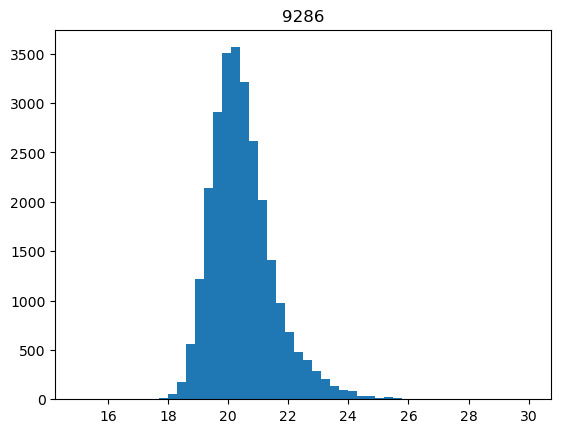

 27%|█████████████████████                                                          | 287/1075 [00:38<01:44,  7.56it/s]

3557


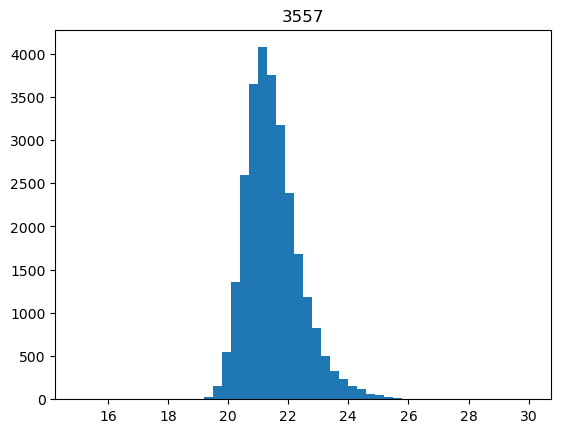

 27%|█████████████████████▏                                                         | 288/1075 [00:38<01:43,  7.60it/s]

4048


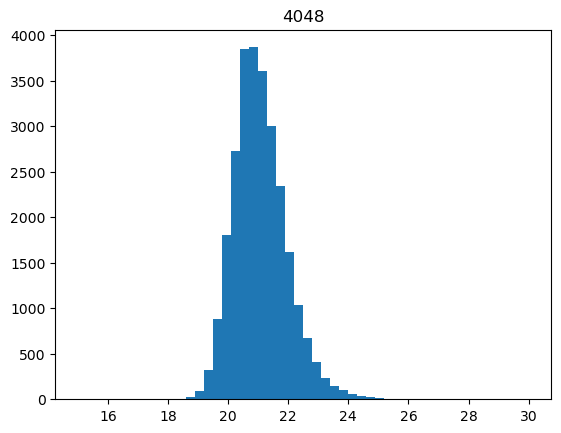

 27%|█████████████████████▏                                                         | 289/1075 [00:38<01:42,  7.64it/s]

22815


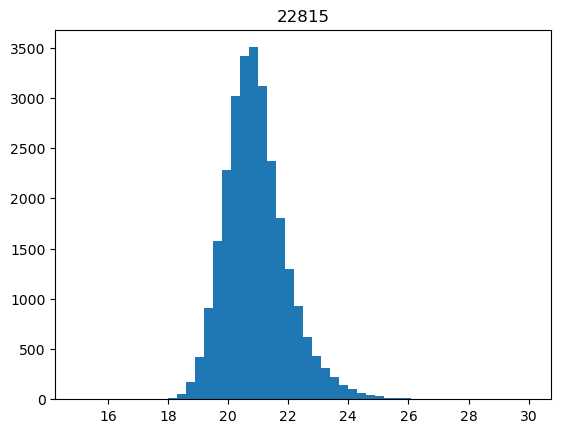

 27%|█████████████████████▎                                                         | 290/1075 [00:38<01:42,  7.64it/s]

25478


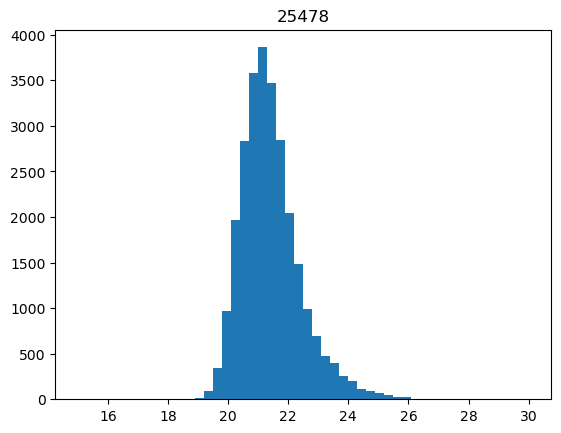

 27%|█████████████████████▍                                                         | 291/1075 [00:39<01:43,  7.58it/s]

22151


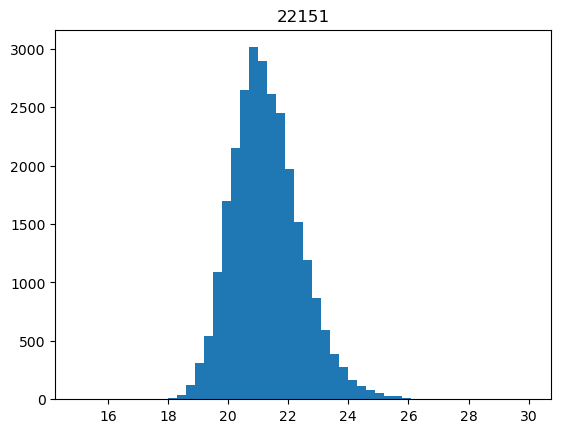

 27%|█████████████████████▍                                                         | 292/1075 [00:39<02:01,  6.45it/s]

10354


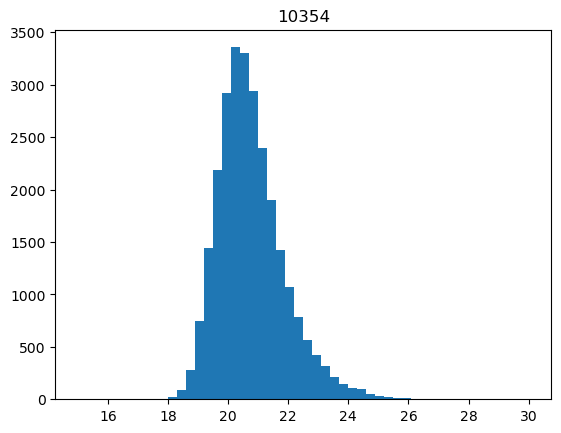

 27%|█████████████████████▌                                                         | 293/1075 [00:39<01:54,  6.81it/s]

22299


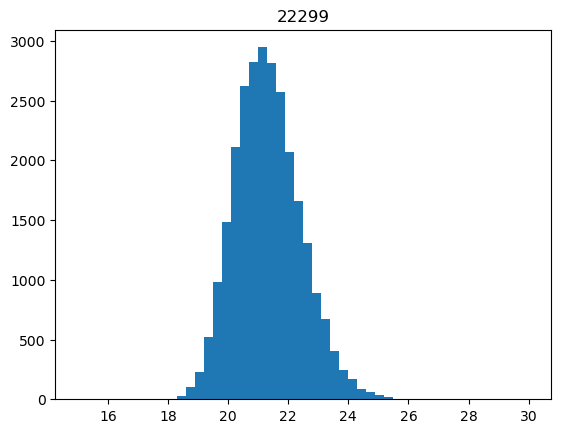

 27%|█████████████████████▌                                                         | 294/1075 [00:39<01:51,  7.01it/s]

10706


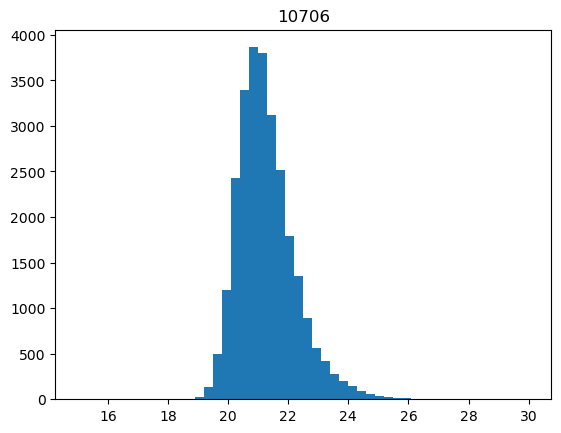

 27%|█████████████████████▋                                                         | 295/1075 [00:39<01:49,  7.11it/s]

19887


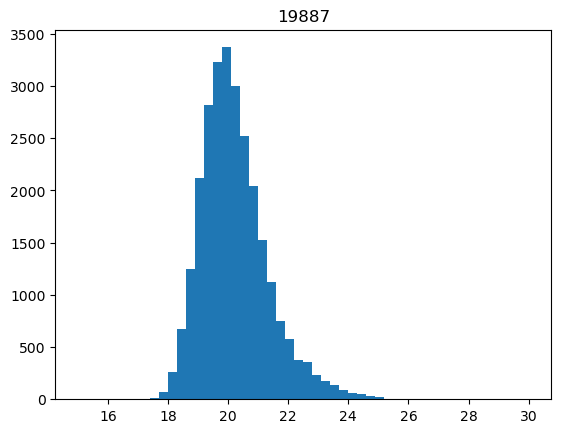

 28%|█████████████████████▊                                                         | 296/1075 [00:39<01:48,  7.19it/s]

7391


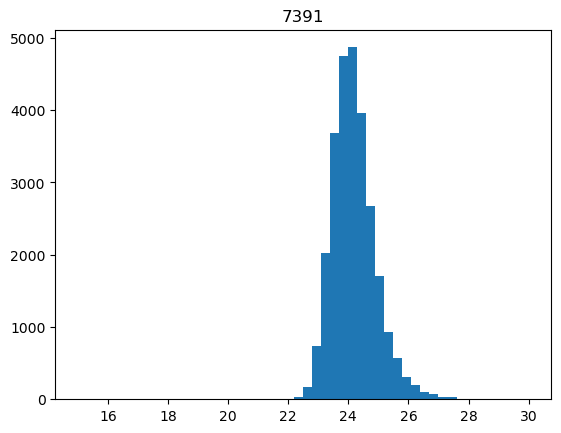

 28%|█████████████████████▊                                                         | 297/1075 [00:39<01:45,  7.37it/s]

88


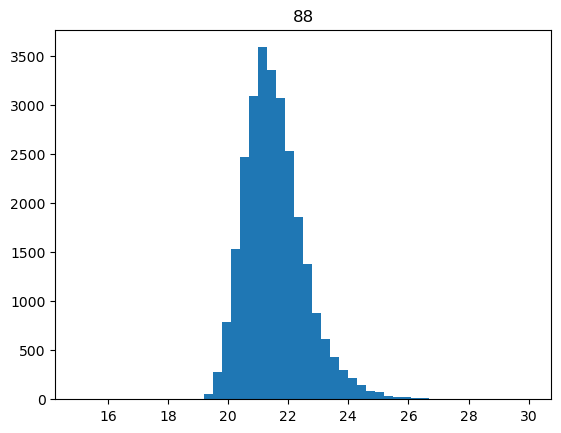

 28%|█████████████████████▉                                                         | 298/1075 [00:40<01:44,  7.46it/s]

7059


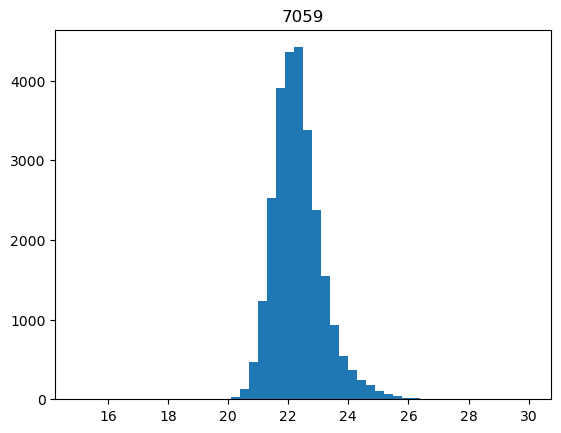

 28%|█████████████████████▉                                                         | 299/1075 [00:40<01:41,  7.67it/s]

1288


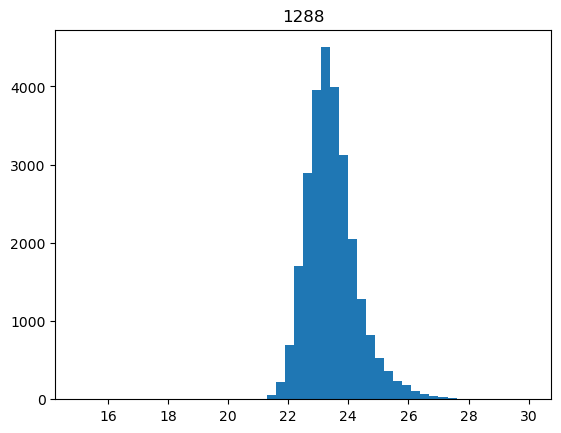

 28%|██████████████████████                                                         | 300/1075 [00:40<01:39,  7.78it/s]

26012


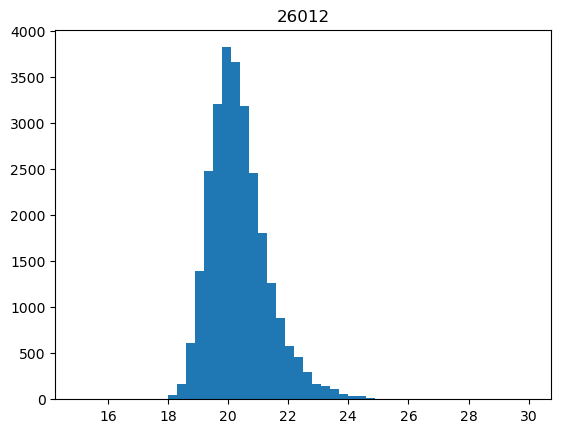

 28%|██████████████████████                                                         | 301/1075 [00:40<01:42,  7.53it/s]

9334


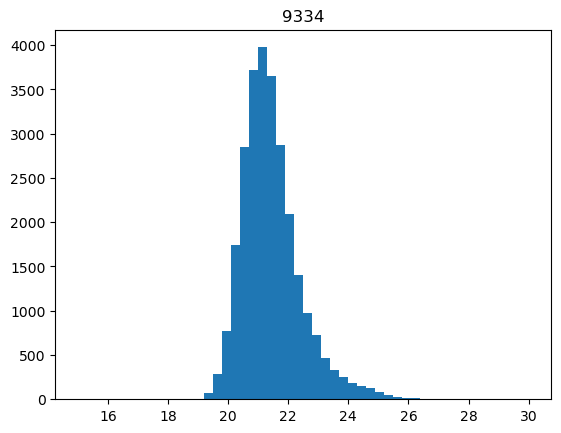

 28%|██████████████████████▏                                                        | 302/1075 [00:40<01:42,  7.52it/s]

3639


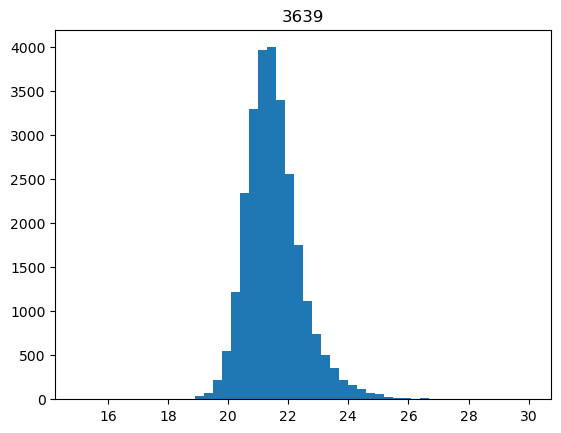

 28%|██████████████████████▎                                                        | 303/1075 [00:40<02:03,  6.25it/s]

16212


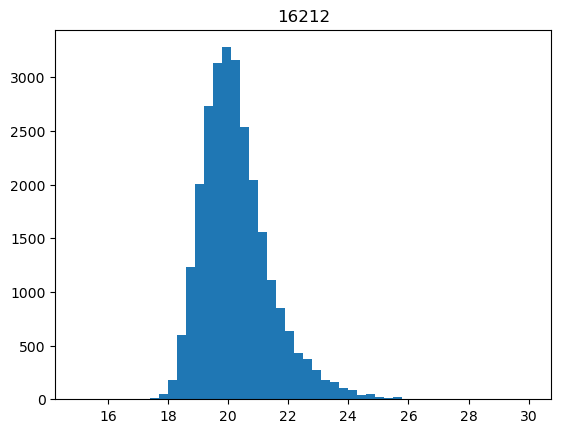

 28%|██████████████████████▎                                                        | 304/1075 [00:40<01:56,  6.60it/s]

24832


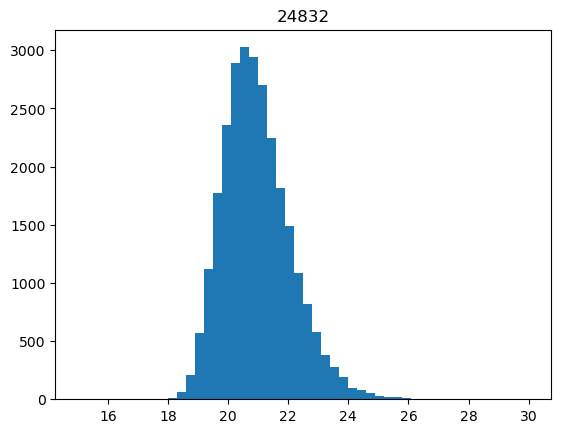

 28%|██████████████████████▍                                                        | 305/1075 [00:41<01:50,  6.95it/s]

5024


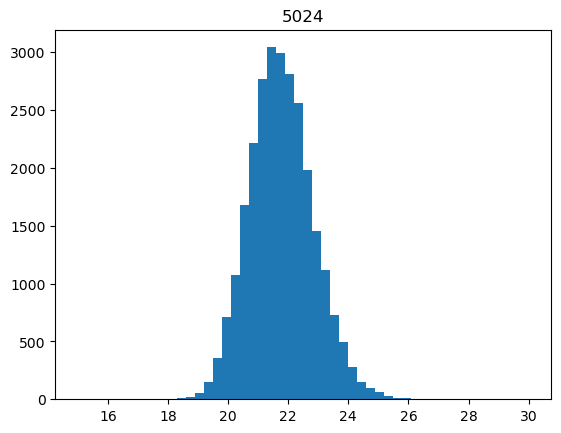

 28%|██████████████████████▍                                                        | 306/1075 [00:41<01:46,  7.22it/s]

4808


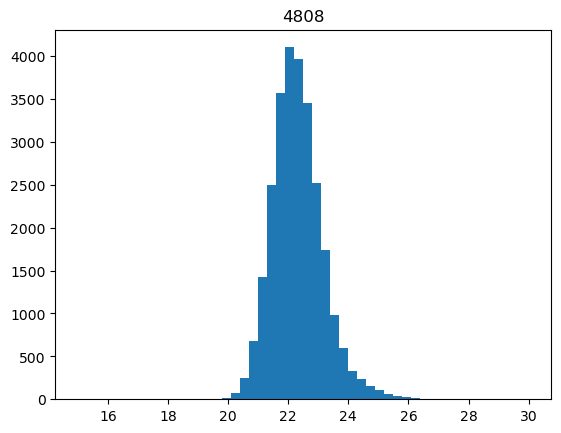

 29%|██████████████████████▌                                                        | 307/1075 [00:41<01:43,  7.39it/s]

15350


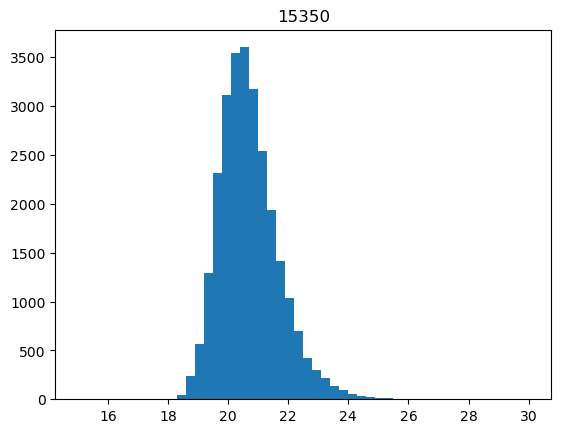

 29%|██████████████████████▋                                                        | 308/1075 [00:41<01:42,  7.51it/s]

2725


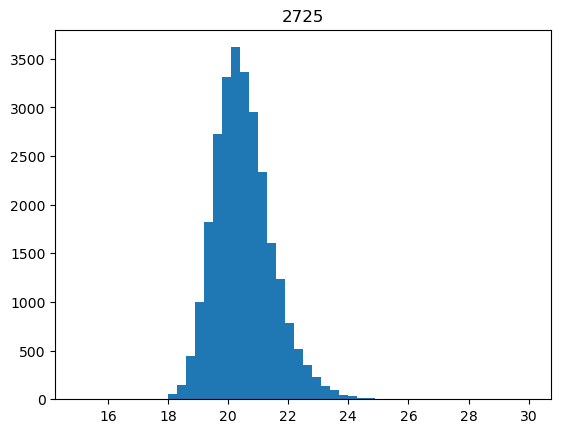

 29%|██████████████████████▋                                                        | 309/1075 [00:41<01:41,  7.56it/s]

23948


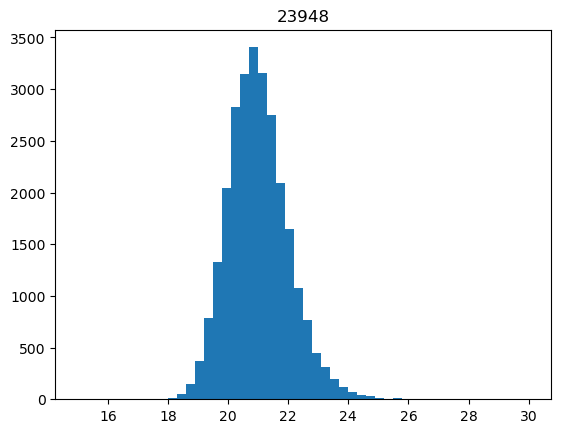

 29%|██████████████████████▊                                                        | 310/1075 [00:41<01:39,  7.69it/s]

15711


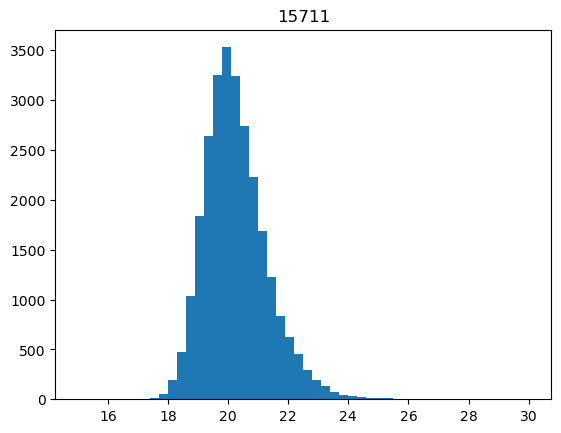

 29%|██████████████████████▊                                                        | 311/1075 [00:41<01:38,  7.78it/s]

21990


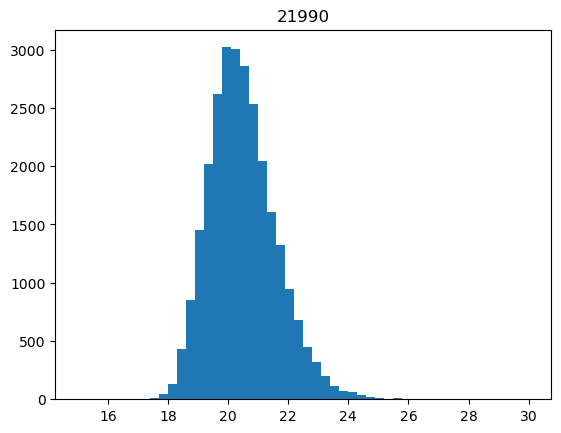

 29%|██████████████████████▉                                                        | 312/1075 [00:41<01:37,  7.82it/s]

6732


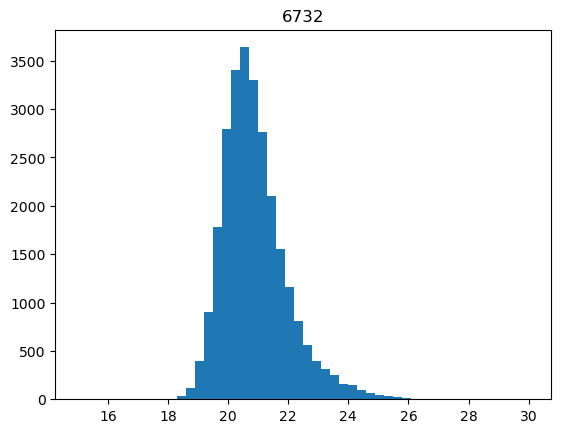

 29%|███████████████████████                                                        | 313/1075 [00:42<01:37,  7.80it/s]

13308


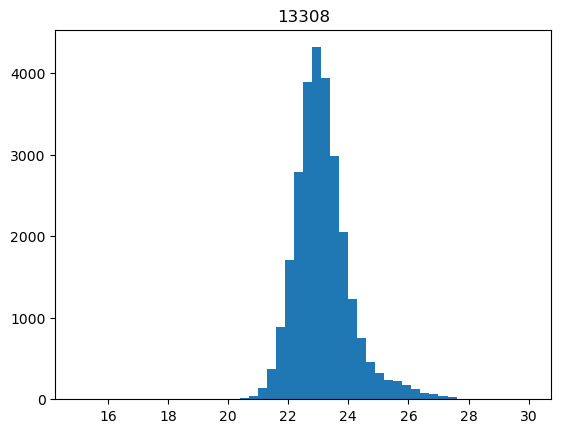

 29%|███████████████████████                                                        | 314/1075 [00:42<01:55,  6.59it/s]

23729


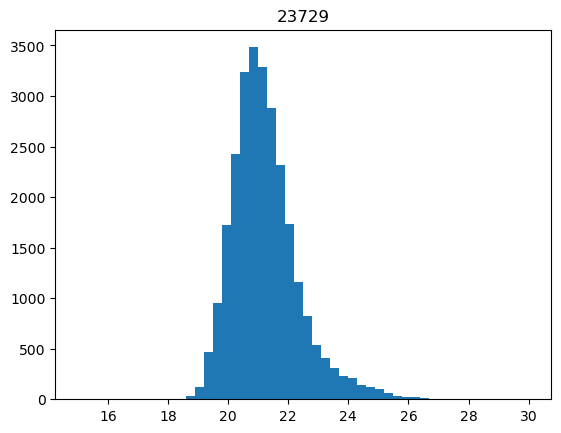

 29%|███████████████████████▏                                                       | 315/1075 [00:42<01:50,  6.88it/s]

17614


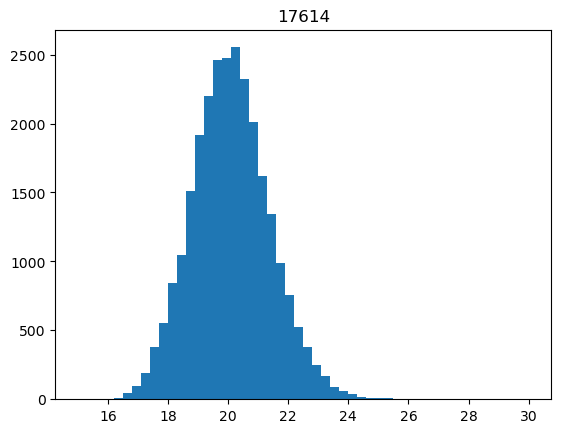

 29%|███████████████████████▏                                                       | 316/1075 [00:42<01:45,  7.18it/s]

19476


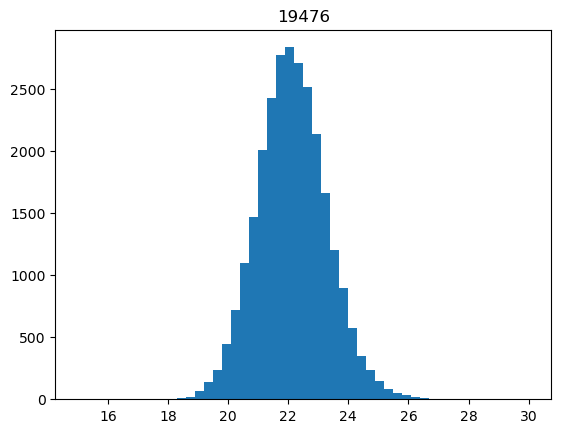

 29%|███████████████████████▎                                                       | 317/1075 [00:42<01:41,  7.44it/s]

10090


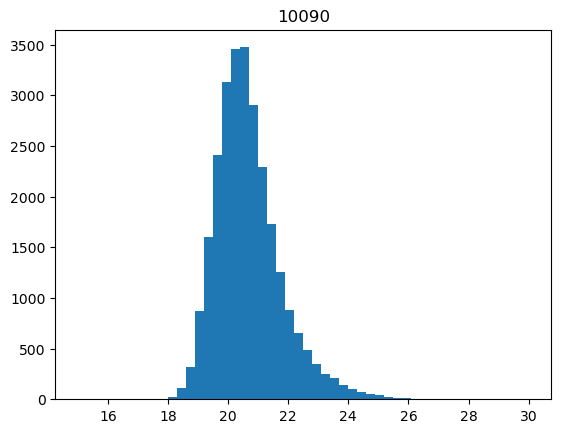

 30%|███████████████████████▎                                                       | 318/1075 [00:42<01:40,  7.57it/s]

4717


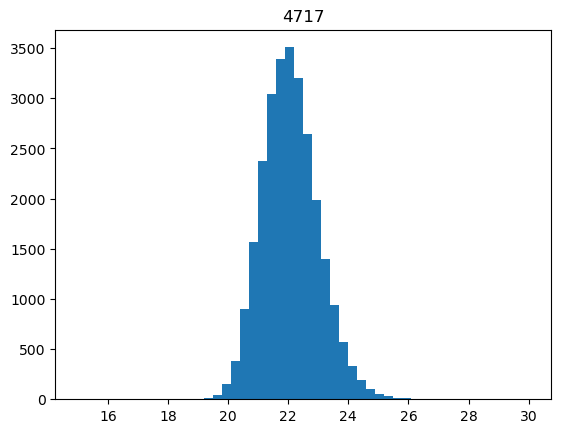

 30%|███████████████████████▍                                                       | 319/1075 [00:42<01:38,  7.67it/s]

16782


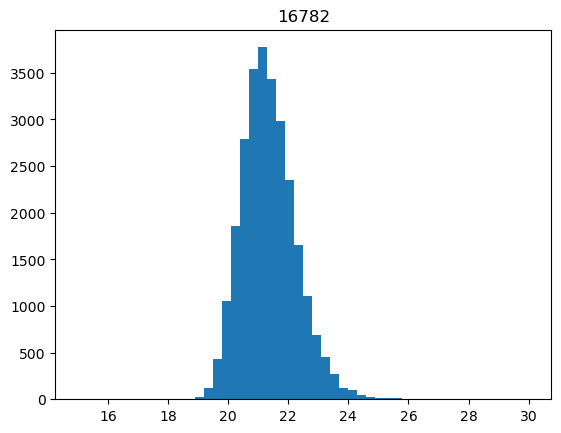

 30%|███████████████████████▌                                                       | 320/1075 [00:43<01:37,  7.77it/s]

11701


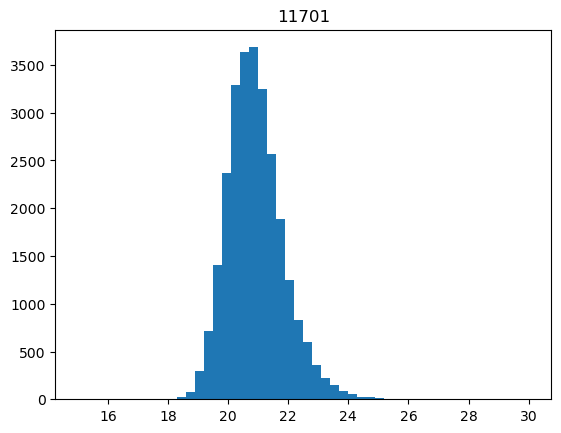

 30%|███████████████████████▌                                                       | 321/1075 [00:43<01:36,  7.84it/s]

1347


 30%|███████████████████████▌                                                       | 321/1075 [00:43<01:41,  7.42it/s]


KeyboardInterrupt: 

In [29]:
# to set our radius interval we are looking at histograms of distances 
for i in tqdm(range(len(landmarks))):
    print(landmarks[i])
    center = landmarks[i]
    plt.hist(dist_mat[center,:], bins = 50, range = (15,30))
    plt.title(center)
    plt.show()

In [ ]:
# eigen plots to determine intrinsic dimensionality
for i in tqdm(range(len(landmarks))):
    print(landmarks[i])
    center = landmarks[i]
    radii, eigval_list, eigvec_list = eigen_calc_from_dist_mat(np_data, dist_mat, center, radint = 0.5)

    rmin = radii[0]
    rmax = radii[-1]
    
    eigen_plot(eigval_list, radii, rmin, rmax)

In [ ]:
# visualizing the radius selected for mSVD on the UMAP/FDL
radius = np.array([19.5,20,19,20.5,19])

for i in tqdm(range(len(landmarks))):
    print(landmarks[i])
    center = landmarks[i]
    radii, eigval_list, eigvec_list = eigen_calc_from_dist_mat(np_data, dist_mat, center, radint = 0.5)

    rmin = radii[0]
    rmax = radii[-1]
    
    eigen_plot(eigval_list, radii, rmin, rmax)
      
    landmark_loc = UMAP[center,:]
    radius_UMAP = np.zeros((1,2))
    for j in range(dist_mat.shape[0]):
        if j > center:
            if dist_mat[center,j] < radius[i]:
                radius_UMAP = np.append(radius_UMAP, np.reshape(UMAP[j,:], (1,2)), axis = 0)
    radius_UMAP = radius_UMAP[1:,:]
    
    frame1 = plt.scatter(UMAP[:,0], UMAP[:,1], s=1, c = "lightgrey")
    frame1 = plt.scatter(radius_UMAP[:,0], radius_UMAP[:,1], s=1, c = "dimgrey")
    frame1 = plt.scatter(landmark_loc[0], landmark_loc[1], s=2, c = "red")
    plt.annotate(center, (UMAP_landmark[i,0], UMAP_landmark[i,1]))
    plt.title('Racute - UMAP: '+str(center)+' Radius: '+str(radius[i]))
    #plt.xlim(-30000,25000)
    frame1.axes.get_xaxis().set_ticks([])
    frame1.axes.get_yaxis().set_ticks([])
    plt.ylabel('UMAP2')
    plt.xlabel('UMAP1')
    plt.show()
    
    landmark_loc = Diff[center,:]
    radius_Diff = np.zeros((1,2))
    for j in range(dist_mat.shape[0]):
        if j > center:
            if dist_mat[center,j] < radius[i]:
                radius_Diff = np.append(radius_Diff, np.reshape(Diff[j,:], (1,2)), axis = 0)
    radius_Diff = radius_Diff[1:,:]
    
    frame1 = plt.scatter(Diff[:,0], Diff[:,1], s=1, c = "lightgrey")
    frame1 = plt.scatter(radius_Diff[:,0], radius_Diff[:,1], s=1, c = "dimgrey")
    frame1 = plt.scatter(landmark_loc[0], landmark_loc[1], s=2, c = "red")
    plt.annotate(center, (Diff_landmark[i,0], Diff_landmark[i,1]))
    plt.title('Racute - Diff: '+str(center)+' Radius: '+str(radius[i]))
    #plt.xlim(-30000,25000)
    frame1.axes.get_xaxis().set_ticks([])
    frame1.axes.get_yaxis().set_ticks([])
    plt.ylabel('FDL2')
    plt.xlabel('FDL1')
    plt.show()

## Subsetting the data - only cells from topic modeling

In [18]:
pd_data = pd.DataFrame(np_data, index = df.index, columns = Gene_list)

In [19]:
subset = []

for label in df.index:
    if np.isnan(df.loc[label]["ILC2_ILC3"]) == False:
        subset.append(label)
    elif np.isnan(df.loc[label]["ILC2_Q"]) == False:
        subset.append(label)
    elif np.isnan(df.loc[label]["ILC3_Q"]) == False:
        subset.append(label)
    elif np.isnan(df.loc[label]["cloud_ILC3"]) == False:
        subset.append(label)
        
pd_topic_cells = pd_data.loc[subset]
topic_cells = np.array(pd_topic_cells)
pd_topic_cells = pd.DataFrame(topic_cells, index = pd_topic_cells.index, columns = Gene_list)

In [20]:
UMAP_df = pd.DataFrame(UMAP, index = df.index)
Diff_df = pd.DataFrame(Diff, index = df.index)

topic_UMAP = np.array(UMAP_df.loc[subset])
topic_Diff = np.array(Diff_df.loc[subset])

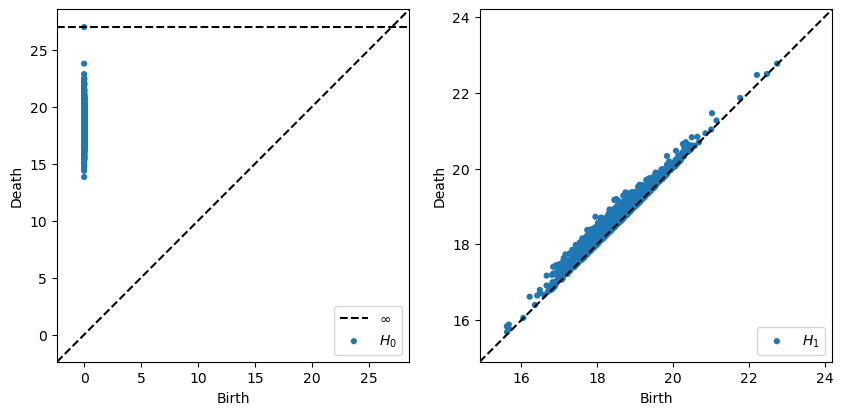

In [45]:
from ripser import ripser
from persim import plot_diagrams


dgms = ripser(topic_cells, maxdim=1)['dgms']


plt.figure(figsize=(10, 5))
plot_diagrams(dgms, plot_only=[0], ax=plt.subplot(121))
plot_diagrams(dgms, plot_only=[1], ax=plt.subplot(122))

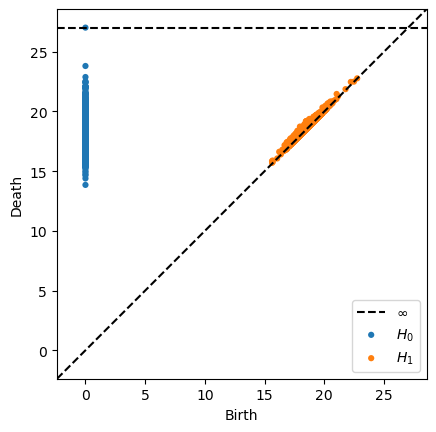

In [46]:
plot_diagrams(dgms, show=True)

### Selecting only top genes identified by topic modeling

In [21]:
ls = ["Fos","Klf6","Klf2","Zfp36","Fosb","Cxcl2","Ccl1","Areg","Il1rl1","Cxcl1","Gzmb","Il17f","Il22","Il17a","Cd3d"]
# looking at cells belonging to one of the topics
gene_sub_topic_cells = pd_topic_cells[ls]
# looking at all cells 
gene_sub_data = pd_data[ls]

In [22]:
gene_sub_data

Fos      Klf6      Klf2     Zfp36      Fosb  \
index                                                                        
Timept0.AAACCCAAGCTATCTG  0.000000  1.945910  0.000000  1.098612  0.000000   
Timept0.AAACCCAAGGTAATCA  1.791759  2.397895  1.098612  0.693147  2.079442   
Timept0.AAACCCAAGTCTAACC  1.386294  1.386294  0.000000  2.302585  2.302585   
Timept0.AAACCCAAGTCTCTGA  0.693147  0.693147  1.098612  0.000000  0.693147   
Timept0.AAACCCACACACCTGG  0.693147  1.386294  0.000000  0.000000  0.693147   
...                            ...       ...       ...       ...       ...   
Timept4.TTTGTTGCAAAGAGTT  0.000000  0.693147  0.000000  0.000000  1.386294   
Timept4.TTTGTTGCAGTCTTCC  0.000000  0.693147  0.000000  0.000000  0.693147   
Timept4.TTTGTTGCATCCAATG  2.484907  1.098612  0.000000  0.000000  1.791759   
Timept4.TTTGTTGTCATTCATC  1.609438  1.098612  0.693147  0.693147  0.693147   
Timept4.TTTGTTGTCGCACTCT  2.302585  1.945910  1.386294  1.098612  0.693147   

                             Cxcl2  Ccl1      Areg    Il1rl1  Cxcl1      Gzmb  \
index                                                                           
Timept0.AAACCCAAGCTATCTG  0.000000   0.0  0.693147  0.000000    0.0  0.000000   
Timept0.AAACCCAAGGTAATCA  0.000000   0.0  0.000000  0.000000    0.0  0.000000   
Timept0.AAACCCAAGTCTAACC  0.000000   0.0  0.000000  0.000000    0.0  0.000000   
Timept0.AAACCCAAGTCTCTGA  0.000000   0.0  1.945910  0.000000    0.0  0.000000   
Timept0.AAACCCACACACCTGG  0.000000   0.0  0.693147  1.098612    0.0  0.000000   
...                            ...   ...       ...       ...    ...       ...   
Timept4.TTTGTTGCAAAGAGTT  2.772589   0.0  3.178054  1.945910    0.0  0.693147   
Timept4.TTTGTTGCAGTCTTCC  0.000000   0.0  0.000000  0.000000    0.0  1.386294   
Timept4.TTTGTTGCATCCAATG  0.000000   0.0  2.302585  0.000000    0.0  0.000000   
Timept4.TTTGTTGTCATTCATC  0.000000   0.0  0.000000  0.000000    0.0  0.000000   
Timept4.TTTGTTGTCGCACTCT  0.000000   0.0  0.000000  0.000000    0.0  0.000000   

                             Il17f  Il22  Il17a     Cd3d  
index                                                     
Timept0.AAACCCAAGCTATCTG  0.000000   0.0    0.0  0.00000  
Timept0.AAACCCAAGGTAATCA  0.000000   0.0    0.0  0.00000  
Timept0.AAACCCAAGTCTAACC  0.000000   0.0    0.0  0.00000  
Timept0.AAACCCAAGTCTCTGA  0.000000   0.0    0.0  0.00000  
Timept0.AAACCCACACACCTGG  0.000000   0.0    0.0  0.00000  
...                            ...   ...    ...      ...  
Timept4.TTTGTTGCAAAGAGTT  0.000000   0.0    0.0  0.00000  
Timept4.TTTGTTGCAGTCTTCC  2.944439   0.0    0.0  1.94591  
Timept4.TTTGTTGCATCCAATG  0.000000   0.0    0.0  0.00000  
Timept4.TTTGTTGTCATTCATC  0.000000   0.0    0.0  0.00000  
Timept4.TTTGTTGTCGCACTCT  0.000000   0.0    0.0  0.00000  

[26877 rows x 15 columns]

In [23]:
gene_sub_data.to_csv('Gene_sub_data_ILC.csv', sep=',')

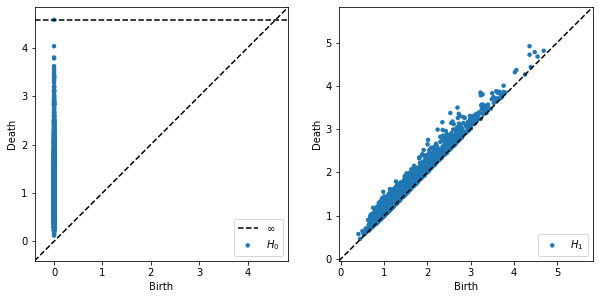

In [24]:
# cells in one of the topics
dgms = ripser(gene_sub_topic_cells.values, maxdim=1)['dgms']


plt.figure(figsize=(10, 5))
plot_diagrams(dgms, plot_only=[0], ax=plt.subplot(121))
plot_diagrams(dgms, plot_only=[1], ax=plt.subplot(122))

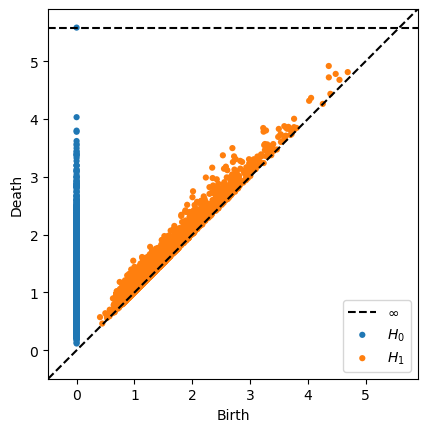

In [50]:
plot_diagrams(dgms, show=True)

In [ ]:
# all cells
dgms = ripser(gene_sub_data.values, maxdim=1)['dgms']


plt.figure(figsize=(10, 5))
plot_diagrams(dgms, plot_only=[0], ax=plt.subplot(121))
plot_diagrams(dgms, plot_only=[1], ax=plt.subplot(122))

In [ ]:
plot_diagrams(dgms, show=True)

No handles with labels found to put in legend.


(3807, 2)


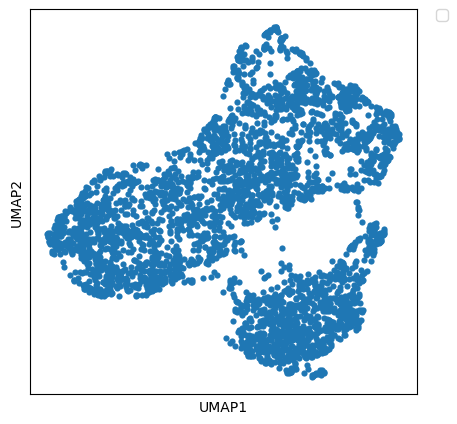

In [25]:
reducer = umap.UMAP()
__UMAP = reducer.fit_transform(gene_sub_topic_cells.values)
print(__UMAP.shape)

plt.figure(figsize=(5, 5))
frame1 = sns.scatterplot(__UMAP[:,0], __UMAP[:,1], s=20,  linewidth = 0)
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [26]:
sub_UMAP = pd.DataFrame(__UMAP)
sub_UMAP.to_csv('sub_data_UMAP_ILC.csv', sep=',')

In [ ]:
label_ILC2_ILC3 = np.isfinite(val_ILC2_ILC3)
label_ILC3_Q = np.isfinite(val_ILC3_Q)
label_ILC2_Q = np.isfinite(val_ILC2_Q)
label_cloud_ILC3 = np.isfinite(val_cloud_ILC3) 

__UMAP_ILC2_ILC3 = np.zeros((1,2))
__UMAP_ILC3_Q = np.zeros((1,2))
__UMAP_ILC2_Q = np.zeros((1,2))
__UMAP_cloud_ILC3 = np.zeros((1,2))

for i in range(UMAP.shape[0]):
    if label_ILC2_ILC3[i] == True:
        __UMAP_ILC2_ILC3 = np.append(__UMAP_ILC2_ILC3, np.reshape(__UMAP[i,:], (1,2)), axis = 0)
        
for i in range(UMAP.shape[0]):
    if label_ILC3_Q[i] == True:
        __UMAP_ILC3_Q = np.append(__UMAP_ILC3_Q, np.reshape(__UMAP[i,:], (1,2)), axis = 0)
        
for i in range(UMAP.shape[0]):
    if label_ILC2_Q[i] == True:
        __UMAP_ILC2_Q = np.append(__UMAP_ILC2_Q, np.reshape(__UMAP[i,:], (1,2)), axis = 0)
        
for i in range(UMAP.shape[0]):
    if label_cloud_ILC3[i] == True:
        __UMAP_cloud_ILC3 = np.append(__UMAP_cloud_ILC3, np.reshape(__UMAP[i,:], (1,2)), axis = 0)
        

        
__UMAP_ILC2_ILC3 = __UMAP_ILC2_ILC3[1:,:]
__UMAP_ILC3_Q = __UMAP_ILC3_Q[1:,:]
__UMAP_ILC2_Q = __UMAP_ILC2_Q[1:,:]
__UMAP_cloud_ILC3 = __UMAP_cloud_ILC3[1:,:]

print(__UMAP_ILC2_ILC3.shape)
print(__UMAP_ILC3_Q.shape)
print(__UMAP_ILC2_Q.shape)
print(__UMAP_cloud_ILC3.shape)

In [ ]:
plt.figure(figsize=(5, 5))

frame1 = plt.scatter(__UMAP[:,0], __UMAP[:,1], s= 1, c = "lightgrey")
plt.scatter(__UMAP_ILC3_Q[:,0], __UMAP_ILC3_Q[:,1], s= 1, c = "midnightblue", label = "Resting ILC3")
plt.scatter(__UMAP_ILC2_Q[:,0], __UMAP_ILC2_Q[:,1], s= 1, c = "salmon", label = "Resting ILC2")
plt.scatter(__UMAP_cloud_ILC3[:,0], __UMAP_cloud_ILC3[:,1], s= 1, c = "gold", label = "ILC3")
plt.scatter(__UMAP_ILC2_ILC3[:,0], __UMAP_ILC2_ILC3[:,1], s= 1, c = "mediumseagreen", label = "ILC2 to ILC3")

#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
plt.figure(figsize=(12, 3))

ax=plt.subplot(141)
frame1 = plt.scatter(__UMAP[:,0], __UMAP[:,1], s= 1, c = "lightgrey")
plt.scatter(__UMAP_ILC3_Q[:,0], __UMAP_ILC3_Q[:,1], s= 1, c = "midnightblue")
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')

ax=plt.subplot(142)
frame1 = plt.scatter(__UMAP[:,0], __UMAP[:,1], s= 1, c = "lightgrey")
plt.scatter(__UMAP_ILC2_Q[:,0], __UMAP_ILC2_Q[:,1], s= 1, c = "salmon")
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')

ax=plt.subplot(143)
frame1 = plt.scatter(__UMAP[:,0], __UMAP[:,1], s= 1, c = "lightgrey")
plt.scatter(__UMAP_cloud_ILC3[:,0], __UMAP_cloud_ILC3[:,1], s= 1, c = "gold")
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')

ax=plt.subplot(144)
frame1 = plt.scatter(__UMAP[:,0], __UMAP[:,1], s= 1, c = "lightgrey")
plt.scatter(__UMAP_ILC2_ILC3[:,0], __UMAP_ILC2_ILC3[:,1], s= 1, c = "mediumseagreen")
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')

plt.show()

### Selecting only principle components

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=20)
pca.fit(pd_topic_cells.values)
PC = pca.transform(pd_topic_cells.values)

var = np.array(pca.explained_variance_ratio_)
pcs = np.arange(1,21)

sns.scatterplot(pcs, var)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principle components')
plt.show()

In [ ]:
data = PC[:,0:10]
reducer = umap.UMAP()
_UMAP = reducer.fit_transform(data)
print(_UMAP.shape)

plt.figure(figsize=(5, 5))
frame1 = sns.scatterplot(_UMAP[:,0], _UMAP[:,1], s=20,  linewidth = 0)
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
print(data.shape)
dgms = ripser(data, maxdim=1)['dgms']


plt.figure(figsize=(10, 10))
plot_diagrams(dgms, plot_only=[0], ax=plt.subplot(221))
plot_diagrams(dgms, plot_only=[1], ax=plt.subplot(222))

In [ ]:
plot_diagrams(dgms, show=True)

In [ ]:
label_ILC2_ILC3 = np.isfinite(val_ILC2_ILC3)
label_ILC3_Q = np.isfinite(val_ILC3_Q)
label_ILC2_Q = np.isfinite(val_ILC2_Q)
label_cloud_ILC3 = np.isfinite(val_cloud_ILC3) 

_UMAP_ILC2_ILC3 = np.zeros((1,2))
_UMAP_ILC3_Q = np.zeros((1,2))
_UMAP_ILC2_Q = np.zeros((1,2))
_UMAP_cloud_ILC3 = np.zeros((1,2))

for i in range(UMAP.shape[0]):
    if label_ILC2_ILC3[i] == True:
        _UMAP_ILC2_ILC3 = np.append(_UMAP_ILC2_ILC3, np.reshape(_UMAP[i,:], (1,2)), axis = 0)
        
for i in range(UMAP.shape[0]):
    if label_ILC3_Q[i] == True:
        _UMAP_ILC3_Q = np.append(_UMAP_ILC3_Q, np.reshape(_UMAP[i,:], (1,2)), axis = 0)
        
for i in range(UMAP.shape[0]):
    if label_ILC2_Q[i] == True:
        _UMAP_ILC2_Q = np.append(_UMAP_ILC2_Q, np.reshape(_UMAP[i,:], (1,2)), axis = 0)
        
for i in range(UMAP.shape[0]):
    if label_cloud_ILC3[i] == True:
        _UMAP_cloud_ILC3 = np.append(_UMAP_cloud_ILC3, np.reshape(_UMAP[i,:], (1,2)), axis = 0)
        

        
_UMAP_ILC2_ILC3 = _UMAP_ILC2_ILC3[1:,:]
_UMAP_ILC3_Q = _UMAP_ILC3_Q[1:,:]
_UMAP_ILC2_Q = _UMAP_ILC2_Q[1:,:]
_UMAP_cloud_ILC3 = _UMAP_cloud_ILC3[1:,:]

print(_UMAP_ILC2_ILC3.shape)
print(_UMAP_ILC3_Q.shape)
print(_UMAP_ILC2_Q.shape)
print(_UMAP_cloud_ILC3.shape)

In [ ]:
plt.figure(figsize=(5, 5))

frame1 = plt.scatter(_UMAP[:,0], _UMAP[:,1], s= 1, c = "lightgrey")
plt.scatter(_UMAP_ILC3_Q[:,0], _UMAP_ILC3_Q[:,1], s= 1, c = "midnightblue", label = "Resting ILC3")
plt.scatter(_UMAP_ILC2_Q[:,0], _UMAP_ILC2_Q[:,1], s= 1, c = "salmon", label = "Resting ILC2")
plt.scatter(_UMAP_cloud_ILC3[:,0], _UMAP_cloud_ILC3[:,1], s= 1, c = "gold", label = "ILC3")
plt.scatter(_UMAP_ILC2_ILC3[:,0], _UMAP_ILC2_ILC3[:,1], s= 1, c = "mediumseagreen", label = "ILC2 to ILC3")

#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
plt.figure(figsize=(12, 3))

ax=plt.subplot(141)
frame1 = plt.scatter(_UMAP[:,0], _UMAP[:,1], s= 1, c = "lightgrey")
plt.scatter(_UMAP_ILC3_Q[:,0], _UMAP_ILC3_Q[:,1], s= 1, c = "midnightblue")
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')

ax=plt.subplot(142)
frame1 = plt.scatter(_UMAP[:,0], _UMAP[:,1], s= 1, c = "lightgrey")
plt.scatter(_UMAP_ILC2_Q[:,0], _UMAP_ILC2_Q[:,1], s= 1, c = "salmon")
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')

ax=plt.subplot(143)
frame1 = plt.scatter(_UMAP[:,0], _UMAP[:,1], s= 1, c = "lightgrey")
plt.scatter(_UMAP_cloud_ILC3[:,0], _UMAP_cloud_ILC3[:,1], s= 1, c = "gold")
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')

ax=plt.subplot(144)
frame1 = plt.scatter(_UMAP[:,0], _UMAP[:,1], s= 1, c = "lightgrey")
plt.scatter(_UMAP_ILC2_ILC3[:,0], _UMAP_ILC2_ILC3[:,1], s= 1, c = "mediumseagreen")
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')

plt.show()